In [1]:
# importing all the necessary libraries!

import os
import warnings
import json
from datetime import datetime 
import pandas as pd
import numpy as np
from math import sqrt
from numpy.random import seed
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from keras.regularizers import L1L2
import seaborn as sns
import matplotlib.pyplot as plt
from keras.models import load_model
from sklearn.metrics import mean_squared_error
from keras.wrappers.scikit_learn import KerasRegressor

import mlflow
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope
plt.rcParams['figure.facecolor'] = 'white'
warnings.simplefilter('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

2022-11-12 14:15:30.717878: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-12 14:15:30.806666: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-12 14:15:30.806682: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-11-12 14:15:30.824990: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-12 14:15:31.319703: W tensorflow/stream_executor/platform/de

In [2]:
# function to create all the necessary directory!

def create_dir(path):
        isExist = os.path.exists(path)
        if not isExist:
            os.makedirs(path, exist_ok = False)
            print("New directory is created")


# dumping all the hyperparameters to json file!
def hyperparms(dictionary):
    # Serializing json
    json_object = json.dumps(dictionary, indent=4)
    
    # Writing to sample.json
    with open(path_metrics +'/'+ 'hyperparm.json', "w") as outfile:
        outfile.write(json_object)

#load and format data

class DataFormatting():
      
    def __init__(self):
        self.df_data = None
        self.df_datetime = None
       
    def dataset(df):

        # converting time colum from object type to datetime format
        df['date'] = pd.to_datetime(df['date'],dayfirst = True, format = '%Y-%m-%d')
        df = df.dropna()
        # splitting the dataframe in to X and y 
        df_data = df[['open','high','low','close']] #'high','low',,'CRUDE_OIL_CLOSE','US500_CLOSE','open','EXCHANGE_RATE',
        df_datetime =df[['date']]

        return df_data, df_datetime


# Data transformation (changing data shape to model requirement)

def data_transformation(data, lags = 5, n_fut = 1):
    
    """ this function transforms dataframe to required input shape for the model.
    It required 2 input arguments:
    1. data: this will be the pandas dataframe
    2. lags: how many previous price points to be used to predict the next future value, in
    this case the default is set to 5 for 'XAUUSD' commodity"""

    # initialize lists to store the dataset
    X_data = []
    y_data = []
    
    for i in range(lags, len(data)- n_fut +1):
        X_data.append(data[i-lags: i, 0: data.shape[1]])
        y_data.append(data[i+ n_fut-1:i+n_fut,3]) # extracts close price with specific lag as price to be predicted.

    # convert the list to numpy array

    X_data = np.array(X_data)
    y_data = np.array(y_data)

    return X_data, y_data

class LSTM_model():
    

    def __init__(self,n_hidden_layers, units, dropout, train_data_X, train_data_y, epochs, reg):

        self.n_hidden_layers = n_hidden_layers
        self.units = units
        self.dropout = dropout
        self.train_data_X = train_data_X
        self.train_data_y = train_data_y
        self.epochs = epochs
        self.reg = reg

    def build_model(self):
        
        model = Sequential()
        # first lstm layer
        model.add(LSTM(self.units, activation='tanh', input_shape=(self.train_data_X.shape[1], self.train_data_X.shape[2]), kernel_regularizer=self.reg, return_sequences=True))

        if self.n_hidden_layers !=1:

            # building hidden layers
            for i in range(1, self.n_hidden_layers):
                # for the last layer as the return sequence is False
                if i == self.n_hidden_layers -1:
                    model.add(LSTM(int(self.units/(2**i)),  activation='tanh', return_sequences=False))
                else:
                    model.add(LSTM(int(self.units/(2**i)),  activation='tanh', return_sequences=True))

        else:
            model.add(LSTM(int(self.units/2),  activation='tanh', return_sequences=False))

        # adding dropout layer
        model.add(Dropout(self.dropout))
        # final layer
        model.add(Dense(self.train_data_y.shape[1]))

        return model

class Bi_LSTM_model():
    

    def __init__(self,n_hidden_layers, units, dropout, train_data_X, train_data_y, epochs, reg):

        self.n_hidden_layers = n_hidden_layers
        self.units = units
        self.dropout = dropout
        self.train_data_X = train_data_X
        self.train_data_y = train_data_y
        self.epochs = epochs
        self.reg = reg

    def build_model(self):
        
        model = Sequential()
        # first lstm layer
        model.add(Bidirectional(LSTM(self.units, activation='tanh', input_shape=(self.train_data_X.shape[1], self.train_data_X.shape[2]), kernel_regularizer=self.reg, return_sequences=True)))
        # building hidden layers
        
        if self.n_hidden_layers !=1:

            for i in range(1, self.n_hidden_layers):
                # for the last layer as the return sequence is False
                if i == self.n_hidden_layers -1:
                    model.add(Bidirectional(LSTM(int(self.units/(2**i)),  activation='tanh', return_sequences=False)))
                else:
                    model.add(Bidirectional(LSTM(int(self.units/(2**i)),  activation='tanh', return_sequences=True)))

        else:
            model.add(Bidirectional(LSTM(int(self.units/2),  activation='tanh', return_sequences=False)))
        
        # adding dropout layer
        model.add(Dropout(self.dropout))
        # final layer
        model.add(Dense(self.train_data_y.shape[1]))
    
        return model

def metricplot(df, xlab, ylab_1,ylab_2, path):
    
    """
    This function plots metric curves and saves it
    to respective folder
    inputs: df : pandas dataframe 
            xlab: x-axis
            ylab_1 : yaxis_1
            ylab_2 : yaxis_2
            path: full path for saving the plot
            """
    plt.figure()
    sns.set_theme(style="darkgrid")
    sns.lineplot(x = df[xlab], y = df[ylab_1])
    sns.lineplot(x = df[xlab], y = df[ylab_2])
    plt.xlabel('Epochs',fontsize = 12)
    plt.ylabel(ylab_1,fontsize = 12)
    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 12)
    plt.legend([ylab_1,ylab_2], prop={"size":12})
    plt.savefig(path+'/'+ ylab_1)

In [3]:
#DATEBASE_NAME = input('Enter new database name:')
mlflow.set_tracking_uri("sqlite:///EU_lstm.db")
mlflow.set_experiment("Currency_Price_Forecasting")
mlflow.keras.autolog()
with mlflow.start_run():
    mlflow.set_tag('mleng','Jayesh')
    # loading the dataset!
    data = pd.read_csv('../data/macro_data/EURUSD.csv',index_col=[0]) 

    seed(42)
    tf.random.set_seed(42) 
    keras.backend.clear_session()

    # hyperparameters
    train_size_percent = 90
    lag = 5
    n_fut = 1
    n_hidden_layers = 3
    batch_size = 128 #256
    units = 192 
    dropout = 0
    epochs = 700
    learning_rate = 1.22556185e-05
    l1 = 0.001758323799832654
    l2 = 0.04727729600605428
    reg = L1L2(l1=l1, l2=l2)

    # creating main folder
    today = datetime.now()
    today  = today.strftime('%Y_%m_%d')
    path = '../Model_Outputs/'+ today
    create_dir(path)

    # Which model to run: 
    # MODEL_NAME = input('Enter the name LSTM or BILSTM:')
    # creating directory to save model and its output
    EXPERIMENT_NAME = input('Enter new Experiment name:')
    print('\n')
    print('A folder with',EXPERIMENT_NAME,'name has be created to store all the model details!')
    print('\n')
    folder = EXPERIMENT_NAME
    path_main = path + '/'+ folder
    create_dir(path_main)

    # creating directory to save model and its output
    folder = 'model_Bilstm'#+ str(units) + '_' + str(n_hidden_layers)
    path_dir = path_main + '/'+ folder
    create_dir(path_dir)

    # creating directory to save all the metric data
    folder = 'metrics'
    path_metrics = path_dir +'/'+ folder
    create_dir(path_metrics)

    # creating folder to save model.h5 file
    folder = 'model'
    path_model = path_dir +'/'+ folder
    create_dir(path_model)

    # creating folder to save model.h5 file
    folder = 'model_checkpoint'
    path_checkpoint = path_dir +'/'+ folder
    create_dir(path_checkpoint)

    # creating folder to save model.h5 file
    folder = 'forecasting_resutls'
    path_forecast = path_dir +'/'+ folder
    create_dir(path_forecast)



A folder with EURUSD name has be created to store all the model details!


New directory is created
New directory is created
New directory is created
New directory is created
New directory is created
New directory is created


In [4]:
# initializing DataFormatting class
data_init = DataFormatting()
df_data, df_datetime = DataFormatting.dataset(data)
print('\n')
print('Displaying top 5 rows of the dataset:')
print('\n')
print(df_data.head())
print(df_data.shape)
print(df_data.columns)
df_colnames = list(df_data.columns)
# normalize train, val and test dataset

# initialize StandartScaler()
scaler = StandardScaler()
scaler = scaler.fit(df_data)
data_fit_transformed = scaler.transform(df_data)


print('\n')
print('Displaying top 5 rows of all the scaled dataset:')
print('\n')
#print('The train dateset:','\n''\n',data_fit_transformed[0:5],'\n''\n', 'The validation dataset:','\n''\n',val_transformed[0:5],'\n''\n','The test dataset:','\n''\n',test_transformed[0:5])
print('The train dateset:','\n''\n',data_fit_transformed[0:10])

# changing shape of the data to match the model requirement!

X_data, y_data = data_transformation(data_fit_transformed, lags = lag, n_fut = n_fut)
print('\n')
print('Displaying the shape of the dataset required by the model:')
print('\n')
print(f' Input shape X:',X_data.shape, f'Input shape y:',y_data.shape)
print('\n')
#print(X_data)
print(y_data[0:10])
#setting the model file name
model_name = 'lstm_'+ str(units)+'.h5'


train_data_X = X_data
train_data_y = y_data

# split train and test

# traininig 
size_df = X_data.shape[0]
train_size_percent = train_size_percent/100
train_size = int(round(size_df*train_size_percent,0))
x_train = X_data[:train_size,:]
y_train = y_data[:train_size,:]

# testing

x_test = X_data[train_size:,:]
y_test = y_data[train_size:,:]

print(x_test.shape)
print(y_test.shape)

dictionary = {
"lags": lag,
"n_fut": n_fut,
"n_hidden_layers": n_hidden_layers,
"batch_size": batch_size,
"units": units,
"dropout": dropout,
"epochs": epochs,
"learning_rate": learning_rate,
"reg_l1": l1,
"reg_l2": l2,
"features":df_colnames,  
}
mlflow.log_param('dict',dictionary)

print('The hyperparameters for the current experiments:')
print(dictionary)
# dump all the hyperparameters in to a dictionary and save to .json file
hyperparms(dictionary)



Displaying top 5 rows of the dataset:


     open    high     low   close
0  0.7444  0.7462  0.7433  0.7442
1  0.7461  0.7468  0.7441  0.7459
2  0.7495  0.7495  0.7495  0.7495
3  0.7471  0.7471  0.7471  0.7471
4  0.7449  0.7456  0.7448  0.7450
(10000, 4)
Index(['open', 'high', 'low', 'close'], dtype='object')


Displaying top 5 rows of all the scaled dataset:


The train dateset: 

 [[-2.31481834 -2.31753209 -2.30934459 -2.31655888]
 [-2.30535462 -2.31421367 -2.3048607  -2.30709392]
 [-2.28642718 -2.2992808  -2.27459447 -2.28705048]
 [-2.29978773 -2.31255446 -2.28804613 -2.30041278]
 [-2.3120349  -2.3208505  -2.3009373  -2.31210478]
 [-2.32483876 -2.33412417 -2.31438896 -2.32491031]
 [-2.33541586 -2.34020793 -2.32559867 -2.33604556]
 [-2.34543627 -2.35680002 -2.33400596 -2.34551052]
 [-2.36659047 -2.37892279 -2.35530442 -2.36722424]
 [-2.36547709 -2.36177764 -2.36427219 -2.36778101]]


Displaying the shape of the dataset required by the model:


 Input shape X: (9995, 5, 4) Input sha

In [5]:
#if MODEL_NAME == 'LSTM':

# initializing model
model_init = LSTM_model(n_hidden_layers, units, dropout, x_train, y_train, epochs, reg)

# calling the model
model = model_init.build_model()
model.build((x_train.shape[0],x_train.shape[1], x_train.shape[2]))
print(model.summary())

2022-11-12 14:15:39.101573: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-11-12 14:15:39.101612: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-12 14:15:39.101636: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (deeplearning): /proc/driver/nvidia/version does not exist
2022-11-12 14:15:39.101918: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5, 192)            151296    
                                                                 
 lstm_1 (LSTM)               (None, 5, 96)             110976    
                                                                 
 lstm_2 (LSTM)               (None, 48)                27840     
                                                                 
 dropout (Dropout)           (None, 48)                0         
                                                                 
 dense (Dense)               (None, 1)                 49        
                                                                 
Total params: 290,161
Trainable params: 290,161
Non-trainable params: 0
_________________________________________________________________
None


In [6]:
#metrics for evaluating the model



metrics = [tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanAbsoluteError(), tf.keras.metrics.MeanAbsolutePercentageError()]

# model compiler
model.compile(optimizer=Adam(learning_rate = learning_rate), loss='mse', metrics = metrics)
print(model.summary())


#setting the callback function
cb = [
    tf.keras.callbacks.ModelCheckpoint(path_checkpoint),
    tf.keras.callbacks.CSVLogger(path_metrics+'/'+'data.csv')]
    #tf.keras.callbacks.EarlyStopping(monitor='val_root_mean_squared_error', patience=, restore_best_weights=False)]




# model fitting protocol
history = model.fit(x_train, y_train,
                    epochs = epochs, 
                    batch_size = batch_size,  
                    validation_data=(x_test, y_test),
                    verbose = 1,
                    callbacks=[cb],
                    shuffle= False,
                    workers = 8,
                    use_multiprocessing = True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5, 192)            151296    
                                                                 
 lstm_1 (LSTM)               (None, 5, 96)             110976    
                                                                 
 lstm_2 (LSTM)               (None, 48)                27840     
                                                                 
 dropout (Dropout)           (None, 48)                0         
                                                                 
 dense (Dense)               (None, 1)                 49        
                                                                 
Total params: 290,161
Trainable params: 290,161
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/700
71/71 [==========================

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 16s 155ms/step - loss: 1.6349 - root_mean_squared_error: 1.0071 - mean_absolute_error: 0.7710 - mean_absolute_percentage_error: 97.6547 - val_loss: 0.7359 - val_root_mean_squared_error: 0.3474 - val_mean_absolute_error: 0.2744 - val_mean_absolute_percentage_error: 98.8732
Epoch 2/700
70/71 [============================>.] - ETA: 0s - loss: 1.5688 - root_mean_squared_error: 0.9791 - mean_absolute_error: 0.7493 - mean_absolute_percentage_error: 96.1942

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 115ms/step - loss: 1.5650 - root_mean_squared_error: 0.9772 - mean_absolute_error: 0.7468 - mean_absolute_percentage_error: 96.1688 - val_loss: 0.7171 - val_root_mean_squared_error: 0.3353 - val_mean_absolute_error: 0.2647 - val_mean_absolute_percentage_error: 101.3448
Epoch 3/700
70/71 [============================>.] - ETA: 0s - loss: 1.4932 - root_mean_squared_error: 0.9453 - mean_absolute_error: 0.7219 - mean_absolute_percentage_error: 94.6517

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 10s 137ms/step - loss: 1.4897 - root_mean_squared_error: 0.9434 - mean_absolute_error: 0.7195 - mean_absolute_percentage_error: 94.6171 - val_loss: 0.6978 - val_root_mean_squared_error: 0.3216 - val_mean_absolute_error: 0.2536 - val_mean_absolute_percentage_error: 103.9109
Epoch 4/700
69/71 [============================>.] - ETA: 0s - loss: 1.4245 - root_mean_squared_error: 0.9137 - mean_absolute_error: 0.7002 - mean_absolute_percentage_error: 87.1780

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 9s 127ms/step - loss: 1.4093 - root_mean_squared_error: 0.9054 - mean_absolute_error: 0.6886 - mean_absolute_percentage_error: 92.9841 - val_loss: 0.6781 - val_root_mean_squared_error: 0.3057 - val_mean_absolute_error: 0.2409 - val_mean_absolute_percentage_error: 106.8621
Epoch 5/700
68/71 [===========================>..] - ETA: 0s - loss: 1.3473 - root_mean_squared_error: 0.8758 - mean_absolute_error: 0.6706 - mean_absolute_percentage_error: 83.6931

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 115ms/step - loss: 1.3232 - root_mean_squared_error: 0.8621 - mean_absolute_error: 0.6532 - mean_absolute_percentage_error: 91.2674 - val_loss: 0.6578 - val_root_mean_squared_error: 0.2873 - val_mean_absolute_error: 0.2260 - val_mean_absolute_percentage_error: 110.5078
Epoch 6/700
69/71 [============================>.] - ETA: 0s - loss: 1.2436 - root_mean_squared_error: 0.8202 - mean_absolute_error: 0.6229 - mean_absolute_percentage_error: 79.5599

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 114ms/step - loss: 1.2313 - root_mean_squared_error: 0.8127 - mean_absolute_error: 0.6126 - mean_absolute_percentage_error: 89.4178 - val_loss: 0.6369 - val_root_mean_squared_error: 0.2659 - val_mean_absolute_error: 0.2088 - val_mean_absolute_percentage_error: 114.8898
Epoch 7/700
70/71 [============================>.] - ETA: 0s - loss: 1.1371 - root_mean_squared_error: 0.7583 - mean_absolute_error: 0.5682 - mean_absolute_percentage_error: 87.5457

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 116ms/step - loss: 1.1348 - root_mean_squared_error: 0.7568 - mean_absolute_error: 0.5663 - mean_absolute_percentage_error: 87.4481 - val_loss: 0.6158 - val_root_mean_squared_error: 0.2412 - val_mean_absolute_error: 0.1888 - val_mean_absolute_percentage_error: 120.0676
Epoch 8/700
70/71 [============================>.] - ETA: 0s - loss: 1.0382 - root_mean_squared_error: 0.6961 - mean_absolute_error: 0.5162 - mean_absolute_percentage_error: 85.6188

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 116ms/step - loss: 1.0363 - root_mean_squared_error: 0.6948 - mean_absolute_error: 0.5144 - mean_absolute_percentage_error: 85.4963 - val_loss: 0.5948 - val_root_mean_squared_error: 0.2133 - val_mean_absolute_error: 0.1662 - val_mean_absolute_percentage_error: 126.0560
Epoch 9/700
68/71 [===========================>..] - ETA: 0s - loss: 0.9523 - root_mean_squared_error: 0.6378 - mean_absolute_error: 0.4701 - mean_absolute_percentage_error: 65.3624

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 113ms/step - loss: 0.9394 - root_mean_squared_error: 0.6277 - mean_absolute_error: 0.4577 - mean_absolute_percentage_error: 83.6607 - val_loss: 0.5746 - val_root_mean_squared_error: 0.1827 - val_mean_absolute_error: 0.1414 - val_mean_absolute_percentage_error: 133.0220
Epoch 10/700
70/71 [============================>.] - ETA: 0s - loss: 0.8499 - root_mean_squared_error: 0.5589 - mean_absolute_error: 0.3995 - mean_absolute_percentage_error: 82.3427

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 117ms/step - loss: 0.8487 - root_mean_squared_error: 0.5578 - mean_absolute_error: 0.3981 - mean_absolute_percentage_error: 82.1656 - val_loss: 0.5561 - val_root_mean_squared_error: 0.1505 - val_mean_absolute_error: 0.1154 - val_mean_absolute_percentage_error: 141.1902
Epoch 11/700
69/71 [============================>.] - ETA: 0s - loss: 0.7725 - root_mean_squared_error: 0.4927 - mean_absolute_error: 0.3435 - mean_absolute_percentage_error: 55.5323

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 107ms/step - loss: 0.7681 - root_mean_squared_error: 0.4882 - mean_absolute_error: 0.3380 - mean_absolute_percentage_error: 81.3077 - val_loss: 0.5397 - val_root_mean_squared_error: 0.1184 - val_mean_absolute_error: 0.0899 - val_mean_absolute_percentage_error: 150.8555
Epoch 12/700
70/71 [============================>.] - ETA: 0s - loss: 0.7010 - root_mean_squared_error: 0.4231 - mean_absolute_error: 0.2814 - mean_absolute_percentage_error: 81.5224

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 120ms/step - loss: 0.7003 - root_mean_squared_error: 0.4223 - mean_absolute_error: 0.2804 - mean_absolute_percentage_error: 81.2972 - val_loss: 0.5259 - val_root_mean_squared_error: 0.0892 - val_mean_absolute_error: 0.0669 - val_mean_absolute_percentage_error: 162.4012
Epoch 13/700
70/71 [============================>.] - ETA: 0s - loss: 0.6468 - root_mean_squared_error: 0.3640 - mean_absolute_error: 0.2298 - mean_absolute_percentage_error: 82.6016

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 108ms/step - loss: 0.6462 - root_mean_squared_error: 0.3633 - mean_absolute_error: 0.2291 - mean_absolute_percentage_error: 82.3617 - val_loss: 0.5147 - val_root_mean_squared_error: 0.0667 - val_mean_absolute_error: 0.0495 - val_mean_absolute_percentage_error: 176.4558
Epoch 14/700
70/71 [============================>.] - ETA: 0s - loss: 0.6054 - root_mean_squared_error: 0.3145 - mean_absolute_error: 0.1883 - mean_absolute_percentage_error: 85.0330

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 115ms/step - loss: 0.6050 - root_mean_squared_error: 0.3139 - mean_absolute_error: 0.1876 - mean_absolute_percentage_error: 84.7829 - val_loss: 0.5055 - val_root_mean_squared_error: 0.0553 - val_mean_absolute_error: 0.0417 - val_mean_absolute_percentage_error: 193.4902
Epoch 15/700
70/71 [============================>.] - ETA: 0s - loss: 0.5748 - root_mean_squared_error: 0.2760 - mean_absolute_error: 0.1591 - mean_absolute_percentage_error: 88.7456

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 117ms/step - loss: 0.5745 - root_mean_squared_error: 0.2754 - mean_absolute_error: 0.1586 - mean_absolute_percentage_error: 88.4870 - val_loss: 0.4977 - val_root_mean_squared_error: 0.0562 - val_mean_absolute_error: 0.0429 - val_mean_absolute_percentage_error: 212.4441
Epoch 16/700
71/71 [==============================] - ETA: 0s - loss: 0.5520 - root_mean_squared_error: 0.2475 - mean_absolute_error: 0.1419 - mean_absolute_percentage_error: 93.0303

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 10s 141ms/step - loss: 0.5520 - root_mean_squared_error: 0.2475 - mean_absolute_error: 0.1419 - mean_absolute_percentage_error: 93.0303 - val_loss: 0.4906 - val_root_mean_squared_error: 0.0636 - val_mean_absolute_error: 0.0489 - val_mean_absolute_percentage_error: 232.0673
Epoch 17/700
70/71 [============================>.] - ETA: 0s - loss: 0.5351 - root_mean_squared_error: 0.2290 - mean_absolute_error: 0.1345 - mean_absolute_percentage_error: 98.0198

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 10s 149ms/step - loss: 0.5349 - root_mean_squared_error: 0.2285 - mean_absolute_error: 0.1341 - mean_absolute_percentage_error: 97.7372 - val_loss: 0.4837 - val_root_mean_squared_error: 0.0720 - val_mean_absolute_error: 0.0558 - val_mean_absolute_percentage_error: 251.4440
Epoch 18/700
68/71 [===========================>..] - ETA: 0s - loss: 0.5228 - root_mean_squared_error: 0.2193 - mean_absolute_error: 0.1342 - mean_absolute_percentage_error: 55.1783

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 106ms/step - loss: 0.5213 - root_mean_squared_error: 0.2161 - mean_absolute_error: 0.1316 - mean_absolute_percentage_error: 102.1328 - val_loss: 0.4767 - val_root_mean_squared_error: 0.0790 - val_mean_absolute_error: 0.0614 - val_mean_absolute_percentage_error: 269.8965
Epoch 19/700
68/71 [===========================>..] - ETA: 0s - loss: 0.5112 - root_mean_squared_error: 0.2110 - mean_absolute_error: 0.1339 - mean_absolute_percentage_error: 56.9796

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 117ms/step - loss: 0.5098 - root_mean_squared_error: 0.2080 - mean_absolute_error: 0.1314 - mean_absolute_percentage_error: 105.9588 - val_loss: 0.4694 - val_root_mean_squared_error: 0.0840 - val_mean_absolute_error: 0.0655 - val_mean_absolute_percentage_error: 287.1951
Epoch 20/700
68/71 [===========================>..] - ETA: 0s - loss: 0.5007 - root_mean_squared_error: 0.2054 - mean_absolute_error: 0.1341 - mean_absolute_percentage_error: 58.3886

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 112ms/step - loss: 0.4994 - root_mean_squared_error: 0.2025 - mean_absolute_error: 0.1317 - mean_absolute_percentage_error: 109.1753 - val_loss: 0.4618 - val_root_mean_squared_error: 0.0871 - val_mean_absolute_error: 0.0680 - val_mean_absolute_percentage_error: 303.2684
Epoch 21/700
69/71 [============================>.] - ETA: 0s - loss: 0.4904 - root_mean_squared_error: 0.2001 - mean_absolute_error: 0.1333 - mean_absolute_percentage_error: 59.0317

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 117ms/step - loss: 0.4897 - root_mean_squared_error: 0.1985 - mean_absolute_error: 0.1318 - mean_absolute_percentage_error: 111.8290 - val_loss: 0.4540 - val_root_mean_squared_error: 0.0888 - val_mean_absolute_error: 0.0693 - val_mean_absolute_percentage_error: 318.1176
Epoch 22/700
68/71 [===========================>..] - ETA: 0s - loss: 0.4816 - root_mean_squared_error: 0.1980 - mean_absolute_error: 0.1338 - mean_absolute_percentage_error: 60.1575

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 106ms/step - loss: 0.4804 - root_mean_squared_error: 0.1953 - mean_absolute_error: 0.1316 - mean_absolute_percentage_error: 114.0082 - val_loss: 0.4461 - val_root_mean_squared_error: 0.0894 - val_mean_absolute_error: 0.0698 - val_mean_absolute_percentage_error: 331.8975
Epoch 23/700
68/71 [===========================>..] - ETA: 0s - loss: 0.4725 - root_mean_squared_error: 0.1952 - mean_absolute_error: 0.1332 - mean_absolute_percentage_error: 60.6656

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 119ms/step - loss: 0.4713 - root_mean_squared_error: 0.1925 - mean_absolute_error: 0.1310 - mean_absolute_percentage_error: 115.8192 - val_loss: 0.4382 - val_root_mean_squared_error: 0.0894 - val_mean_absolute_error: 0.0698 - val_mean_absolute_percentage_error: 344.6439
Epoch 24/700
68/71 [===========================>..] - ETA: 0s - loss: 0.4636 - root_mean_squared_error: 0.1926 - mean_absolute_error: 0.1324 - mean_absolute_percentage_error: 61.0463

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 108ms/step - loss: 0.4625 - root_mean_squared_error: 0.1900 - mean_absolute_error: 0.1302 - mean_absolute_percentage_error: 117.3720 - val_loss: 0.4302 - val_root_mean_squared_error: 0.0889 - val_mean_absolute_error: 0.0694 - val_mean_absolute_percentage_error: 356.6182
Epoch 25/700
68/71 [===========================>..] - ETA: 0s - loss: 0.4549 - root_mean_squared_error: 0.1903 - mean_absolute_error: 0.1313 - mean_absolute_percentage_error: 61.3550

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 119ms/step - loss: 0.4538 - root_mean_squared_error: 0.1877 - mean_absolute_error: 0.1292 - mean_absolute_percentage_error: 118.7357 - val_loss: 0.4223 - val_root_mean_squared_error: 0.0882 - val_mean_absolute_error: 0.0688 - val_mean_absolute_percentage_error: 367.5954
Epoch 26/700
70/71 [============================>.] - ETA: 0s - loss: 0.4454 - root_mean_squared_error: 0.1859 - mean_absolute_error: 0.1285 - mean_absolute_percentage_error: 120.3107

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 112ms/step - loss: 0.4452 - root_mean_squared_error: 0.1855 - mean_absolute_error: 0.1281 - mean_absolute_percentage_error: 119.9309 - val_loss: 0.4144 - val_root_mean_squared_error: 0.0873 - val_mean_absolute_error: 0.0681 - val_mean_absolute_percentage_error: 377.6727
Epoch 27/700
68/71 [===========================>..] - ETA: 0s - loss: 0.4378 - root_mean_squared_error: 0.1858 - mean_absolute_error: 0.1290 - mean_absolute_percentage_error: 61.8116

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 115ms/step - loss: 0.4368 - root_mean_squared_error: 0.1834 - mean_absolute_error: 0.1270 - mean_absolute_percentage_error: 121.0007 - val_loss: 0.4067 - val_root_mean_squared_error: 0.0864 - val_mean_absolute_error: 0.0674 - val_mean_absolute_percentage_error: 386.9052
Epoch 28/700
68/71 [===========================>..] - ETA: 0s - loss: 0.4294 - root_mean_squared_error: 0.1837 - mean_absolute_error: 0.1278 - mean_absolute_percentage_error: 61.9845

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 116ms/step - loss: 0.4285 - root_mean_squared_error: 0.1814 - mean_absolute_error: 0.1258 - mean_absolute_percentage_error: 121.9430 - val_loss: 0.3990 - val_root_mean_squared_error: 0.0855 - val_mean_absolute_error: 0.0666 - val_mean_absolute_percentage_error: 395.3003
Epoch 29/700
70/71 [============================>.] - ETA: 0s - loss: 0.4204 - root_mean_squared_error: 0.1797 - mean_absolute_error: 0.1250 - mean_absolute_percentage_error: 123.1869

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 116ms/step - loss: 0.4203 - root_mean_squared_error: 0.1794 - mean_absolute_error: 0.1246 - mean_absolute_percentage_error: 122.7917 - val_loss: 0.3914 - val_root_mean_squared_error: 0.0846 - val_mean_absolute_error: 0.0659 - val_mean_absolute_percentage_error: 402.8985
Epoch 30/700
70/71 [============================>.] - ETA: 0s - loss: 0.4123 - root_mean_squared_error: 0.1778 - mean_absolute_error: 0.1238 - mean_absolute_percentage_error: 123.9355

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 9s 126ms/step - loss: 0.4122 - root_mean_squared_error: 0.1774 - mean_absolute_error: 0.1234 - mean_absolute_percentage_error: 123.5367 - val_loss: 0.3840 - val_root_mean_squared_error: 0.0838 - val_mean_absolute_error: 0.0652 - val_mean_absolute_percentage_error: 409.7386
Epoch 31/700
70/71 [============================>.] - ETA: 0s - loss: 0.4044 - root_mean_squared_error: 0.1758 - mean_absolute_error: 0.1226 - mean_absolute_percentage_error: 124.5764

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 9s 122ms/step - loss: 0.4043 - root_mean_squared_error: 0.1755 - mean_absolute_error: 0.1223 - mean_absolute_percentage_error: 124.1746 - val_loss: 0.3766 - val_root_mean_squared_error: 0.0830 - val_mean_absolute_error: 0.0646 - val_mean_absolute_percentage_error: 415.8688
Epoch 32/700
69/71 [============================>.] - ETA: 0s - loss: 0.3970 - root_mean_squared_error: 0.1750 - mean_absolute_error: 0.1223 - mean_absolute_percentage_error: 62.0574

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 106ms/step - loss: 0.3964 - root_mean_squared_error: 0.1736 - mean_absolute_error: 0.1211 - mean_absolute_percentage_error: 124.7119 - val_loss: 0.3694 - val_root_mean_squared_error: 0.0822 - val_mean_absolute_error: 0.0640 - val_mean_absolute_percentage_error: 421.2985
Epoch 33/700
68/71 [===========================>..] - ETA: 0s - loss: 0.3896 - root_mean_squared_error: 0.1740 - mean_absolute_error: 0.1217 - mean_absolute_percentage_error: 62.4855

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 9s 122ms/step - loss: 0.3887 - root_mean_squared_error: 0.1718 - mean_absolute_error: 0.1200 - mean_absolute_percentage_error: 125.1609 - val_loss: 0.3622 - val_root_mean_squared_error: 0.0815 - val_mean_absolute_error: 0.0635 - val_mean_absolute_percentage_error: 426.0728
Epoch 34/700
71/71 [==============================] - ETA: 0s - loss: 0.3811 - root_mean_squared_error: 0.1700 - mean_absolute_error: 0.1189 - mean_absolute_percentage_error: 125.5208

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 106ms/step - loss: 0.3811 - root_mean_squared_error: 0.1700 - mean_absolute_error: 0.1189 - mean_absolute_percentage_error: 125.5208 - val_loss: 0.3552 - val_root_mean_squared_error: 0.0808 - val_mean_absolute_error: 0.0630 - val_mean_absolute_percentage_error: 430.2111
Epoch 35/700
69/71 [============================>.] - ETA: 0s - loss: 0.3742 - root_mean_squared_error: 0.1695 - mean_absolute_error: 0.1189 - mean_absolute_percentage_error: 62.1088

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 9s 128ms/step - loss: 0.3737 - root_mean_squared_error: 0.1682 - mean_absolute_error: 0.1178 - mean_absolute_percentage_error: 125.7954 - val_loss: 0.3483 - val_root_mean_squared_error: 0.0801 - val_mean_absolute_error: 0.0625 - val_mean_absolute_percentage_error: 433.7404
Epoch 36/700
68/71 [===========================>..] - ETA: 0s - loss: 0.3671 - root_mean_squared_error: 0.1685 - mean_absolute_error: 0.1183 - mean_absolute_percentage_error: 62.4618

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 106ms/step - loss: 0.3663 - root_mean_squared_error: 0.1665 - mean_absolute_error: 0.1167 - mean_absolute_percentage_error: 125.9902 - val_loss: 0.3415 - val_root_mean_squared_error: 0.0795 - val_mean_absolute_error: 0.0621 - val_mean_absolute_percentage_error: 436.6783
Epoch 37/700
70/71 [============================>.] - ETA: 0s - loss: 0.3592 - root_mean_squared_error: 0.1651 - mean_absolute_error: 0.1159 - mean_absolute_percentage_error: 126.5125

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 9s 134ms/step - loss: 0.3591 - root_mean_squared_error: 0.1648 - mean_absolute_error: 0.1156 - mean_absolute_percentage_error: 126.1049 - val_loss: 0.3348 - val_root_mean_squared_error: 0.0789 - val_mean_absolute_error: 0.0617 - val_mean_absolute_percentage_error: 439.0507
Epoch 38/700
68/71 [===========================>..] - ETA: 0s - loss: 0.3528 - root_mean_squared_error: 0.1651 - mean_absolute_error: 0.1161 - mean_absolute_percentage_error: 62.3221

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 9s 122ms/step - loss: 0.3520 - root_mean_squared_error: 0.1631 - mean_absolute_error: 0.1146 - mean_absolute_percentage_error: 126.1429 - val_loss: 0.3282 - val_root_mean_squared_error: 0.0783 - val_mean_absolute_error: 0.0612 - val_mean_absolute_percentage_error: 440.8853
Epoch 39/700
70/71 [============================>.] - ETA: 0s - loss: 0.3451 - root_mean_squared_error: 0.1618 - mean_absolute_error: 0.1139 - mean_absolute_percentage_error: 126.5146

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 105ms/step - loss: 0.3450 - root_mean_squared_error: 0.1615 - mean_absolute_error: 0.1135 - mean_absolute_percentage_error: 126.1081 - val_loss: 0.3217 - val_root_mean_squared_error: 0.0778 - val_mean_absolute_error: 0.0608 - val_mean_absolute_percentage_error: 442.2122
Epoch 40/700
69/71 [============================>.] - ETA: 0s - loss: 0.3385 - root_mean_squared_error: 0.1610 - mean_absolute_error: 0.1135 - mean_absolute_percentage_error: 61.7031

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 116ms/step - loss: 0.3381 - root_mean_squared_error: 0.1598 - mean_absolute_error: 0.1125 - mean_absolute_percentage_error: 126.0052 - val_loss: 0.3153 - val_root_mean_squared_error: 0.0772 - val_mean_absolute_error: 0.0604 - val_mean_absolute_percentage_error: 443.0608
Epoch 41/700
68/71 [===========================>..] - ETA: 0s - loss: 0.3321 - root_mean_squared_error: 0.1601 - mean_absolute_error: 0.1130 - mean_absolute_percentage_error: 61.9404

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 117ms/step - loss: 0.3313 - root_mean_squared_error: 0.1583 - mean_absolute_error: 0.1115 - mean_absolute_percentage_error: 125.8384 - val_loss: 0.3090 - val_root_mean_squared_error: 0.0767 - val_mean_absolute_error: 0.0601 - val_mean_absolute_percentage_error: 443.4526
Epoch 42/700
70/71 [============================>.] - ETA: 0s - loss: 0.3248 - root_mean_squared_error: 0.1570 - mean_absolute_error: 0.1108 - mean_absolute_percentage_error: 126.0135

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 112ms/step - loss: 0.3247 - root_mean_squared_error: 0.1567 - mean_absolute_error: 0.1105 - mean_absolute_percentage_error: 125.6106 - val_loss: 0.3028 - val_root_mean_squared_error: 0.0762 - val_mean_absolute_error: 0.0597 - val_mean_absolute_percentage_error: 443.4139
Epoch 43/700
69/71 [============================>.] - ETA: 0s - loss: 0.3185 - root_mean_squared_error: 0.1563 - mean_absolute_error: 0.1105 - mean_absolute_percentage_error: 61.2004

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 118ms/step - loss: 0.3181 - root_mean_squared_error: 0.1552 - mean_absolute_error: 0.1096 - mean_absolute_percentage_error: 125.3250 - val_loss: 0.2967 - val_root_mean_squared_error: 0.0756 - val_mean_absolute_error: 0.0593 - val_mean_absolute_percentage_error: 442.9742
Epoch 44/700
70/71 [============================>.] - ETA: 0s - loss: 0.3118 - root_mean_squared_error: 0.1539 - mean_absolute_error: 0.1089 - mean_absolute_percentage_error: 125.3844

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 112ms/step - loss: 0.3117 - root_mean_squared_error: 0.1537 - mean_absolute_error: 0.1086 - mean_absolute_percentage_error: 124.9849 - val_loss: 0.2907 - val_root_mean_squared_error: 0.0751 - val_mean_absolute_error: 0.0589 - val_mean_absolute_percentage_error: 442.1559
Epoch 45/700
68/71 [===========================>..] - ETA: 0s - loss: 0.3060 - root_mean_squared_error: 0.1540 - mean_absolute_error: 0.1090 - mean_absolute_percentage_error: 61.1569

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 10s 138ms/step - loss: 0.3054 - root_mean_squared_error: 0.1522 - mean_absolute_error: 0.1077 - mean_absolute_percentage_error: 124.5944 - val_loss: 0.2848 - val_root_mean_squared_error: 0.0746 - val_mean_absolute_error: 0.0586 - val_mean_absolute_percentage_error: 440.9855
Epoch 46/700
71/71 [==============================] - ETA: 0s - loss: 0.2992 - root_mean_squared_error: 0.1507 - mean_absolute_error: 0.1068 - mean_absolute_percentage_error: 124.1570

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 108ms/step - loss: 0.2992 - root_mean_squared_error: 0.1507 - mean_absolute_error: 0.1068 - mean_absolute_percentage_error: 124.1570 - val_loss: 0.2790 - val_root_mean_squared_error: 0.0741 - val_mean_absolute_error: 0.0582 - val_mean_absolute_percentage_error: 439.4840
Epoch 47/700
70/71 [============================>.] - ETA: 0s - loss: 0.2931 - root_mean_squared_error: 0.1495 - mean_absolute_error: 0.1061 - mean_absolute_percentage_error: 124.0688

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 119ms/step - loss: 0.2930 - root_mean_squared_error: 0.1493 - mean_absolute_error: 0.1058 - mean_absolute_percentage_error: 123.6753 - val_loss: 0.2732 - val_root_mean_squared_error: 0.0736 - val_mean_absolute_error: 0.0578 - val_mean_absolute_percentage_error: 437.6746
Epoch 48/700
71/71 [==============================] - ETA: 0s - loss: 0.2870 - root_mean_squared_error: 0.1479 - mean_absolute_error: 0.1049 - mean_absolute_percentage_error: 123.1534

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 110ms/step - loss: 0.2870 - root_mean_squared_error: 0.1479 - mean_absolute_error: 0.1049 - mean_absolute_percentage_error: 123.1534 - val_loss: 0.2676 - val_root_mean_squared_error: 0.0732 - val_mean_absolute_error: 0.0574 - val_mean_absolute_percentage_error: 435.5805
Epoch 49/700
70/71 [============================>.] - ETA: 0s - loss: 0.2812 - root_mean_squared_error: 0.1467 - mean_absolute_error: 0.1043 - mean_absolute_percentage_error: 122.9835

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 119ms/step - loss: 0.2811 - root_mean_squared_error: 0.1465 - mean_absolute_error: 0.1040 - mean_absolute_percentage_error: 122.5946 - val_loss: 0.2621 - val_root_mean_squared_error: 0.0727 - val_mean_absolute_error: 0.0571 - val_mean_absolute_percentage_error: 433.2227
Epoch 50/700
70/71 [============================>.] - ETA: 0s - loss: 0.2754 - root_mean_squared_error: 0.1454 - mean_absolute_error: 0.1034 - mean_absolute_percentage_error: 122.3886

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 105ms/step - loss: 0.2753 - root_mean_squared_error: 0.1451 - mean_absolute_error: 0.1032 - mean_absolute_percentage_error: 122.0020 - val_loss: 0.2567 - val_root_mean_squared_error: 0.0722 - val_mean_absolute_error: 0.0567 - val_mean_absolute_percentage_error: 430.6210
Epoch 51/700
69/71 [============================>.] - ETA: 0s - loss: 0.2700 - root_mean_squared_error: 0.1447 - mean_absolute_error: 0.1031 - mean_absolute_percentage_error: 59.1466

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 9s 122ms/step - loss: 0.2696 - root_mean_squared_error: 0.1438 - mean_absolute_error: 0.1023 - mean_absolute_percentage_error: 121.3809 - val_loss: 0.2514 - val_root_mean_squared_error: 0.0717 - val_mean_absolute_error: 0.0563 - val_mean_absolute_percentage_error: 427.7989
Epoch 52/700
68/71 [===========================>..] - ETA: 0s - loss: 0.2646 - root_mean_squared_error: 0.1441 - mean_absolute_error: 0.1027 - mean_absolute_percentage_error: 59.2237

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 109ms/step - loss: 0.2641 - root_mean_squared_error: 0.1424 - mean_absolute_error: 0.1015 - mean_absolute_percentage_error: 120.7334 - val_loss: 0.2462 - val_root_mean_squared_error: 0.0713 - val_mean_absolute_error: 0.0559 - val_mean_absolute_percentage_error: 424.7826
Epoch 53/700
70/71 [============================>.] - ETA: 0s - loss: 0.2586 - root_mean_squared_error: 0.1414 - mean_absolute_error: 0.1009 - mean_absolute_percentage_error: 120.4418

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 9s 126ms/step - loss: 0.2586 - root_mean_squared_error: 0.1411 - mean_absolute_error: 0.1006 - mean_absolute_percentage_error: 120.0627 - val_loss: 0.2410 - val_root_mean_squared_error: 0.0708 - val_mean_absolute_error: 0.0555 - val_mean_absolute_percentage_error: 421.5954
Epoch 54/700
69/71 [============================>.] - ETA: 0s - loss: 0.2535 - root_mean_squared_error: 0.1408 - mean_absolute_error: 0.1006 - mean_absolute_percentage_error: 58.2085

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 113ms/step - loss: 0.2532 - root_mean_squared_error: 0.1399 - mean_absolute_error: 0.0998 - mean_absolute_percentage_error: 119.3721 - val_loss: 0.2360 - val_root_mean_squared_error: 0.0703 - val_mean_absolute_error: 0.0551 - val_mean_absolute_percentage_error: 418.2561
Epoch 55/700
70/71 [============================>.] - ETA: 0s - loss: 0.2480 - root_mean_squared_error: 0.1388 - mean_absolute_error: 0.0992 - mean_absolute_percentage_error: 119.0381

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 108ms/step - loss: 0.2479 - root_mean_squared_error: 0.1386 - mean_absolute_error: 0.0990 - mean_absolute_percentage_error: 118.6643 - val_loss: 0.2310 - val_root_mean_squared_error: 0.0699 - val_mean_absolute_error: 0.0547 - val_mean_absolute_percentage_error: 414.7809
Epoch 56/700
70/71 [============================>.] - ETA: 0s - loss: 0.2428 - root_mean_squared_error: 0.1376 - mean_absolute_error: 0.0984 - mean_absolute_percentage_error: 118.3132

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 115ms/step - loss: 0.2427 - root_mean_squared_error: 0.1374 - mean_absolute_error: 0.0982 - mean_absolute_percentage_error: 117.9421 - val_loss: 0.2262 - val_root_mean_squared_error: 0.0694 - val_mean_absolute_error: 0.0543 - val_mean_absolute_percentage_error: 411.1909
Epoch 57/700
70/71 [============================>.] - ETA: 0s - loss: 0.2377 - root_mean_squared_error: 0.1364 - mean_absolute_error: 0.0976 - mean_absolute_percentage_error: 117.5768

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 119ms/step - loss: 0.2376 - root_mean_squared_error: 0.1361 - mean_absolute_error: 0.0974 - mean_absolute_percentage_error: 117.2084 - val_loss: 0.2214 - val_root_mean_squared_error: 0.0690 - val_mean_absolute_error: 0.0540 - val_mean_absolute_percentage_error: 407.5028
Epoch 58/700
68/71 [===========================>..] - ETA: 0s - loss: 0.2331 - root_mean_squared_error: 0.1365 - mean_absolute_error: 0.0978 - mean_absolute_percentage_error: 57.2756

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 118ms/step - loss: 0.2326 - root_mean_squared_error: 0.1349 - mean_absolute_error: 0.0966 - mean_absolute_percentage_error: 116.4644 - val_loss: 0.2167 - val_root_mean_squared_error: 0.0685 - val_mean_absolute_error: 0.0536 - val_mean_absolute_percentage_error: 403.7276
Epoch 59/700
69/71 [============================>.] - ETA: 0s - loss: 0.2280 - root_mean_squared_error: 0.1347 - mean_absolute_error: 0.0966 - mean_absolute_percentage_error: 56.5605

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 118ms/step - loss: 0.2278 - root_mean_squared_error: 0.1337 - mean_absolute_error: 0.0959 - mean_absolute_percentage_error: 115.7119 - val_loss: 0.2121 - val_root_mean_squared_error: 0.0681 - val_mean_absolute_error: 0.0532 - val_mean_absolute_percentage_error: 399.8771
Epoch 60/700
69/71 [============================>.] - ETA: 0s - loss: 0.2232 - root_mean_squared_error: 0.1335 - mean_absolute_error: 0.0959 - mean_absolute_percentage_error: 56.2251

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 112ms/step - loss: 0.2230 - root_mean_squared_error: 0.1326 - mean_absolute_error: 0.0951 - mean_absolute_percentage_error: 114.9532 - val_loss: 0.2076 - val_root_mean_squared_error: 0.0677 - val_mean_absolute_error: 0.0528 - val_mean_absolute_percentage_error: 395.9718
Epoch 61/700
69/71 [============================>.] - ETA: 0s - loss: 0.2185 - root_mean_squared_error: 0.1323 - mean_absolute_error: 0.0951 - mean_absolute_percentage_error: 55.8896

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 115ms/step - loss: 0.2183 - root_mean_squared_error: 0.1314 - mean_absolute_error: 0.0944 - mean_absolute_percentage_error: 114.1915 - val_loss: 0.2032 - val_root_mean_squared_error: 0.0673 - val_mean_absolute_error: 0.0525 - val_mean_absolute_percentage_error: 392.0289
Epoch 62/700
71/71 [==============================] - ETA: 0s - loss: 0.2136 - root_mean_squared_error: 0.1303 - mean_absolute_error: 0.0937 - mean_absolute_percentage_error: 113.4276

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 108ms/step - loss: 0.2136 - root_mean_squared_error: 0.1303 - mean_absolute_error: 0.0937 - mean_absolute_percentage_error: 113.4276 - val_loss: 0.1989 - val_root_mean_squared_error: 0.0669 - val_mean_absolute_error: 0.0521 - val_mean_absolute_percentage_error: 388.0534
Epoch 63/700
69/71 [============================>.] - ETA: 0s - loss: 0.2094 - root_mean_squared_error: 0.1301 - mean_absolute_error: 0.0937 - mean_absolute_percentage_error: 55.2212

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 120ms/step - loss: 0.2091 - root_mean_squared_error: 0.1292 - mean_absolute_error: 0.0930 - mean_absolute_percentage_error: 112.6641 - val_loss: 0.1947 - val_root_mean_squared_error: 0.0665 - val_mean_absolute_error: 0.0518 - val_mean_absolute_percentage_error: 384.0565
Epoch 64/700
68/71 [===========================>..] - ETA: 0s - loss: 0.2051 - root_mean_squared_error: 0.1296 - mean_absolute_error: 0.0934 - mean_absolute_percentage_error: 55.2680

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 109ms/step - loss: 0.2047 - root_mean_squared_error: 0.1281 - mean_absolute_error: 0.0923 - mean_absolute_percentage_error: 111.9011 - val_loss: 0.1905 - val_root_mean_squared_error: 0.0661 - val_mean_absolute_error: 0.0514 - val_mean_absolute_percentage_error: 380.0412
Epoch 65/700
69/71 [============================>.] - ETA: 0s - loss: 0.2006 - root_mean_squared_error: 0.1279 - mean_absolute_error: 0.0923 - mean_absolute_percentage_error: 54.5624

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 121ms/step - loss: 0.2004 - root_mean_squared_error: 0.1271 - mean_absolute_error: 0.0916 - mean_absolute_percentage_error: 111.1419 - val_loss: 0.1864 - val_root_mean_squared_error: 0.0657 - val_mean_absolute_error: 0.0511 - val_mean_absolute_percentage_error: 376.0092
Epoch 66/700
69/71 [============================>.] - ETA: 0s - loss: 0.1964 - root_mean_squared_error: 0.1269 - mean_absolute_error: 0.0916 - mean_absolute_percentage_error: 54.2390

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 112ms/step - loss: 0.1961 - root_mean_squared_error: 0.1260 - mean_absolute_error: 0.0909 - mean_absolute_percentage_error: 110.3857 - val_loss: 0.1824 - val_root_mean_squared_error: 0.0653 - val_mean_absolute_error: 0.0507 - val_mean_absolute_percentage_error: 371.9671
Epoch 67/700
69/71 [============================>.] - ETA: 0s - loss: 0.1922 - root_mean_squared_error: 0.1258 - mean_absolute_error: 0.0910 - mean_absolute_percentage_error: 53.9185

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 119ms/step - loss: 0.1919 - root_mean_squared_error: 0.1250 - mean_absolute_error: 0.0903 - mean_absolute_percentage_error: 109.6328 - val_loss: 0.1785 - val_root_mean_squared_error: 0.0649 - val_mean_absolute_error: 0.0504 - val_mean_absolute_percentage_error: 367.9251
Epoch 68/700
69/71 [============================>.] - ETA: 0s - loss: 0.1881 - root_mean_squared_error: 0.1248 - mean_absolute_error: 0.0903 - mean_absolute_percentage_error: 53.6007

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 108ms/step - loss: 0.1879 - root_mean_squared_error: 0.1240 - mean_absolute_error: 0.0896 - mean_absolute_percentage_error: 108.8842 - val_loss: 0.1747 - val_root_mean_squared_error: 0.0645 - val_mean_absolute_error: 0.0501 - val_mean_absolute_percentage_error: 363.8925
Epoch 69/700
68/71 [===========================>..] - ETA: 0s - loss: 0.1843 - root_mean_squared_error: 0.1244 - mean_absolute_error: 0.0901 - mean_absolute_percentage_error: 53.6619

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 116ms/step - loss: 0.1839 - root_mean_squared_error: 0.1230 - mean_absolute_error: 0.0890 - mean_absolute_percentage_error: 108.1428 - val_loss: 0.1709 - val_root_mean_squared_error: 0.0642 - val_mean_absolute_error: 0.0498 - val_mean_absolute_percentage_error: 359.8833
Epoch 70/700
70/71 [============================>.] - ETA: 0s - loss: 0.1800 - root_mean_squared_error: 0.1222 - mean_absolute_error: 0.0886 - mean_absolute_percentage_error: 107.7417

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 116ms/step - loss: 0.1799 - root_mean_squared_error: 0.1220 - mean_absolute_error: 0.0884 - mean_absolute_percentage_error: 107.4082 - val_loss: 0.1672 - val_root_mean_squared_error: 0.0638 - val_mean_absolute_error: 0.0495 - val_mean_absolute_percentage_error: 355.8997
Epoch 71/700
69/71 [============================>.] - ETA: 0s - loss: 0.1763 - root_mean_squared_error: 0.1218 - mean_absolute_error: 0.0884 - mean_absolute_percentage_error: 52.6738

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 108ms/step - loss: 0.1761 - root_mean_squared_error: 0.1210 - mean_absolute_error: 0.0878 - mean_absolute_percentage_error: 106.6839 - val_loss: 0.1636 - val_root_mean_squared_error: 0.0635 - val_mean_absolute_error: 0.0492 - val_mean_absolute_percentage_error: 351.9509
Epoch 72/700
69/71 [============================>.] - ETA: 0s - loss: 0.1726 - root_mean_squared_error: 0.1209 - mean_absolute_error: 0.0878 - mean_absolute_percentage_error: 52.3795

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 9s 126ms/step - loss: 0.1724 - root_mean_squared_error: 0.1201 - mean_absolute_error: 0.0872 - mean_absolute_percentage_error: 105.9731 - val_loss: 0.1601 - val_root_mean_squared_error: 0.0632 - val_mean_absolute_error: 0.0489 - val_mean_absolute_percentage_error: 348.0481
Epoch 73/700
70/71 [============================>.] - ETA: 0s - loss: 0.1688 - root_mean_squared_error: 0.1194 - mean_absolute_error: 0.0868 - mean_absolute_percentage_error: 105.5983

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 116ms/step - loss: 0.1687 - root_mean_squared_error: 0.1192 - mean_absolute_error: 0.0866 - mean_absolute_percentage_error: 105.2724 - val_loss: 0.1567 - val_root_mean_squared_error: 0.0628 - val_mean_absolute_error: 0.0486 - val_mean_absolute_percentage_error: 344.1948
Epoch 74/700
68/71 [===========================>..] - ETA: 0s - loss: 0.1655 - root_mean_squared_error: 0.1196 - mean_absolute_error: 0.0870 - mean_absolute_percentage_error: 52.1787

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 105ms/step - loss: 0.1651 - root_mean_squared_error: 0.1183 - mean_absolute_error: 0.0860 - mean_absolute_percentage_error: 104.5855 - val_loss: 0.1533 - val_root_mean_squared_error: 0.0625 - val_mean_absolute_error: 0.0483 - val_mean_absolute_percentage_error: 340.3927
Epoch 75/700
70/71 [============================>.] - ETA: 0s - loss: 0.1617 - root_mean_squared_error: 0.1176 - mean_absolute_error: 0.0856 - mean_absolute_percentage_error: 104.2298

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 120ms/step - loss: 0.1616 - root_mean_squared_error: 0.1174 - mean_absolute_error: 0.0854 - mean_absolute_percentage_error: 103.9087 - val_loss: 0.1500 - val_root_mean_squared_error: 0.0622 - val_mean_absolute_error: 0.0481 - val_mean_absolute_percentage_error: 336.6375
Epoch 76/700
70/71 [============================>.] - ETA: 0s - loss: 0.1582 - root_mean_squared_error: 0.1167 - mean_absolute_error: 0.0851 - mean_absolute_percentage_error: 103.5603

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 112ms/step - loss: 0.1582 - root_mean_squared_error: 0.1165 - mean_absolute_error: 0.0849 - mean_absolute_percentage_error: 103.2417 - val_loss: 0.1468 - val_root_mean_squared_error: 0.0619 - val_mean_absolute_error: 0.0478 - val_mean_absolute_percentage_error: 332.9302
Epoch 77/700
70/71 [============================>.] - ETA: 0s - loss: 0.1549 - root_mean_squared_error: 0.1158 - mean_absolute_error: 0.0845 - mean_absolute_percentage_error: 102.9014

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 118ms/step - loss: 0.1548 - root_mean_squared_error: 0.1156 - mean_absolute_error: 0.0843 - mean_absolute_percentage_error: 102.5850 - val_loss: 0.1436 - val_root_mean_squared_error: 0.0616 - val_mean_absolute_error: 0.0476 - val_mean_absolute_percentage_error: 329.2625
Epoch 78/700
70/71 [============================>.] - ETA: 0s - loss: 0.1516 - root_mean_squared_error: 0.1150 - mean_absolute_error: 0.0840 - mean_absolute_percentage_error: 102.2538

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 108ms/step - loss: 0.1515 - root_mean_squared_error: 0.1148 - mean_absolute_error: 0.0838 - mean_absolute_percentage_error: 101.9397 - val_loss: 0.1405 - val_root_mean_squared_error: 0.0613 - val_mean_absolute_error: 0.0473 - val_mean_absolute_percentage_error: 325.6453
Epoch 79/700
70/71 [============================>.] - ETA: 0s - loss: 0.1484 - root_mean_squared_error: 0.1142 - mean_absolute_error: 0.0835 - mean_absolute_percentage_error: 101.6185

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 121ms/step - loss: 0.1483 - root_mean_squared_error: 0.1140 - mean_absolute_error: 0.0833 - mean_absolute_percentage_error: 101.3067 - val_loss: 0.1375 - val_root_mean_squared_error: 0.0611 - val_mean_absolute_error: 0.0471 - val_mean_absolute_percentage_error: 322.0925
Epoch 80/700
70/71 [============================>.] - ETA: 0s - loss: 0.1452 - root_mean_squared_error: 0.1133 - mean_absolute_error: 0.0830 - mean_absolute_percentage_error: 100.9927

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 107ms/step - loss: 0.1452 - root_mean_squared_error: 0.1131 - mean_absolute_error: 0.0828 - mean_absolute_percentage_error: 100.6832 - val_loss: 0.1346 - val_root_mean_squared_error: 0.0608 - val_mean_absolute_error: 0.0468 - val_mean_absolute_percentage_error: 318.6046
Epoch 81/700
70/71 [============================>.] - ETA: 0s - loss: 0.1422 - root_mean_squared_error: 0.1125 - mean_absolute_error: 0.0824 - mean_absolute_percentage_error: 100.3786

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 9s 122ms/step - loss: 0.1421 - root_mean_squared_error: 0.1123 - mean_absolute_error: 0.0822 - mean_absolute_percentage_error: 100.0713 - val_loss: 0.1317 - val_root_mean_squared_error: 0.0606 - val_mean_absolute_error: 0.0466 - val_mean_absolute_percentage_error: 315.1646
Epoch 82/700
68/71 [===========================>..] - ETA: 0s - loss: 0.1395 - root_mean_squared_error: 0.1128 - mean_absolute_error: 0.0827 - mean_absolute_percentage_error: 50.1145

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 121ms/step - loss: 0.1391 - root_mean_squared_error: 0.1116 - mean_absolute_error: 0.0817 - mean_absolute_percentage_error: 99.4699 - val_loss: 0.1289 - val_root_mean_squared_error: 0.0603 - val_mean_absolute_error: 0.0464 - val_mean_absolute_percentage_error: 311.7670
Epoch 83/700
70/71 [============================>.] - ETA: 0s - loss: 0.1363 - root_mean_squared_error: 0.1110 - mean_absolute_error: 0.0815 - mean_absolute_percentage_error: 99.1805

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 119ms/step - loss: 0.1362 - root_mean_squared_error: 0.1108 - mean_absolute_error: 0.0813 - mean_absolute_percentage_error: 98.8775 - val_loss: 0.1261 - val_root_mean_squared_error: 0.0601 - val_mean_absolute_error: 0.0462 - val_mean_absolute_percentage_error: 308.4196
Epoch 84/700
71/71 [==============================] - ETA: 0s - loss: 0.1334 - root_mean_squared_error: 0.1100 - mean_absolute_error: 0.0808 - mean_absolute_percentage_error: 98.2977

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 108ms/step - loss: 0.1334 - root_mean_squared_error: 0.1100 - mean_absolute_error: 0.0808 - mean_absolute_percentage_error: 98.2977 - val_loss: 0.1234 - val_root_mean_squared_error: 0.0598 - val_mean_absolute_error: 0.0459 - val_mean_absolute_percentage_error: 305.1364
Epoch 85/700
69/71 [============================>.] - ETA: 0s - loss: 0.1308 - root_mean_squared_error: 0.1100 - mean_absolute_error: 0.0809 - mean_absolute_percentage_error: 49.0707

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 116ms/step - loss: 0.1306 - root_mean_squared_error: 0.1093 - mean_absolute_error: 0.0803 - mean_absolute_percentage_error: 97.7281 - val_loss: 0.1208 - val_root_mean_squared_error: 0.0596 - val_mean_absolute_error: 0.0457 - val_mean_absolute_percentage_error: 301.9068
Epoch 86/700
69/71 [============================>.] - ETA: 0s - loss: 0.1280 - root_mean_squared_error: 0.1093 - mean_absolute_error: 0.0804 - mean_absolute_percentage_error: 48.8540

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 9s 123ms/step - loss: 0.1279 - root_mean_squared_error: 0.1086 - mean_absolute_error: 0.0798 - mean_absolute_percentage_error: 97.1684 - val_loss: 0.1183 - val_root_mean_squared_error: 0.0594 - val_mean_absolute_error: 0.0455 - val_mean_absolute_percentage_error: 298.7285
Epoch 87/700
70/71 [============================>.] - ETA: 0s - loss: 0.1253 - root_mean_squared_error: 0.1080 - mean_absolute_error: 0.0796 - mean_absolute_percentage_error: 96.9144

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 106ms/step - loss: 0.1252 - root_mean_squared_error: 0.1078 - mean_absolute_error: 0.0794 - mean_absolute_percentage_error: 96.6196 - val_loss: 0.1158 - val_root_mean_squared_error: 0.0592 - val_mean_absolute_error: 0.0454 - val_mean_absolute_percentage_error: 295.6131
Epoch 88/700
71/71 [==============================] - ETA: 0s - loss: 0.1226 - root_mean_squared_error: 0.1071 - mean_absolute_error: 0.0789 - mean_absolute_percentage_error: 96.0808

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 9s 133ms/step - loss: 0.1226 - root_mean_squared_error: 0.1071 - mean_absolute_error: 0.0789 - mean_absolute_percentage_error: 96.0808 - val_loss: 0.1134 - val_root_mean_squared_error: 0.0590 - val_mean_absolute_error: 0.0452 - val_mean_absolute_percentage_error: 292.5622
Epoch 89/700
70/71 [============================>.] - ETA: 0s - loss: 0.1202 - root_mean_squared_error: 0.1066 - mean_absolute_error: 0.0787 - mean_absolute_percentage_error: 95.8428

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 118ms/step - loss: 0.1201 - root_mean_squared_error: 0.1064 - mean_absolute_error: 0.0785 - mean_absolute_percentage_error: 95.5520 - val_loss: 0.1110 - val_root_mean_squared_error: 0.0588 - val_mean_absolute_error: 0.0450 - val_mean_absolute_percentage_error: 289.5702
Epoch 90/700
70/71 [============================>.] - ETA: 0s - loss: 0.1177 - root_mean_squared_error: 0.1059 - mean_absolute_error: 0.0783 - mean_absolute_percentage_error: 95.3288

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 106ms/step - loss: 0.1177 - root_mean_squared_error: 0.1058 - mean_absolute_error: 0.0781 - mean_absolute_percentage_error: 95.0398 - val_loss: 0.1087 - val_root_mean_squared_error: 0.0586 - val_mean_absolute_error: 0.0448 - val_mean_absolute_percentage_error: 286.6306
Epoch 91/700
68/71 [===========================>..] - ETA: 0s - loss: 0.1155 - root_mean_squared_error: 0.1062 - mean_absolute_error: 0.0786 - mean_absolute_percentage_error: 48.2022

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 120ms/step - loss: 0.1153 - root_mean_squared_error: 0.1051 - mean_absolute_error: 0.0776 - mean_absolute_percentage_error: 94.5357 - val_loss: 0.1065 - val_root_mean_squared_error: 0.0584 - val_mean_absolute_error: 0.0447 - val_mean_absolute_percentage_error: 283.7270
Epoch 92/700
69/71 [============================>.] - ETA: 0s - loss: 0.1131 - root_mean_squared_error: 0.1051 - mean_absolute_error: 0.0778 - mean_absolute_percentage_error: 47.6621

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 10s 137ms/step - loss: 0.1129 - root_mean_squared_error: 0.1044 - mean_absolute_error: 0.0772 - mean_absolute_percentage_error: 94.0374 - val_loss: 0.1043 - val_root_mean_squared_error: 0.0582 - val_mean_absolute_error: 0.0445 - val_mean_absolute_percentage_error: 280.8781
Epoch 93/700
68/71 [===========================>..] - ETA: 0s - loss: 0.1109 - root_mean_squared_error: 0.1049 - mean_absolute_error: 0.0777 - mean_absolute_percentage_error: 47.8379

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 118ms/step - loss: 0.1107 - root_mean_squared_error: 0.1038 - mean_absolute_error: 0.0768 - mean_absolute_percentage_error: 93.5481 - val_loss: 0.1022 - val_root_mean_squared_error: 0.0580 - val_mean_absolute_error: 0.0444 - val_mean_absolute_percentage_error: 278.0710
Epoch 94/700
68/71 [===========================>..] - ETA: 0s - loss: 0.1087 - root_mean_squared_error: 0.1043 - mean_absolute_error: 0.0773 - mean_absolute_percentage_error: 47.6667

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 9s 126ms/step - loss: 0.1085 - root_mean_squared_error: 0.1032 - mean_absolute_error: 0.0764 - mean_absolute_percentage_error: 93.0695 - val_loss: 0.1001 - val_root_mean_squared_error: 0.0579 - val_mean_absolute_error: 0.0442 - val_mean_absolute_percentage_error: 275.2952
Epoch 95/700
68/71 [===========================>..] - ETA: 0s - loss: 0.1066 - root_mean_squared_error: 0.1037 - mean_absolute_error: 0.0769 - mean_absolute_percentage_error: 47.5003

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 9s 132ms/step - loss: 0.1063 - root_mean_squared_error: 0.1026 - mean_absolute_error: 0.0760 - mean_absolute_percentage_error: 92.5989 - val_loss: 0.0981 - val_root_mean_squared_error: 0.0577 - val_mean_absolute_error: 0.0441 - val_mean_absolute_percentage_error: 272.5475
Epoch 96/700
69/71 [============================>.] - ETA: 0s - loss: 0.1044 - root_mean_squared_error: 0.1026 - mean_absolute_error: 0.0762 - mean_absolute_percentage_error: 46.9852

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 107ms/step - loss: 0.1042 - root_mean_squared_error: 0.1020 - mean_absolute_error: 0.0756 - mean_absolute_percentage_error: 92.1360 - val_loss: 0.0961 - val_root_mean_squared_error: 0.0575 - val_mean_absolute_error: 0.0439 - val_mean_absolute_percentage_error: 269.8458
Epoch 97/700
70/71 [============================>.] - ETA: 0s - loss: 0.1022 - root_mean_squared_error: 0.1015 - mean_absolute_error: 0.0754 - mean_absolute_percentage_error: 91.9571

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 9s 122ms/step - loss: 0.1022 - root_mean_squared_error: 0.1014 - mean_absolute_error: 0.0753 - mean_absolute_percentage_error: 91.6806 - val_loss: 0.0942 - val_root_mean_squared_error: 0.0574 - val_mean_absolute_error: 0.0438 - val_mean_absolute_percentage_error: 267.1785
Epoch 98/700
70/71 [============================>.] - ETA: 0s - loss: 0.1002 - root_mean_squared_error: 0.1010 - mean_absolute_error: 0.0751 - mean_absolute_percentage_error: 91.5063

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 107ms/step - loss: 0.1002 - root_mean_squared_error: 0.1008 - mean_absolute_error: 0.0749 - mean_absolute_percentage_error: 91.2315 - val_loss: 0.0923 - val_root_mean_squared_error: 0.0572 - val_mean_absolute_error: 0.0437 - val_mean_absolute_percentage_error: 264.5446
Epoch 99/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0985 - root_mean_squared_error: 0.1013 - mean_absolute_error: 0.0754 - mean_absolute_percentage_error: 46.8630

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 9s 122ms/step - loss: 0.0982 - root_mean_squared_error: 0.1002 - mean_absolute_error: 0.0745 - mean_absolute_percentage_error: 90.7889 - val_loss: 0.0905 - val_root_mean_squared_error: 0.0571 - val_mean_absolute_error: 0.0435 - val_mean_absolute_percentage_error: 261.9483
Epoch 100/700
70/71 [============================>.] - ETA: 0s - loss: 0.0964 - root_mean_squared_error: 0.0998 - mean_absolute_error: 0.0744 - mean_absolute_percentage_error: 90.6264

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 9s 124ms/step - loss: 0.0964 - root_mean_squared_error: 0.0997 - mean_absolute_error: 0.0742 - mean_absolute_percentage_error: 90.3548 - val_loss: 0.0887 - val_root_mean_squared_error: 0.0570 - val_mean_absolute_error: 0.0434 - val_mean_absolute_percentage_error: 259.4109
Epoch 101/700
69/71 [============================>.] - ETA: 0s - loss: 0.0947 - root_mean_squared_error: 0.0997 - mean_absolute_error: 0.0744 - mean_absolute_percentage_error: 46.2125

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 118ms/step - loss: 0.0945 - root_mean_squared_error: 0.0991 - mean_absolute_error: 0.0738 - mean_absolute_percentage_error: 89.9280 - val_loss: 0.0870 - val_root_mean_squared_error: 0.0568 - val_mean_absolute_error: 0.0433 - val_mean_absolute_percentage_error: 256.9377
Epoch 102/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0930 - root_mean_squared_error: 0.0996 - mean_absolute_error: 0.0744 - mean_absolute_percentage_error: 46.4119

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 117ms/step - loss: 0.0927 - root_mean_squared_error: 0.0986 - mean_absolute_error: 0.0735 - mean_absolute_percentage_error: 89.5066 - val_loss: 0.0854 - val_root_mean_squared_error: 0.0567 - val_mean_absolute_error: 0.0432 - val_mean_absolute_percentage_error: 254.4907
Epoch 103/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0913 - root_mean_squared_error: 0.0991 - mean_absolute_error: 0.0740 - mean_absolute_percentage_error: 46.2668

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 106ms/step - loss: 0.0910 - root_mean_squared_error: 0.0981 - mean_absolute_error: 0.0732 - mean_absolute_percentage_error: 89.0915 - val_loss: 0.0837 - val_root_mean_squared_error: 0.0566 - val_mean_absolute_error: 0.0431 - val_mean_absolute_percentage_error: 252.0777
Epoch 104/700
70/71 [============================>.] - ETA: 0s - loss: 0.0894 - root_mean_squared_error: 0.0977 - mean_absolute_error: 0.0730 - mean_absolute_percentage_error: 88.9510

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 117ms/step - loss: 0.0893 - root_mean_squared_error: 0.0976 - mean_absolute_error: 0.0728 - mean_absolute_percentage_error: 88.6857 - val_loss: 0.0822 - val_root_mean_squared_error: 0.0565 - val_mean_absolute_error: 0.0430 - val_mean_absolute_percentage_error: 249.7043
Epoch 105/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0879 - root_mean_squared_error: 0.0981 - mean_absolute_error: 0.0734 - mean_absolute_percentage_error: 45.9882

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 119ms/step - loss: 0.0877 - root_mean_squared_error: 0.0971 - mean_absolute_error: 0.0725 - mean_absolute_percentage_error: 88.2871 - val_loss: 0.0807 - val_root_mean_squared_error: 0.0564 - val_mean_absolute_error: 0.0429 - val_mean_absolute_percentage_error: 247.3675
Epoch 106/700
70/71 [============================>.] - ETA: 0s - loss: 0.0862 - root_mean_squared_error: 0.0967 - mean_absolute_error: 0.0724 - mean_absolute_percentage_error: 88.1560

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 107ms/step - loss: 0.0861 - root_mean_squared_error: 0.0966 - mean_absolute_error: 0.0722 - mean_absolute_percentage_error: 87.8937 - val_loss: 0.0792 - val_root_mean_squared_error: 0.0563 - val_mean_absolute_error: 0.0428 - val_mean_absolute_percentage_error: 245.0571
Epoch 107/700
69/71 [============================>.] - ETA: 0s - loss: 0.0847 - root_mean_squared_error: 0.0967 - mean_absolute_error: 0.0724 - mean_absolute_percentage_error: 45.3769

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 10s 139ms/step - loss: 0.0846 - root_mean_squared_error: 0.0961 - mean_absolute_error: 0.0719 - mean_absolute_percentage_error: 87.5070 - val_loss: 0.0777 - val_root_mean_squared_error: 0.0562 - val_mean_absolute_error: 0.0427 - val_mean_absolute_percentage_error: 242.7828
Epoch 108/700
69/71 [============================>.] - ETA: 0s - loss: 0.0832 - root_mean_squared_error: 0.0962 - mean_absolute_error: 0.0721 - mean_absolute_percentage_error: 45.2477

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 114ms/step - loss: 0.0831 - root_mean_squared_error: 0.0957 - mean_absolute_error: 0.0716 - mean_absolute_percentage_error: 87.1292 - val_loss: 0.0764 - val_root_mean_squared_error: 0.0561 - val_mean_absolute_error: 0.0426 - val_mean_absolute_percentage_error: 240.5627
Epoch 109/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0819 - root_mean_squared_error: 0.0962 - mean_absolute_error: 0.0722 - mean_absolute_percentage_error: 45.4620

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 116ms/step - loss: 0.0817 - root_mean_squared_error: 0.0952 - mean_absolute_error: 0.0713 - mean_absolute_percentage_error: 86.7588 - val_loss: 0.0750 - val_root_mean_squared_error: 0.0560 - val_mean_absolute_error: 0.0426 - val_mean_absolute_percentage_error: 238.3849
Epoch 110/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0805 - root_mean_squared_error: 0.0958 - mean_absolute_error: 0.0719 - mean_absolute_percentage_error: 45.3378

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 109ms/step - loss: 0.0803 - root_mean_squared_error: 0.0948 - mean_absolute_error: 0.0710 - mean_absolute_percentage_error: 86.3960 - val_loss: 0.0737 - val_root_mean_squared_error: 0.0559 - val_mean_absolute_error: 0.0425 - val_mean_absolute_percentage_error: 236.2491
Epoch 111/700
71/71 [==============================] - ETA: 0s - loss: 0.0789 - root_mean_squared_error: 0.0943 - mean_absolute_error: 0.0708 - mean_absolute_percentage_error: 86.0417

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 9s 121ms/step - loss: 0.0789 - root_mean_squared_error: 0.0943 - mean_absolute_error: 0.0708 - mean_absolute_percentage_error: 86.0417 - val_loss: 0.0724 - val_root_mean_squared_error: 0.0558 - val_mean_absolute_error: 0.0424 - val_mean_absolute_percentage_error: 234.1696
Epoch 112/700
70/71 [============================>.] - ETA: 0s - loss: 0.0776 - root_mean_squared_error: 0.0941 - mean_absolute_error: 0.0706 - mean_absolute_percentage_error: 85.9494

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 108ms/step - loss: 0.0776 - root_mean_squared_error: 0.0939 - mean_absolute_error: 0.0705 - mean_absolute_percentage_error: 85.6954 - val_loss: 0.0712 - val_root_mean_squared_error: 0.0557 - val_mean_absolute_error: 0.0424 - val_mean_absolute_percentage_error: 232.1348
Epoch 113/700
70/71 [============================>.] - ETA: 0s - loss: 0.0763 - root_mean_squared_error: 0.0937 - mean_absolute_error: 0.0704 - mean_absolute_percentage_error: 85.6084

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 121ms/step - loss: 0.0763 - root_mean_squared_error: 0.0935 - mean_absolute_error: 0.0702 - mean_absolute_percentage_error: 85.3558 - val_loss: 0.0700 - val_root_mean_squared_error: 0.0556 - val_mean_absolute_error: 0.0423 - val_mean_absolute_percentage_error: 230.1301
Epoch 114/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0753 - root_mean_squared_error: 0.0941 - mean_absolute_error: 0.0708 - mean_absolute_percentage_error: 44.8691

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 108ms/step - loss: 0.0751 - root_mean_squared_error: 0.0931 - mean_absolute_error: 0.0700 - mean_absolute_percentage_error: 85.0184 - val_loss: 0.0689 - val_root_mean_squared_error: 0.0556 - val_mean_absolute_error: 0.0422 - val_mean_absolute_percentage_error: 228.1279
Epoch 115/700
70/71 [============================>.] - ETA: 0s - loss: 0.0739 - root_mean_squared_error: 0.0929 - mean_absolute_error: 0.0699 - mean_absolute_percentage_error: 84.9359

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 121ms/step - loss: 0.0739 - root_mean_squared_error: 0.0927 - mean_absolute_error: 0.0697 - mean_absolute_percentage_error: 84.6858 - val_loss: 0.0678 - val_root_mean_squared_error: 0.0555 - val_mean_absolute_error: 0.0422 - val_mean_absolute_percentage_error: 226.1407
Epoch 116/700
69/71 [============================>.] - ETA: 0s - loss: 0.0729 - root_mean_squared_error: 0.0929 - mean_absolute_error: 0.0700 - mean_absolute_percentage_error: 44.3151

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 106ms/step - loss: 0.0727 - root_mean_squared_error: 0.0923 - mean_absolute_error: 0.0695 - mean_absolute_percentage_error: 84.3606 - val_loss: 0.0667 - val_root_mean_squared_error: 0.0554 - val_mean_absolute_error: 0.0421 - val_mean_absolute_percentage_error: 224.2083
Epoch 117/700
70/71 [============================>.] - ETA: 0s - loss: 0.0717 - root_mean_squared_error: 0.0921 - mean_absolute_error: 0.0694 - mean_absolute_percentage_error: 84.2924

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 118ms/step - loss: 0.0716 - root_mean_squared_error: 0.0920 - mean_absolute_error: 0.0692 - mean_absolute_percentage_error: 84.0448 - val_loss: 0.0657 - val_root_mean_squared_error: 0.0554 - val_mean_absolute_error: 0.0421 - val_mean_absolute_percentage_error: 222.3335
Epoch 118/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0707 - root_mean_squared_error: 0.0926 - mean_absolute_error: 0.0698 - mean_absolute_percentage_error: 44.4403

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 117ms/step - loss: 0.0705 - root_mean_squared_error: 0.0916 - mean_absolute_error: 0.0690 - mean_absolute_percentage_error: 83.7363 - val_loss: 0.0647 - val_root_mean_squared_error: 0.0553 - val_mean_absolute_error: 0.0420 - val_mean_absolute_percentage_error: 220.5037
Epoch 119/700
70/71 [============================>.] - ETA: 0s - loss: 0.0695 - root_mean_squared_error: 0.0914 - mean_absolute_error: 0.0689 - mean_absolute_percentage_error: 83.6806

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 109ms/step - loss: 0.0695 - root_mean_squared_error: 0.0913 - mean_absolute_error: 0.0688 - mean_absolute_percentage_error: 83.4354 - val_loss: 0.0637 - val_root_mean_squared_error: 0.0553 - val_mean_absolute_error: 0.0420 - val_mean_absolute_percentage_error: 218.7066
Epoch 120/700
70/71 [============================>.] - ETA: 0s - loss: 0.0685 - root_mean_squared_error: 0.0911 - mean_absolute_error: 0.0687 - mean_absolute_percentage_error: 83.3827

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 117ms/step - loss: 0.0685 - root_mean_squared_error: 0.0909 - mean_absolute_error: 0.0685 - mean_absolute_percentage_error: 83.1386 - val_loss: 0.0628 - val_root_mean_squared_error: 0.0552 - val_mean_absolute_error: 0.0419 - val_mean_absolute_percentage_error: 216.9299
Epoch 121/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0677 - root_mean_squared_error: 0.0915 - mean_absolute_error: 0.0691 - mean_absolute_percentage_error: 44.1447

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 119ms/step - loss: 0.0675 - root_mean_squared_error: 0.0906 - mean_absolute_error: 0.0683 - mean_absolute_percentage_error: 82.8493 - val_loss: 0.0618 - val_root_mean_squared_error: 0.0552 - val_mean_absolute_error: 0.0419 - val_mean_absolute_percentage_error: 215.2032
Epoch 122/700
71/71 [==============================] - ETA: 0s - loss: 0.0665 - root_mean_squared_error: 0.0903 - mean_absolute_error: 0.0681 - mean_absolute_percentage_error: 82.5652

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 107ms/step - loss: 0.0665 - root_mean_squared_error: 0.0903 - mean_absolute_error: 0.0681 - mean_absolute_percentage_error: 82.5652 - val_loss: 0.0610 - val_root_mean_squared_error: 0.0551 - val_mean_absolute_error: 0.0419 - val_mean_absolute_percentage_error: 213.5000
Epoch 123/700
70/71 [============================>.] - ETA: 0s - loss: 0.0657 - root_mean_squared_error: 0.0901 - mean_absolute_error: 0.0681 - mean_absolute_percentage_error: 82.5250

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 120ms/step - loss: 0.0656 - root_mean_squared_error: 0.0900 - mean_absolute_error: 0.0679 - mean_absolute_percentage_error: 82.2843 - val_loss: 0.0601 - val_root_mean_squared_error: 0.0551 - val_mean_absolute_error: 0.0418 - val_mean_absolute_percentage_error: 211.8096
Epoch 124/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0649 - root_mean_squared_error: 0.0906 - mean_absolute_error: 0.0685 - mean_absolute_percentage_error: 43.8660

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 114ms/step - loss: 0.0647 - root_mean_squared_error: 0.0897 - mean_absolute_error: 0.0677 - mean_absolute_percentage_error: 82.0070 - val_loss: 0.0593 - val_root_mean_squared_error: 0.0551 - val_mean_absolute_error: 0.0418 - val_mean_absolute_percentage_error: 210.1425
Epoch 125/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0640 - root_mean_squared_error: 0.0903 - mean_absolute_error: 0.0683 - mean_absolute_percentage_error: 43.7760

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 120ms/step - loss: 0.0638 - root_mean_squared_error: 0.0894 - mean_absolute_error: 0.0675 - mean_absolute_percentage_error: 81.7330 - val_loss: 0.0584 - val_root_mean_squared_error: 0.0550 - val_mean_absolute_error: 0.0418 - val_mean_absolute_percentage_error: 208.4875
Epoch 126/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0632 - root_mean_squared_error: 0.0900 - mean_absolute_error: 0.0681 - mean_absolute_percentage_error: 43.6874

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 109ms/step - loss: 0.0630 - root_mean_squared_error: 0.0891 - mean_absolute_error: 0.0673 - mean_absolute_percentage_error: 81.4646 - val_loss: 0.0576 - val_root_mean_squared_error: 0.0550 - val_mean_absolute_error: 0.0417 - val_mean_absolute_percentage_error: 206.8713
Epoch 127/700
69/71 [============================>.] - ETA: 0s - loss: 0.0622 - root_mean_squared_error: 0.0894 - mean_absolute_error: 0.0676 - mean_absolute_percentage_error: 43.2748

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 9s 129ms/step - loss: 0.0621 - root_mean_squared_error: 0.0888 - mean_absolute_error: 0.0671 - mean_absolute_percentage_error: 81.2030 - val_loss: 0.0568 - val_root_mean_squared_error: 0.0549 - val_mean_absolute_error: 0.0417 - val_mean_absolute_percentage_error: 205.2941
Epoch 128/700
70/71 [============================>.] - ETA: 0s - loss: 0.0613 - root_mean_squared_error: 0.0887 - mean_absolute_error: 0.0671 - mean_absolute_percentage_error: 81.1802

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 106ms/step - loss: 0.0613 - root_mean_squared_error: 0.0885 - mean_absolute_error: 0.0669 - mean_absolute_percentage_error: 80.9447 - val_loss: 0.0561 - val_root_mean_squared_error: 0.0549 - val_mean_absolute_error: 0.0417 - val_mean_absolute_percentage_error: 203.7238
Epoch 129/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0607 - root_mean_squared_error: 0.0892 - mean_absolute_error: 0.0675 - mean_absolute_percentage_error: 43.4350

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 9s 122ms/step - loss: 0.0605 - root_mean_squared_error: 0.0883 - mean_absolute_error: 0.0668 - mean_absolute_percentage_error: 80.6896 - val_loss: 0.0553 - val_root_mean_squared_error: 0.0549 - val_mean_absolute_error: 0.0416 - val_mean_absolute_percentage_error: 202.1655
Epoch 130/700
70/71 [============================>.] - ETA: 0s - loss: 0.0597 - root_mean_squared_error: 0.0882 - mean_absolute_error: 0.0667 - mean_absolute_percentage_error: 80.6710

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 106ms/step - loss: 0.0597 - root_mean_squared_error: 0.0880 - mean_absolute_error: 0.0666 - mean_absolute_percentage_error: 80.4375 - val_loss: 0.0546 - val_root_mean_squared_error: 0.0549 - val_mean_absolute_error: 0.0416 - val_mean_absolute_percentage_error: 200.6188
Epoch 131/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0591 - root_mean_squared_error: 0.0887 - mean_absolute_error: 0.0672 - mean_absolute_percentage_error: 43.2752

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 10s 136ms/step - loss: 0.0589 - root_mean_squared_error: 0.0878 - mean_absolute_error: 0.0664 - mean_absolute_percentage_error: 80.1905 - val_loss: 0.0538 - val_root_mean_squared_error: 0.0548 - val_mean_absolute_error: 0.0416 - val_mean_absolute_percentage_error: 199.1015
Epoch 132/700
69/71 [============================>.] - ETA: 0s - loss: 0.0583 - root_mean_squared_error: 0.0881 - mean_absolute_error: 0.0667 - mean_absolute_percentage_error: 42.8756

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 116ms/step - loss: 0.0582 - root_mean_squared_error: 0.0876 - mean_absolute_error: 0.0663 - mean_absolute_percentage_error: 79.9514 - val_loss: 0.0531 - val_root_mean_squared_error: 0.0548 - val_mean_absolute_error: 0.0416 - val_mean_absolute_percentage_error: 197.6351
Epoch 133/700
71/71 [==============================] - ETA: 0s - loss: 0.0574 - root_mean_squared_error: 0.0873 - mean_absolute_error: 0.0661 - mean_absolute_percentage_error: 79.7186

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 9s 121ms/step - loss: 0.0574 - root_mean_squared_error: 0.0873 - mean_absolute_error: 0.0661 - mean_absolute_percentage_error: 79.7186 - val_loss: 0.0524 - val_root_mean_squared_error: 0.0548 - val_mean_absolute_error: 0.0415 - val_mean_absolute_percentage_error: 196.2054
Epoch 134/700
70/71 [============================>.] - ETA: 0s - loss: 0.0567 - root_mean_squared_error: 0.0873 - mean_absolute_error: 0.0661 - mean_absolute_percentage_error: 79.7194

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 118ms/step - loss: 0.0567 - root_mean_squared_error: 0.0871 - mean_absolute_error: 0.0660 - mean_absolute_percentage_error: 79.4897 - val_loss: 0.0517 - val_root_mean_squared_error: 0.0548 - val_mean_absolute_error: 0.0415 - val_mean_absolute_percentage_error: 194.7937
Epoch 135/700
70/71 [============================>.] - ETA: 0s - loss: 0.0560 - root_mean_squared_error: 0.0871 - mean_absolute_error: 0.0660 - mean_absolute_percentage_error: 79.4951

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 107ms/step - loss: 0.0559 - root_mean_squared_error: 0.0869 - mean_absolute_error: 0.0658 - mean_absolute_percentage_error: 79.2663 - val_loss: 0.0510 - val_root_mean_squared_error: 0.0548 - val_mean_absolute_error: 0.0415 - val_mean_absolute_percentage_error: 193.4153
Epoch 136/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0554 - root_mean_squared_error: 0.0876 - mean_absolute_error: 0.0664 - mean_absolute_percentage_error: 42.9116

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 121ms/step - loss: 0.0552 - root_mean_squared_error: 0.0867 - mean_absolute_error: 0.0657 - mean_absolute_percentage_error: 79.0466 - val_loss: 0.0503 - val_root_mean_squared_error: 0.0547 - val_mean_absolute_error: 0.0415 - val_mean_absolute_percentage_error: 192.0545
Epoch 137/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0547 - root_mean_squared_error: 0.0874 - mean_absolute_error: 0.0663 - mean_absolute_percentage_error: 42.8445

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 117ms/step - loss: 0.0545 - root_mean_squared_error: 0.0865 - mean_absolute_error: 0.0656 - mean_absolute_percentage_error: 78.8346 - val_loss: 0.0497 - val_root_mean_squared_error: 0.0547 - val_mean_absolute_error: 0.0415 - val_mean_absolute_percentage_error: 190.7423
Epoch 138/700
70/71 [============================>.] - ETA: 0s - loss: 0.0538 - root_mean_squared_error: 0.0865 - mean_absolute_error: 0.0656 - mean_absolute_percentage_error: 78.8530

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 109ms/step - loss: 0.0538 - root_mean_squared_error: 0.0863 - mean_absolute_error: 0.0654 - mean_absolute_percentage_error: 78.6267 - val_loss: 0.0490 - val_root_mean_squared_error: 0.0547 - val_mean_absolute_error: 0.0415 - val_mean_absolute_percentage_error: 189.4499
Epoch 139/700
69/71 [============================>.] - ETA: 0s - loss: 0.0532 - root_mean_squared_error: 0.0867 - mean_absolute_error: 0.0658 - mean_absolute_percentage_error: 42.3980

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 118ms/step - loss: 0.0531 - root_mean_squared_error: 0.0862 - mean_absolute_error: 0.0653 - mean_absolute_percentage_error: 78.4270 - val_loss: 0.0484 - val_root_mean_squared_error: 0.0547 - val_mean_absolute_error: 0.0414 - val_mean_absolute_percentage_error: 188.2162
Epoch 140/700
69/71 [============================>.] - ETA: 0s - loss: 0.0526 - root_mean_squared_error: 0.0865 - mean_absolute_error: 0.0656 - mean_absolute_percentage_error: 42.3380

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 9s 125ms/step - loss: 0.0525 - root_mean_squared_error: 0.0860 - mean_absolute_error: 0.0652 - mean_absolute_percentage_error: 78.2358 - val_loss: 0.0477 - val_root_mean_squared_error: 0.0547 - val_mean_absolute_error: 0.0414 - val_mean_absolute_percentage_error: 187.0260
Epoch 141/700
70/71 [============================>.] - ETA: 0s - loss: 0.0518 - root_mean_squared_error: 0.0860 - mean_absolute_error: 0.0652 - mean_absolute_percentage_error: 78.2737

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 116ms/step - loss: 0.0518 - root_mean_squared_error: 0.0858 - mean_absolute_error: 0.0651 - mean_absolute_percentage_error: 78.0498 - val_loss: 0.0471 - val_root_mean_squared_error: 0.0547 - val_mean_absolute_error: 0.0414 - val_mean_absolute_percentage_error: 185.8641
Epoch 142/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0513 - root_mean_squared_error: 0.0865 - mean_absolute_error: 0.0657 - mean_absolute_percentage_error: 42.5395

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 109ms/step - loss: 0.0511 - root_mean_squared_error: 0.0857 - mean_absolute_error: 0.0650 - mean_absolute_percentage_error: 77.8684 - val_loss: 0.0464 - val_root_mean_squared_error: 0.0547 - val_mean_absolute_error: 0.0414 - val_mean_absolute_percentage_error: 184.7300
Epoch 143/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0506 - root_mean_squared_error: 0.0863 - mean_absolute_error: 0.0656 - mean_absolute_percentage_error: 42.4841

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 9s 133ms/step - loss: 0.0505 - root_mean_squared_error: 0.0855 - mean_absolute_error: 0.0649 - mean_absolute_percentage_error: 77.6918 - val_loss: 0.0458 - val_root_mean_squared_error: 0.0547 - val_mean_absolute_error: 0.0414 - val_mean_absolute_percentage_error: 183.6206
Epoch 144/700
70/71 [============================>.] - ETA: 0s - loss: 0.0499 - root_mean_squared_error: 0.0855 - mean_absolute_error: 0.0649 - mean_absolute_percentage_error: 77.7408

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 106ms/step - loss: 0.0498 - root_mean_squared_error: 0.0854 - mean_absolute_error: 0.0648 - mean_absolute_percentage_error: 77.5190 - val_loss: 0.0452 - val_root_mean_squared_error: 0.0547 - val_mean_absolute_error: 0.0414 - val_mean_absolute_percentage_error: 182.5355
Epoch 145/700
70/71 [============================>.] - ETA: 0s - loss: 0.0492 - root_mean_squared_error: 0.0853 - mean_absolute_error: 0.0648 - mean_absolute_percentage_error: 77.5737

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 9s 123ms/step - loss: 0.0492 - root_mean_squared_error: 0.0852 - mean_absolute_error: 0.0646 - mean_absolute_percentage_error: 77.3525 - val_loss: 0.0446 - val_root_mean_squared_error: 0.0547 - val_mean_absolute_error: 0.0414 - val_mean_absolute_percentage_error: 181.4736
Epoch 146/700
69/71 [============================>.] - ETA: 0s - loss: 0.0487 - root_mean_squared_error: 0.0856 - mean_absolute_error: 0.0650 - mean_absolute_percentage_error: 42.0177

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 112ms/step - loss: 0.0486 - root_mean_squared_error: 0.0851 - mean_absolute_error: 0.0646 - mean_absolute_percentage_error: 77.1920 - val_loss: 0.0440 - val_root_mean_squared_error: 0.0547 - val_mean_absolute_error: 0.0414 - val_mean_absolute_percentage_error: 180.4502
Epoch 147/700
69/71 [============================>.] - ETA: 0s - loss: 0.0481 - root_mean_squared_error: 0.0854 - mean_absolute_error: 0.0649 - mean_absolute_percentage_error: 41.9710

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 9s 123ms/step - loss: 0.0480 - root_mean_squared_error: 0.0849 - mean_absolute_error: 0.0645 - mean_absolute_percentage_error: 77.0372 - val_loss: 0.0434 - val_root_mean_squared_error: 0.0547 - val_mean_absolute_error: 0.0414 - val_mean_absolute_percentage_error: 179.4668
Epoch 148/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0475 - root_mean_squared_error: 0.0857 - mean_absolute_error: 0.0651 - mean_absolute_percentage_error: 42.2379

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 113ms/step - loss: 0.0474 - root_mean_squared_error: 0.0848 - mean_absolute_error: 0.0644 - mean_absolute_percentage_error: 76.8868 - val_loss: 0.0429 - val_root_mean_squared_error: 0.0547 - val_mean_absolute_error: 0.0414 - val_mean_absolute_percentage_error: 178.5031
Epoch 149/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0469 - root_mean_squared_error: 0.0855 - mean_absolute_error: 0.0650 - mean_absolute_percentage_error: 42.2016

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 119ms/step - loss: 0.0468 - root_mean_squared_error: 0.0847 - mean_absolute_error: 0.0643 - mean_absolute_percentage_error: 76.7495 - val_loss: 0.0423 - val_root_mean_squared_error: 0.0547 - val_mean_absolute_error: 0.0414 - val_mean_absolute_percentage_error: 177.5726
Epoch 150/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0463 - root_mean_squared_error: 0.0854 - mean_absolute_error: 0.0649 - mean_absolute_percentage_error: 42.1856

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 10s 139ms/step - loss: 0.0462 - root_mean_squared_error: 0.0846 - mean_absolute_error: 0.0642 - mean_absolute_percentage_error: 76.6353 - val_loss: 0.0417 - val_root_mean_squared_error: 0.0547 - val_mean_absolute_error: 0.0414 - val_mean_absolute_percentage_error: 176.6684
Epoch 151/700
70/71 [============================>.] - ETA: 0s - loss: 0.0456 - root_mean_squared_error: 0.0846 - mean_absolute_error: 0.0643 - mean_absolute_percentage_error: 76.7427

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 111ms/step - loss: 0.0456 - root_mean_squared_error: 0.0845 - mean_absolute_error: 0.0641 - mean_absolute_percentage_error: 76.5248 - val_loss: 0.0412 - val_root_mean_squared_error: 0.0547 - val_mean_absolute_error: 0.0414 - val_mean_absolute_percentage_error: 175.7899
Epoch 152/700
70/71 [============================>.] - ETA: 0s - loss: 0.0451 - root_mean_squared_error: 0.0845 - mean_absolute_error: 0.0642 - mean_absolute_percentage_error: 76.6327

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 9s 125ms/step - loss: 0.0450 - root_mean_squared_error: 0.0844 - mean_absolute_error: 0.0641 - mean_absolute_percentage_error: 76.4153 - val_loss: 0.0406 - val_root_mean_squared_error: 0.0547 - val_mean_absolute_error: 0.0414 - val_mean_absolute_percentage_error: 174.9037
Epoch 153/700
70/71 [============================>.] - ETA: 0s - loss: 0.0445 - root_mean_squared_error: 0.0844 - mean_absolute_error: 0.0641 - mean_absolute_percentage_error: 76.5263

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 116ms/step - loss: 0.0445 - root_mean_squared_error: 0.0843 - mean_absolute_error: 0.0640 - mean_absolute_percentage_error: 76.3093 - val_loss: 0.0401 - val_root_mean_squared_error: 0.0547 - val_mean_absolute_error: 0.0414 - val_mean_absolute_percentage_error: 174.0490
Epoch 154/700
70/71 [============================>.] - ETA: 0s - loss: 0.0439 - root_mean_squared_error: 0.0843 - mean_absolute_error: 0.0641 - mean_absolute_percentage_error: 76.4213

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 108ms/step - loss: 0.0439 - root_mean_squared_error: 0.0842 - mean_absolute_error: 0.0639 - mean_absolute_percentage_error: 76.2048 - val_loss: 0.0395 - val_root_mean_squared_error: 0.0547 - val_mean_absolute_error: 0.0414 - val_mean_absolute_percentage_error: 173.1945
Epoch 155/700
70/71 [============================>.] - ETA: 0s - loss: 0.0434 - root_mean_squared_error: 0.0842 - mean_absolute_error: 0.0640 - mean_absolute_percentage_error: 76.3168

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 118ms/step - loss: 0.0433 - root_mean_squared_error: 0.0841 - mean_absolute_error: 0.0638 - mean_absolute_percentage_error: 76.1007 - val_loss: 0.0390 - val_root_mean_squared_error: 0.0547 - val_mean_absolute_error: 0.0414 - val_mean_absolute_percentage_error: 172.3391
Epoch 156/700
70/71 [============================>.] - ETA: 0s - loss: 0.0428 - root_mean_squared_error: 0.0841 - mean_absolute_error: 0.0639 - mean_absolute_percentage_error: 76.2166

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 114ms/step - loss: 0.0428 - root_mean_squared_error: 0.0840 - mean_absolute_error: 0.0638 - mean_absolute_percentage_error: 76.0009 - val_loss: 0.0385 - val_root_mean_squared_error: 0.0547 - val_mean_absolute_error: 0.0414 - val_mean_absolute_percentage_error: 171.5151
Epoch 157/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0424 - root_mean_squared_error: 0.0847 - mean_absolute_error: 0.0644 - mean_absolute_percentage_error: 42.0974

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 9s 127ms/step - loss: 0.0423 - root_mean_squared_error: 0.0839 - mean_absolute_error: 0.0637 - mean_absolute_percentage_error: 75.9037 - val_loss: 0.0379 - val_root_mean_squared_error: 0.0547 - val_mean_absolute_error: 0.0414 - val_mean_absolute_percentage_error: 170.7146
Epoch 158/700
69/71 [============================>.] - ETA: 0s - loss: 0.0418 - root_mean_squared_error: 0.0843 - mean_absolute_error: 0.0641 - mean_absolute_percentage_error: 41.7803

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 108ms/step - loss: 0.0417 - root_mean_squared_error: 0.0839 - mean_absolute_error: 0.0637 - mean_absolute_percentage_error: 75.8124 - val_loss: 0.0374 - val_root_mean_squared_error: 0.0547 - val_mean_absolute_error: 0.0414 - val_mean_absolute_percentage_error: 169.9417
Epoch 159/700
70/71 [============================>.] - ETA: 0s - loss: 0.0412 - root_mean_squared_error: 0.0839 - mean_absolute_error: 0.0638 - mean_absolute_percentage_error: 75.9383

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 121ms/step - loss: 0.0412 - root_mean_squared_error: 0.0838 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 75.7238 - val_loss: 0.0369 - val_root_mean_squared_error: 0.0547 - val_mean_absolute_error: 0.0414 - val_mean_absolute_percentage_error: 169.1804
Epoch 160/700
70/71 [============================>.] - ETA: 0s - loss: 0.0407 - root_mean_squared_error: 0.0838 - mean_absolute_error: 0.0637 - mean_absolute_percentage_error: 75.8555

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 107ms/step - loss: 0.0407 - root_mean_squared_error: 0.0837 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 75.6413 - val_loss: 0.0364 - val_root_mean_squared_error: 0.0547 - val_mean_absolute_error: 0.0414 - val_mean_absolute_percentage_error: 168.4623
Epoch 161/700
69/71 [============================>.] - ETA: 0s - loss: 0.0403 - root_mean_squared_error: 0.0841 - mean_absolute_error: 0.0639 - mean_absolute_percentage_error: 41.7617

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 9s 130ms/step - loss: 0.0402 - root_mean_squared_error: 0.0836 - mean_absolute_error: 0.0635 - mean_absolute_percentage_error: 75.5626 - val_loss: 0.0359 - val_root_mean_squared_error: 0.0547 - val_mean_absolute_error: 0.0414 - val_mean_absolute_percentage_error: 167.7779
Epoch 162/700
69/71 [============================>.] - ETA: 0s - loss: 0.0398 - root_mean_squared_error: 0.0841 - mean_absolute_error: 0.0639 - mean_absolute_percentage_error: 41.7561

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 106ms/step - loss: 0.0397 - root_mean_squared_error: 0.0836 - mean_absolute_error: 0.0635 - mean_absolute_percentage_error: 75.4868 - val_loss: 0.0354 - val_root_mean_squared_error: 0.0547 - val_mean_absolute_error: 0.0414 - val_mean_absolute_percentage_error: 167.1163
Epoch 163/700
69/71 [============================>.] - ETA: 0s - loss: 0.0393 - root_mean_squared_error: 0.0840 - mean_absolute_error: 0.0639 - mean_absolute_percentage_error: 41.7512

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 9s 124ms/step - loss: 0.0392 - root_mean_squared_error: 0.0835 - mean_absolute_error: 0.0634 - mean_absolute_percentage_error: 75.4138 - val_loss: 0.0349 - val_root_mean_squared_error: 0.0547 - val_mean_absolute_error: 0.0414 - val_mean_absolute_percentage_error: 166.4736
Epoch 164/700
69/71 [============================>.] - ETA: 0s - loss: 0.0388 - root_mean_squared_error: 0.0840 - mean_absolute_error: 0.0638 - mean_absolute_percentage_error: 41.7469

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 106ms/step - loss: 0.0387 - root_mean_squared_error: 0.0835 - mean_absolute_error: 0.0634 - mean_absolute_percentage_error: 75.3475 - val_loss: 0.0344 - val_root_mean_squared_error: 0.0547 - val_mean_absolute_error: 0.0414 - val_mean_absolute_percentage_error: 165.8863
Epoch 165/700
69/71 [============================>.] - ETA: 0s - loss: 0.0383 - root_mean_squared_error: 0.0839 - mean_absolute_error: 0.0638 - mean_absolute_percentage_error: 41.7440

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 9s 135ms/step - loss: 0.0382 - root_mean_squared_error: 0.0834 - mean_absolute_error: 0.0634 - mean_absolute_percentage_error: 75.2870 - val_loss: 0.0340 - val_root_mean_squared_error: 0.0547 - val_mean_absolute_error: 0.0414 - val_mean_absolute_percentage_error: 165.3303
Epoch 166/700
69/71 [============================>.] - ETA: 0s - loss: 0.0378 - root_mean_squared_error: 0.0839 - mean_absolute_error: 0.0637 - mean_absolute_percentage_error: 41.7412

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 10s 142ms/step - loss: 0.0377 - root_mean_squared_error: 0.0834 - mean_absolute_error: 0.0633 - mean_absolute_percentage_error: 75.2303 - val_loss: 0.0335 - val_root_mean_squared_error: 0.0547 - val_mean_absolute_error: 0.0414 - val_mean_absolute_percentage_error: 164.7937
Epoch 167/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0374 - root_mean_squared_error: 0.0841 - mean_absolute_error: 0.0640 - mean_absolute_percentage_error: 42.0460

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 111ms/step - loss: 0.0372 - root_mean_squared_error: 0.0833 - mean_absolute_error: 0.0633 - mean_absolute_percentage_error: 75.1762 - val_loss: 0.0330 - val_root_mean_squared_error: 0.0547 - val_mean_absolute_error: 0.0414 - val_mean_absolute_percentage_error: 164.2733
Epoch 168/700
69/71 [============================>.] - ETA: 0s - loss: 0.0368 - root_mean_squared_error: 0.0838 - mean_absolute_error: 0.0637 - mean_absolute_percentage_error: 41.7367

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 117ms/step - loss: 0.0368 - root_mean_squared_error: 0.0833 - mean_absolute_error: 0.0633 - mean_absolute_percentage_error: 75.1214 - val_loss: 0.0326 - val_root_mean_squared_error: 0.0547 - val_mean_absolute_error: 0.0414 - val_mean_absolute_percentage_error: 163.7450
Epoch 169/700
70/71 [============================>.] - ETA: 0s - loss: 0.0363 - root_mean_squared_error: 0.0834 - mean_absolute_error: 0.0634 - mean_absolute_percentage_error: 75.2838

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 118ms/step - loss: 0.0363 - root_mean_squared_error: 0.0832 - mean_absolute_error: 0.0632 - mean_absolute_percentage_error: 75.0721 - val_loss: 0.0321 - val_root_mean_squared_error: 0.0547 - val_mean_absolute_error: 0.0414 - val_mean_absolute_percentage_error: 163.2603
Epoch 170/700
70/71 [============================>.] - ETA: 0s - loss: 0.0359 - root_mean_squared_error: 0.0833 - mean_absolute_error: 0.0633 - mean_absolute_percentage_error: 75.2343

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 9s 126ms/step - loss: 0.0358 - root_mean_squared_error: 0.0832 - mean_absolute_error: 0.0632 - mean_absolute_percentage_error: 75.0229 - val_loss: 0.0317 - val_root_mean_squared_error: 0.0547 - val_mean_absolute_error: 0.0414 - val_mean_absolute_percentage_error: 162.7731
Epoch 171/700
70/71 [============================>.] - ETA: 0s - loss: 0.0354 - root_mean_squared_error: 0.0833 - mean_absolute_error: 0.0633 - mean_absolute_percentage_error: 75.1878

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 10s 143ms/step - loss: 0.0354 - root_mean_squared_error: 0.0832 - mean_absolute_error: 0.0632 - mean_absolute_percentage_error: 74.9766 - val_loss: 0.0312 - val_root_mean_squared_error: 0.0547 - val_mean_absolute_error: 0.0414 - val_mean_absolute_percentage_error: 162.3170
Epoch 172/700
70/71 [============================>.] - ETA: 0s - loss: 0.0350 - root_mean_squared_error: 0.0833 - mean_absolute_error: 0.0633 - mean_absolute_percentage_error: 75.1423

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 114ms/step - loss: 0.0349 - root_mean_squared_error: 0.0831 - mean_absolute_error: 0.0632 - mean_absolute_percentage_error: 74.9313 - val_loss: 0.0308 - val_root_mean_squared_error: 0.0547 - val_mean_absolute_error: 0.0414 - val_mean_absolute_percentage_error: 161.8691
Epoch 173/700
69/71 [============================>.] - ETA: 0s - loss: 0.0346 - root_mean_squared_error: 0.0836 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 41.7328

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 9s 123ms/step - loss: 0.0345 - root_mean_squared_error: 0.0831 - mean_absolute_error: 0.0631 - mean_absolute_percentage_error: 74.8862 - val_loss: 0.0304 - val_root_mean_squared_error: 0.0547 - val_mean_absolute_error: 0.0414 - val_mean_absolute_percentage_error: 161.4236
Epoch 174/700
69/71 [============================>.] - ETA: 0s - loss: 0.0342 - root_mean_squared_error: 0.0836 - mean_absolute_error: 0.0635 - mean_absolute_percentage_error: 41.7338

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 110ms/step - loss: 0.0341 - root_mean_squared_error: 0.0831 - mean_absolute_error: 0.0631 - mean_absolute_percentage_error: 74.8467 - val_loss: 0.0299 - val_root_mean_squared_error: 0.0547 - val_mean_absolute_error: 0.0414 - val_mean_absolute_percentage_error: 161.0209
Epoch 175/700
71/71 [==============================] - ETA: 0s - loss: 0.0336 - root_mean_squared_error: 0.0831 - mean_absolute_error: 0.0631 - mean_absolute_percentage_error: 74.8070

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 121ms/step - loss: 0.0336 - root_mean_squared_error: 0.0831 - mean_absolute_error: 0.0631 - mean_absolute_percentage_error: 74.8070 - val_loss: 0.0295 - val_root_mean_squared_error: 0.0547 - val_mean_absolute_error: 0.0414 - val_mean_absolute_percentage_error: 160.6218
Epoch 176/700
69/71 [============================>.] - ETA: 0s - loss: 0.0333 - root_mean_squared_error: 0.0835 - mean_absolute_error: 0.0635 - mean_absolute_percentage_error: 41.7365

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 9s 123ms/step - loss: 0.0332 - root_mean_squared_error: 0.0830 - mean_absolute_error: 0.0631 - mean_absolute_percentage_error: 74.7723 - val_loss: 0.0291 - val_root_mean_squared_error: 0.0547 - val_mean_absolute_error: 0.0414 - val_mean_absolute_percentage_error: 160.2493
Epoch 177/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0329 - root_mean_squared_error: 0.0838 - mean_absolute_error: 0.0637 - mean_absolute_percentage_error: 42.0423

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 10s 144ms/step - loss: 0.0328 - root_mean_squared_error: 0.0830 - mean_absolute_error: 0.0631 - mean_absolute_percentage_error: 74.7343 - val_loss: 0.0287 - val_root_mean_squared_error: 0.0547 - val_mean_absolute_error: 0.0414 - val_mean_absolute_percentage_error: 159.8604
Epoch 178/700
71/71 [==============================] - ETA: 0s - loss: 0.0324 - root_mean_squared_error: 0.0830 - mean_absolute_error: 0.0631 - mean_absolute_percentage_error: 74.7039

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 106ms/step - loss: 0.0324 - root_mean_squared_error: 0.0830 - mean_absolute_error: 0.0631 - mean_absolute_percentage_error: 74.7039 - val_loss: 0.0283 - val_root_mean_squared_error: 0.0547 - val_mean_absolute_error: 0.0414 - val_mean_absolute_percentage_error: 159.5305
Epoch 179/700
71/71 [==============================] - ETA: 0s - loss: 0.0320 - root_mean_squared_error: 0.0830 - mean_absolute_error: 0.0630 - mean_absolute_percentage_error: 74.6770

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 9s 124ms/step - loss: 0.0320 - root_mean_squared_error: 0.0830 - mean_absolute_error: 0.0630 - mean_absolute_percentage_error: 74.6770 - val_loss: 0.0279 - val_root_mean_squared_error: 0.0547 - val_mean_absolute_error: 0.0414 - val_mean_absolute_percentage_error: 159.2313
Epoch 180/700
70/71 [============================>.] - ETA: 0s - loss: 0.0316 - root_mean_squared_error: 0.0831 - mean_absolute_error: 0.0632 - mean_absolute_percentage_error: 74.8584

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 105ms/step - loss: 0.0316 - root_mean_squared_error: 0.0830 - mean_absolute_error: 0.0630 - mean_absolute_percentage_error: 74.6489 - val_loss: 0.0275 - val_root_mean_squared_error: 0.0547 - val_mean_absolute_error: 0.0414 - val_mean_absolute_percentage_error: 158.9233
Epoch 181/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0313 - root_mean_squared_error: 0.0837 - mean_absolute_error: 0.0637 - mean_absolute_percentage_error: 42.0526

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 9s 126ms/step - loss: 0.0312 - root_mean_squared_error: 0.0829 - mean_absolute_error: 0.0630 - mean_absolute_percentage_error: 74.6248 - val_loss: 0.0271 - val_root_mean_squared_error: 0.0547 - val_mean_absolute_error: 0.0414 - val_mean_absolute_percentage_error: 158.6434
Epoch 182/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0310 - root_mean_squared_error: 0.0837 - mean_absolute_error: 0.0637 - mean_absolute_percentage_error: 42.0560

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 116ms/step - loss: 0.0308 - root_mean_squared_error: 0.0829 - mean_absolute_error: 0.0630 - mean_absolute_percentage_error: 74.6046 - val_loss: 0.0267 - val_root_mean_squared_error: 0.0547 - val_mean_absolute_error: 0.0414 - val_mean_absolute_percentage_error: 158.4109
Epoch 183/700
69/71 [============================>.] - ETA: 0s - loss: 0.0305 - root_mean_squared_error: 0.0834 - mean_absolute_error: 0.0634 - mean_absolute_percentage_error: 41.7548

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 108ms/step - loss: 0.0304 - root_mean_squared_error: 0.0829 - mean_absolute_error: 0.0630 - mean_absolute_percentage_error: 74.5879 - val_loss: 0.0264 - val_root_mean_squared_error: 0.0547 - val_mean_absolute_error: 0.0414 - val_mean_absolute_percentage_error: 158.2019
Epoch 184/700
69/71 [============================>.] - ETA: 0s - loss: 0.0302 - root_mean_squared_error: 0.0834 - mean_absolute_error: 0.0634 - mean_absolute_percentage_error: 41.7585

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 9s 125ms/step - loss: 0.0301 - root_mean_squared_error: 0.0829 - mean_absolute_error: 0.0630 - mean_absolute_percentage_error: 74.5751 - val_loss: 0.0260 - val_root_mean_squared_error: 0.0547 - val_mean_absolute_error: 0.0414 - val_mean_absolute_percentage_error: 158.0281
Epoch 185/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0298 - root_mean_squared_error: 0.0837 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 42.0669

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 119ms/step - loss: 0.0297 - root_mean_squared_error: 0.0829 - mean_absolute_error: 0.0630 - mean_absolute_percentage_error: 74.5614 - val_loss: 0.0256 - val_root_mean_squared_error: 0.0547 - val_mean_absolute_error: 0.0414 - val_mean_absolute_percentage_error: 157.8505
Epoch 186/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0295 - root_mean_squared_error: 0.0837 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 42.0722

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 109ms/step - loss: 0.0293 - root_mean_squared_error: 0.0829 - mean_absolute_error: 0.0630 - mean_absolute_percentage_error: 74.5539 - val_loss: 0.0253 - val_root_mean_squared_error: 0.0547 - val_mean_absolute_error: 0.0414 - val_mean_absolute_percentage_error: 157.7095
Epoch 187/700
69/71 [============================>.] - ETA: 0s - loss: 0.0291 - root_mean_squared_error: 0.0834 - mean_absolute_error: 0.0634 - mean_absolute_percentage_error: 41.7722

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 9s 131ms/step - loss: 0.0290 - root_mean_squared_error: 0.0829 - mean_absolute_error: 0.0630 - mean_absolute_percentage_error: 74.5490 - val_loss: 0.0249 - val_root_mean_squared_error: 0.0547 - val_mean_absolute_error: 0.0414 - val_mean_absolute_percentage_error: 157.5941
Epoch 188/700
69/71 [============================>.] - ETA: 0s - loss: 0.0287 - root_mean_squared_error: 0.0834 - mean_absolute_error: 0.0634 - mean_absolute_percentage_error: 41.7757

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 114ms/step - loss: 0.0286 - root_mean_squared_error: 0.0829 - mean_absolute_error: 0.0630 - mean_absolute_percentage_error: 74.5427 - val_loss: 0.0246 - val_root_mean_squared_error: 0.0547 - val_mean_absolute_error: 0.0414 - val_mean_absolute_percentage_error: 157.4765
Epoch 189/700
69/71 [============================>.] - ETA: 0s - loss: 0.0284 - root_mean_squared_error: 0.0833 - mean_absolute_error: 0.0634 - mean_absolute_percentage_error: 41.7805

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 118ms/step - loss: 0.0283 - root_mean_squared_error: 0.0829 - mean_absolute_error: 0.0630 - mean_absolute_percentage_error: 74.5382 - val_loss: 0.0243 - val_root_mean_squared_error: 0.0547 - val_mean_absolute_error: 0.0414 - val_mean_absolute_percentage_error: 157.3702
Epoch 190/700
69/71 [============================>.] - ETA: 0s - loss: 0.0280 - root_mean_squared_error: 0.0833 - mean_absolute_error: 0.0634 - mean_absolute_percentage_error: 41.7865

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 9s 131ms/step - loss: 0.0280 - root_mean_squared_error: 0.0829 - mean_absolute_error: 0.0630 - mean_absolute_percentage_error: 74.5402 - val_loss: 0.0239 - val_root_mean_squared_error: 0.0548 - val_mean_absolute_error: 0.0414 - val_mean_absolute_percentage_error: 157.3149
Epoch 191/700
70/71 [============================>.] - ETA: 0s - loss: 0.0276 - root_mean_squared_error: 0.0830 - mean_absolute_error: 0.0631 - mean_absolute_percentage_error: 74.7475

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 9s 122ms/step - loss: 0.0276 - root_mean_squared_error: 0.0829 - mean_absolute_error: 0.0630 - mean_absolute_percentage_error: 74.5388 - val_loss: 0.0236 - val_root_mean_squared_error: 0.0548 - val_mean_absolute_error: 0.0414 - val_mean_absolute_percentage_error: 157.2279
Epoch 192/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0274 - root_mean_squared_error: 0.0836 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 42.1041

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 109ms/step - loss: 0.0273 - root_mean_squared_error: 0.0829 - mean_absolute_error: 0.0630 - mean_absolute_percentage_error: 74.5373 - val_loss: 0.0233 - val_root_mean_squared_error: 0.0548 - val_mean_absolute_error: 0.0414 - val_mean_absolute_percentage_error: 157.1340
Epoch 193/700
71/71 [==============================] - ETA: 0s - loss: 0.0270 - root_mean_squared_error: 0.0829 - mean_absolute_error: 0.0630 - mean_absolute_percentage_error: 74.5411

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 9s 124ms/step - loss: 0.0270 - root_mean_squared_error: 0.0829 - mean_absolute_error: 0.0630 - mean_absolute_percentage_error: 74.5411 - val_loss: 0.0230 - val_root_mean_squared_error: 0.0548 - val_mean_absolute_error: 0.0414 - val_mean_absolute_percentage_error: 157.1011
Epoch 194/700
71/71 [==============================] - ETA: 0s - loss: 0.0267 - root_mean_squared_error: 0.0829 - mean_absolute_error: 0.0630 - mean_absolute_percentage_error: 74.5440

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 108ms/step - loss: 0.0267 - root_mean_squared_error: 0.0829 - mean_absolute_error: 0.0630 - mean_absolute_percentage_error: 74.5440 - val_loss: 0.0226 - val_root_mean_squared_error: 0.0548 - val_mean_absolute_error: 0.0414 - val_mean_absolute_percentage_error: 157.0486
Epoch 195/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0265 - root_mean_squared_error: 0.0836 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 42.1243

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 10s 142ms/step - loss: 0.0264 - root_mean_squared_error: 0.0829 - mean_absolute_error: 0.0630 - mean_absolute_percentage_error: 74.5473 - val_loss: 0.0223 - val_root_mean_squared_error: 0.0548 - val_mean_absolute_error: 0.0414 - val_mean_absolute_percentage_error: 157.0086
Epoch 196/700
71/71 [==============================] - ETA: 0s - loss: 0.0261 - root_mean_squared_error: 0.0829 - mean_absolute_error: 0.0630 - mean_absolute_percentage_error: 74.5514

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 104ms/step - loss: 0.0261 - root_mean_squared_error: 0.0829 - mean_absolute_error: 0.0630 - mean_absolute_percentage_error: 74.5514 - val_loss: 0.0220 - val_root_mean_squared_error: 0.0548 - val_mean_absolute_error: 0.0414 - val_mean_absolute_percentage_error: 156.9699
Epoch 197/700
70/71 [============================>.] - ETA: 0s - loss: 0.0258 - root_mean_squared_error: 0.0830 - mean_absolute_error: 0.0631 - mean_absolute_percentage_error: 74.7631

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 9s 121ms/step - loss: 0.0258 - root_mean_squared_error: 0.0829 - mean_absolute_error: 0.0630 - mean_absolute_percentage_error: 74.5545 - val_loss: 0.0218 - val_root_mean_squared_error: 0.0548 - val_mean_absolute_error: 0.0414 - val_mean_absolute_percentage_error: 156.9305
Epoch 198/700
70/71 [============================>.] - ETA: 0s - loss: 0.0255 - root_mean_squared_error: 0.0830 - mean_absolute_error: 0.0631 - mean_absolute_percentage_error: 74.7720

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 9s 125ms/step - loss: 0.0255 - root_mean_squared_error: 0.0829 - mean_absolute_error: 0.0630 - mean_absolute_percentage_error: 74.5634 - val_loss: 0.0215 - val_root_mean_squared_error: 0.0548 - val_mean_absolute_error: 0.0414 - val_mean_absolute_percentage_error: 156.9265
Epoch 199/700
70/71 [============================>.] - ETA: 0s - loss: 0.0252 - root_mean_squared_error: 0.0830 - mean_absolute_error: 0.0631 - mean_absolute_percentage_error: 74.7761

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 107ms/step - loss: 0.0252 - root_mean_squared_error: 0.0829 - mean_absolute_error: 0.0630 - mean_absolute_percentage_error: 74.5675 - val_loss: 0.0212 - val_root_mean_squared_error: 0.0548 - val_mean_absolute_error: 0.0414 - val_mean_absolute_percentage_error: 156.8799
Epoch 200/700
69/71 [============================>.] - ETA: 0s - loss: 0.0250 - root_mean_squared_error: 0.0833 - mean_absolute_error: 0.0634 - mean_absolute_percentage_error: 41.8521

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 119ms/step - loss: 0.0249 - root_mean_squared_error: 0.0829 - mean_absolute_error: 0.0630 - mean_absolute_percentage_error: 74.5760 - val_loss: 0.0209 - val_root_mean_squared_error: 0.0548 - val_mean_absolute_error: 0.0414 - val_mean_absolute_percentage_error: 156.8636
Epoch 201/700
70/71 [============================>.] - ETA: 0s - loss: 0.0247 - root_mean_squared_error: 0.0830 - mean_absolute_error: 0.0631 - mean_absolute_percentage_error: 74.7860

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 10s 139ms/step - loss: 0.0246 - root_mean_squared_error: 0.0829 - mean_absolute_error: 0.0630 - mean_absolute_percentage_error: 74.5774 - val_loss: 0.0206 - val_root_mean_squared_error: 0.0548 - val_mean_absolute_error: 0.0415 - val_mean_absolute_percentage_error: 156.7900
Epoch 202/700
70/71 [============================>.] - ETA: 0s - loss: 0.0244 - root_mean_squared_error: 0.0830 - mean_absolute_error: 0.0631 - mean_absolute_percentage_error: 74.7923

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 114ms/step - loss: 0.0244 - root_mean_squared_error: 0.0829 - mean_absolute_error: 0.0630 - mean_absolute_percentage_error: 74.5837 - val_loss: 0.0204 - val_root_mean_squared_error: 0.0548 - val_mean_absolute_error: 0.0415 - val_mean_absolute_percentage_error: 156.7440
Epoch 203/700
69/71 [============================>.] - ETA: 0s - loss: 0.0242 - root_mean_squared_error: 0.0833 - mean_absolute_error: 0.0634 - mean_absolute_percentage_error: 41.8709

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 117ms/step - loss: 0.0241 - root_mean_squared_error: 0.0829 - mean_absolute_error: 0.0630 - mean_absolute_percentage_error: 74.5872 - val_loss: 0.0201 - val_root_mean_squared_error: 0.0548 - val_mean_absolute_error: 0.0415 - val_mean_absolute_percentage_error: 156.6779
Epoch 204/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0240 - root_mean_squared_error: 0.0836 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 42.1830

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 114ms/step - loss: 0.0238 - root_mean_squared_error: 0.0829 - mean_absolute_error: 0.0630 - mean_absolute_percentage_error: 74.5910 - val_loss: 0.0198 - val_root_mean_squared_error: 0.0548 - val_mean_absolute_error: 0.0415 - val_mean_absolute_percentage_error: 156.6181
Epoch 205/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0237 - root_mean_squared_error: 0.0837 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 42.1889

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 114ms/step - loss: 0.0236 - root_mean_squared_error: 0.0829 - mean_absolute_error: 0.0630 - mean_absolute_percentage_error: 74.5935 - val_loss: 0.0196 - val_root_mean_squared_error: 0.0548 - val_mean_absolute_error: 0.0415 - val_mean_absolute_percentage_error: 156.5573
Epoch 206/700
70/71 [============================>.] - ETA: 0s - loss: 0.0234 - root_mean_squared_error: 0.0830 - mean_absolute_error: 0.0631 - mean_absolute_percentage_error: 74.8101

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 105ms/step - loss: 0.0233 - root_mean_squared_error: 0.0829 - mean_absolute_error: 0.0630 - mean_absolute_percentage_error: 74.6016 - val_loss: 0.0193 - val_root_mean_squared_error: 0.0548 - val_mean_absolute_error: 0.0415 - val_mean_absolute_percentage_error: 156.5269
Epoch 207/700
70/71 [============================>.] - ETA: 0s - loss: 0.0231 - root_mean_squared_error: 0.0830 - mean_absolute_error: 0.0631 - mean_absolute_percentage_error: 74.8113

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 9s 122ms/step - loss: 0.0231 - root_mean_squared_error: 0.0829 - mean_absolute_error: 0.0630 - mean_absolute_percentage_error: 74.6028 - val_loss: 0.0191 - val_root_mean_squared_error: 0.0548 - val_mean_absolute_error: 0.0415 - val_mean_absolute_percentage_error: 156.4658
Epoch 208/700
70/71 [============================>.] - ETA: 0s - loss: 0.0229 - root_mean_squared_error: 0.0830 - mean_absolute_error: 0.0631 - mean_absolute_percentage_error: 74.8203

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 108ms/step - loss: 0.0228 - root_mean_squared_error: 0.0829 - mean_absolute_error: 0.0630 - mean_absolute_percentage_error: 74.6118 - val_loss: 0.0189 - val_root_mean_squared_error: 0.0548 - val_mean_absolute_error: 0.0415 - val_mean_absolute_percentage_error: 156.4561
Epoch 209/700
70/71 [============================>.] - ETA: 0s - loss: 0.0226 - root_mean_squared_error: 0.0830 - mean_absolute_error: 0.0631 - mean_absolute_percentage_error: 74.8200

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 120ms/step - loss: 0.0226 - root_mean_squared_error: 0.0829 - mean_absolute_error: 0.0630 - mean_absolute_percentage_error: 74.6115 - val_loss: 0.0186 - val_root_mean_squared_error: 0.0549 - val_mean_absolute_error: 0.0415 - val_mean_absolute_percentage_error: 156.4041
Epoch 210/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0225 - root_mean_squared_error: 0.0837 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 42.2188

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 120ms/step - loss: 0.0224 - root_mean_squared_error: 0.0829 - mean_absolute_error: 0.0630 - mean_absolute_percentage_error: 74.6194 - val_loss: 0.0184 - val_root_mean_squared_error: 0.0549 - val_mean_absolute_error: 0.0415 - val_mean_absolute_percentage_error: 156.4001
Epoch 211/700
70/71 [============================>.] - ETA: 0s - loss: 0.0222 - root_mean_squared_error: 0.0830 - mean_absolute_error: 0.0631 - mean_absolute_percentage_error: 74.8256

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 9s 123ms/step - loss: 0.0222 - root_mean_squared_error: 0.0829 - mean_absolute_error: 0.0630 - mean_absolute_percentage_error: 74.6171 - val_loss: 0.0182 - val_root_mean_squared_error: 0.0549 - val_mean_absolute_error: 0.0415 - val_mean_absolute_percentage_error: 156.3488
Epoch 212/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0221 - root_mean_squared_error: 0.0837 - mean_absolute_error: 0.0637 - mean_absolute_percentage_error: 42.2281

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 104ms/step - loss: 0.0219 - root_mean_squared_error: 0.0829 - mean_absolute_error: 0.0630 - mean_absolute_percentage_error: 74.6193 - val_loss: 0.0180 - val_root_mean_squared_error: 0.0549 - val_mean_absolute_error: 0.0415 - val_mean_absolute_percentage_error: 156.3073
Epoch 213/700
70/71 [============================>.] - ETA: 0s - loss: 0.0217 - root_mean_squared_error: 0.0830 - mean_absolute_error: 0.0631 - mean_absolute_percentage_error: 74.8313

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 117ms/step - loss: 0.0217 - root_mean_squared_error: 0.0829 - mean_absolute_error: 0.0630 - mean_absolute_percentage_error: 74.6228 - val_loss: 0.0178 - val_root_mean_squared_error: 0.0549 - val_mean_absolute_error: 0.0415 - val_mean_absolute_percentage_error: 156.2890
Epoch 214/700
69/71 [============================>.] - ETA: 0s - loss: 0.0216 - root_mean_squared_error: 0.0834 - mean_absolute_error: 0.0634 - mean_absolute_percentage_error: 41.9337

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 10s 139ms/step - loss: 0.0215 - root_mean_squared_error: 0.0829 - mean_absolute_error: 0.0630 - mean_absolute_percentage_error: 74.6238 - val_loss: 0.0175 - val_root_mean_squared_error: 0.0549 - val_mean_absolute_error: 0.0415 - val_mean_absolute_percentage_error: 156.2384
Epoch 215/700
70/71 [============================>.] - ETA: 0s - loss: 0.0213 - root_mean_squared_error: 0.0830 - mean_absolute_error: 0.0632 - mean_absolute_percentage_error: 74.8354

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 108ms/step - loss: 0.0213 - root_mean_squared_error: 0.0829 - mean_absolute_error: 0.0630 - mean_absolute_percentage_error: 74.6270 - val_loss: 0.0173 - val_root_mean_squared_error: 0.0549 - val_mean_absolute_error: 0.0415 - val_mean_absolute_percentage_error: 156.2320
Epoch 216/700
70/71 [============================>.] - ETA: 0s - loss: 0.0211 - root_mean_squared_error: 0.0830 - mean_absolute_error: 0.0632 - mean_absolute_percentage_error: 74.8389

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 116ms/step - loss: 0.0211 - root_mean_squared_error: 0.0829 - mean_absolute_error: 0.0630 - mean_absolute_percentage_error: 74.6305 - val_loss: 0.0171 - val_root_mean_squared_error: 0.0549 - val_mean_absolute_error: 0.0415 - val_mean_absolute_percentage_error: 156.2149
Epoch 217/700
71/71 [==============================] - ETA: 0s - loss: 0.0209 - root_mean_squared_error: 0.0829 - mean_absolute_error: 0.0630 - mean_absolute_percentage_error: 74.6343

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 117ms/step - loss: 0.0209 - root_mean_squared_error: 0.0829 - mean_absolute_error: 0.0630 - mean_absolute_percentage_error: 74.6343 - val_loss: 0.0169 - val_root_mean_squared_error: 0.0549 - val_mean_absolute_error: 0.0415 - val_mean_absolute_percentage_error: 156.2351
Epoch 218/700
70/71 [============================>.] - ETA: 0s - loss: 0.0207 - root_mean_squared_error: 0.0830 - mean_absolute_error: 0.0632 - mean_absolute_percentage_error: 74.8452

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 106ms/step - loss: 0.0207 - root_mean_squared_error: 0.0829 - mean_absolute_error: 0.0630 - mean_absolute_percentage_error: 74.6369 - val_loss: 0.0167 - val_root_mean_squared_error: 0.0549 - val_mean_absolute_error: 0.0415 - val_mean_absolute_percentage_error: 156.2162
Epoch 219/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0206 - root_mean_squared_error: 0.0837 - mean_absolute_error: 0.0637 - mean_absolute_percentage_error: 42.2650

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 118ms/step - loss: 0.0205 - root_mean_squared_error: 0.0829 - mean_absolute_error: 0.0630 - mean_absolute_percentage_error: 74.6356 - val_loss: 0.0165 - val_root_mean_squared_error: 0.0549 - val_mean_absolute_error: 0.0415 - val_mean_absolute_percentage_error: 156.1895
Epoch 220/700
69/71 [============================>.] - ETA: 0s - loss: 0.0204 - root_mean_squared_error: 0.0834 - mean_absolute_error: 0.0635 - mean_absolute_percentage_error: 41.9656

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 113ms/step - loss: 0.0203 - root_mean_squared_error: 0.0829 - mean_absolute_error: 0.0630 - mean_absolute_percentage_error: 74.6422 - val_loss: 0.0164 - val_root_mean_squared_error: 0.0549 - val_mean_absolute_error: 0.0415 - val_mean_absolute_percentage_error: 156.2002
Epoch 221/700
71/71 [==============================] - ETA: 0s - loss: 0.0201 - root_mean_squared_error: 0.0829 - mean_absolute_error: 0.0630 - mean_absolute_percentage_error: 74.6465

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 9s 131ms/step - loss: 0.0201 - root_mean_squared_error: 0.0829 - mean_absolute_error: 0.0630 - mean_absolute_percentage_error: 74.6465 - val_loss: 0.0162 - val_root_mean_squared_error: 0.0549 - val_mean_absolute_error: 0.0415 - val_mean_absolute_percentage_error: 156.2100
Epoch 222/700
69/71 [============================>.] - ETA: 0s - loss: 0.0200 - root_mean_squared_error: 0.0834 - mean_absolute_error: 0.0635 - mean_absolute_percentage_error: 41.9778

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 105ms/step - loss: 0.0199 - root_mean_squared_error: 0.0829 - mean_absolute_error: 0.0631 - mean_absolute_percentage_error: 74.6502 - val_loss: 0.0160 - val_root_mean_squared_error: 0.0549 - val_mean_absolute_error: 0.0415 - val_mean_absolute_percentage_error: 156.1916
Epoch 223/700
70/71 [============================>.] - ETA: 0s - loss: 0.0198 - root_mean_squared_error: 0.0831 - mean_absolute_error: 0.0632 - mean_absolute_percentage_error: 74.8678

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 9s 123ms/step - loss: 0.0198 - root_mean_squared_error: 0.0829 - mean_absolute_error: 0.0631 - mean_absolute_percentage_error: 74.6595 - val_loss: 0.0158 - val_root_mean_squared_error: 0.0549 - val_mean_absolute_error: 0.0415 - val_mean_absolute_percentage_error: 156.2438
Epoch 224/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0197 - root_mean_squared_error: 0.0837 - mean_absolute_error: 0.0637 - mean_absolute_percentage_error: 42.2978

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 112ms/step - loss: 0.0196 - root_mean_squared_error: 0.0829 - mean_absolute_error: 0.0631 - mean_absolute_percentage_error: 74.6686 - val_loss: 0.0156 - val_root_mean_squared_error: 0.0549 - val_mean_absolute_error: 0.0415 - val_mean_absolute_percentage_error: 156.2873
Epoch 225/700
71/71 [==============================] - ETA: 0s - loss: 0.0194 - root_mean_squared_error: 0.0830 - mean_absolute_error: 0.0631 - mean_absolute_percentage_error: 74.6753

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 9s 122ms/step - loss: 0.0194 - root_mean_squared_error: 0.0830 - mean_absolute_error: 0.0631 - mean_absolute_percentage_error: 74.6753 - val_loss: 0.0155 - val_root_mean_squared_error: 0.0549 - val_mean_absolute_error: 0.0415 - val_mean_absolute_percentage_error: 156.3199
Epoch 226/700
70/71 [============================>.] - ETA: 0s - loss: 0.0193 - root_mean_squared_error: 0.0831 - mean_absolute_error: 0.0632 - mean_absolute_percentage_error: 74.8947

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 109ms/step - loss: 0.0193 - root_mean_squared_error: 0.0830 - mean_absolute_error: 0.0631 - mean_absolute_percentage_error: 74.6863 - val_loss: 0.0153 - val_root_mean_squared_error: 0.0549 - val_mean_absolute_error: 0.0416 - val_mean_absolute_percentage_error: 156.3756
Epoch 227/700
70/71 [============================>.] - ETA: 0s - loss: 0.0191 - root_mean_squared_error: 0.0831 - mean_absolute_error: 0.0632 - mean_absolute_percentage_error: 74.8977

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 9s 122ms/step - loss: 0.0191 - root_mean_squared_error: 0.0830 - mean_absolute_error: 0.0631 - mean_absolute_percentage_error: 74.6893 - val_loss: 0.0151 - val_root_mean_squared_error: 0.0549 - val_mean_absolute_error: 0.0416 - val_mean_absolute_percentage_error: 156.3713
Epoch 228/700
70/71 [============================>.] - ETA: 0s - loss: 0.0190 - root_mean_squared_error: 0.0831 - mean_absolute_error: 0.0632 - mean_absolute_percentage_error: 74.9076

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 105ms/step - loss: 0.0189 - root_mean_squared_error: 0.0830 - mean_absolute_error: 0.0631 - mean_absolute_percentage_error: 74.6992 - val_loss: 0.0150 - val_root_mean_squared_error: 0.0549 - val_mean_absolute_error: 0.0416 - val_mean_absolute_percentage_error: 156.4144
Epoch 229/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0189 - root_mean_squared_error: 0.0838 - mean_absolute_error: 0.0637 - mean_absolute_percentage_error: 42.3293

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 118ms/step - loss: 0.0188 - root_mean_squared_error: 0.0830 - mean_absolute_error: 0.0631 - mean_absolute_percentage_error: 74.7087 - val_loss: 0.0148 - val_root_mean_squared_error: 0.0549 - val_mean_absolute_error: 0.0416 - val_mean_absolute_percentage_error: 156.4674
Epoch 230/700
69/71 [============================>.] - ETA: 0s - loss: 0.0187 - root_mean_squared_error: 0.0835 - mean_absolute_error: 0.0635 - mean_absolute_percentage_error: 42.0314

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 116ms/step - loss: 0.0186 - root_mean_squared_error: 0.0830 - mean_absolute_error: 0.0631 - mean_absolute_percentage_error: 74.7278 - val_loss: 0.0147 - val_root_mean_squared_error: 0.0549 - val_mean_absolute_error: 0.0416 - val_mean_absolute_percentage_error: 156.5822
Epoch 231/700
70/71 [============================>.] - ETA: 0s - loss: 0.0185 - root_mean_squared_error: 0.0831 - mean_absolute_error: 0.0633 - mean_absolute_percentage_error: 74.9442

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 109ms/step - loss: 0.0185 - root_mean_squared_error: 0.0830 - mean_absolute_error: 0.0631 - mean_absolute_percentage_error: 74.7357 - val_loss: 0.0145 - val_root_mean_squared_error: 0.0549 - val_mean_absolute_error: 0.0416 - val_mean_absolute_percentage_error: 156.6269
Epoch 232/700
69/71 [============================>.] - ETA: 0s - loss: 0.0184 - root_mean_squared_error: 0.0835 - mean_absolute_error: 0.0635 - mean_absolute_percentage_error: 42.0421

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 115ms/step - loss: 0.0183 - root_mean_squared_error: 0.0830 - mean_absolute_error: 0.0631 - mean_absolute_percentage_error: 74.7498 - val_loss: 0.0144 - val_root_mean_squared_error: 0.0550 - val_mean_absolute_error: 0.0416 - val_mean_absolute_percentage_error: 156.7215
Epoch 233/700
69/71 [============================>.] - ETA: 0s - loss: 0.0183 - root_mean_squared_error: 0.0835 - mean_absolute_error: 0.0635 - mean_absolute_percentage_error: 42.0483

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 114ms/step - loss: 0.0182 - root_mean_squared_error: 0.0830 - mean_absolute_error: 0.0631 - mean_absolute_percentage_error: 74.7619 - val_loss: 0.0142 - val_root_mean_squared_error: 0.0550 - val_mean_absolute_error: 0.0416 - val_mean_absolute_percentage_error: 156.7908
Epoch 234/700
69/71 [============================>.] - ETA: 0s - loss: 0.0181 - root_mean_squared_error: 0.0835 - mean_absolute_error: 0.0635 - mean_absolute_percentage_error: 42.0528

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 9s 121ms/step - loss: 0.0180 - root_mean_squared_error: 0.0830 - mean_absolute_error: 0.0631 - mean_absolute_percentage_error: 74.7666 - val_loss: 0.0141 - val_root_mean_squared_error: 0.0550 - val_mean_absolute_error: 0.0416 - val_mean_absolute_percentage_error: 156.8064
Epoch 235/700
69/71 [============================>.] - ETA: 0s - loss: 0.0180 - root_mean_squared_error: 0.0835 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 42.0583

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 9s 132ms/step - loss: 0.0179 - root_mean_squared_error: 0.0830 - mean_absolute_error: 0.0631 - mean_absolute_percentage_error: 74.7704 - val_loss: 0.0140 - val_root_mean_squared_error: 0.0550 - val_mean_absolute_error: 0.0416 - val_mean_absolute_percentage_error: 156.8070
Epoch 236/700
69/71 [============================>.] - ETA: 0s - loss: 0.0178 - root_mean_squared_error: 0.0835 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 42.0641

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 111ms/step - loss: 0.0178 - root_mean_squared_error: 0.0830 - mean_absolute_error: 0.0631 - mean_absolute_percentage_error: 74.7817 - val_loss: 0.0138 - val_root_mean_squared_error: 0.0550 - val_mean_absolute_error: 0.0416 - val_mean_absolute_percentage_error: 156.8757
Epoch 237/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0178 - root_mean_squared_error: 0.0838 - mean_absolute_error: 0.0638 - mean_absolute_percentage_error: 42.3772

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 117ms/step - loss: 0.0176 - root_mean_squared_error: 0.0830 - mean_absolute_error: 0.0632 - mean_absolute_percentage_error: 74.7943 - val_loss: 0.0137 - val_root_mean_squared_error: 0.0550 - val_mean_absolute_error: 0.0416 - val_mean_absolute_percentage_error: 156.9553
Epoch 238/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0176 - root_mean_squared_error: 0.0838 - mean_absolute_error: 0.0638 - mean_absolute_percentage_error: 42.3822

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 104ms/step - loss: 0.0175 - root_mean_squared_error: 0.0831 - mean_absolute_error: 0.0632 - mean_absolute_percentage_error: 74.7969 - val_loss: 0.0136 - val_root_mean_squared_error: 0.0550 - val_mean_absolute_error: 0.0416 - val_mean_absolute_percentage_error: 156.9504
Epoch 239/700
71/71 [==============================] - ETA: 0s - loss: 0.0174 - root_mean_squared_error: 0.0831 - mean_absolute_error: 0.0632 - mean_absolute_percentage_error: 74.8091

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 9s 127ms/step - loss: 0.0174 - root_mean_squared_error: 0.0831 - mean_absolute_error: 0.0632 - mean_absolute_percentage_error: 74.8091 - val_loss: 0.0134 - val_root_mean_squared_error: 0.0550 - val_mean_absolute_error: 0.0416 - val_mean_absolute_percentage_error: 157.0303
Epoch 240/700
69/71 [============================>.] - ETA: 0s - loss: 0.0173 - root_mean_squared_error: 0.0835 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 42.0861

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 105ms/step - loss: 0.0173 - root_mean_squared_error: 0.0831 - mean_absolute_error: 0.0632 - mean_absolute_percentage_error: 74.8185 - val_loss: 0.0133 - val_root_mean_squared_error: 0.0550 - val_mean_absolute_error: 0.0416 - val_mean_absolute_percentage_error: 157.0785
Epoch 241/700
70/71 [============================>.] - ETA: 0s - loss: 0.0172 - root_mean_squared_error: 0.0832 - mean_absolute_error: 0.0633 - mean_absolute_percentage_error: 75.0282

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 119ms/step - loss: 0.0171 - root_mean_squared_error: 0.0831 - mean_absolute_error: 0.0632 - mean_absolute_percentage_error: 74.8196 - val_loss: 0.0132 - val_root_mean_squared_error: 0.0550 - val_mean_absolute_error: 0.0416 - val_mean_absolute_percentage_error: 157.0612
Epoch 242/700
70/71 [============================>.] - ETA: 0s - loss: 0.0170 - root_mean_squared_error: 0.0832 - mean_absolute_error: 0.0633 - mean_absolute_percentage_error: 75.0305

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 107ms/step - loss: 0.0170 - root_mean_squared_error: 0.0831 - mean_absolute_error: 0.0632 - mean_absolute_percentage_error: 74.8219 - val_loss: 0.0131 - val_root_mean_squared_error: 0.0550 - val_mean_absolute_error: 0.0416 - val_mean_absolute_percentage_error: 157.0491
Epoch 243/700
70/71 [============================>.] - ETA: 0s - loss: 0.0169 - root_mean_squared_error: 0.0832 - mean_absolute_error: 0.0633 - mean_absolute_percentage_error: 75.0472

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 119ms/step - loss: 0.0169 - root_mean_squared_error: 0.0831 - mean_absolute_error: 0.0632 - mean_absolute_percentage_error: 74.8385 - val_loss: 0.0130 - val_root_mean_squared_error: 0.0550 - val_mean_absolute_error: 0.0416 - val_mean_absolute_percentage_error: 157.1585
Epoch 244/700
71/71 [==============================] - ETA: 0s - loss: 0.0168 - root_mean_squared_error: 0.0831 - mean_absolute_error: 0.0632 - mean_absolute_percentage_error: 74.8437

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 105ms/step - loss: 0.0168 - root_mean_squared_error: 0.0831 - mean_absolute_error: 0.0632 - mean_absolute_percentage_error: 74.8437 - val_loss: 0.0128 - val_root_mean_squared_error: 0.0550 - val_mean_absolute_error: 0.0416 - val_mean_absolute_percentage_error: 157.1679
Epoch 245/700
71/71 [==============================] - ETA: 0s - loss: 0.0167 - root_mean_squared_error: 0.0831 - mean_absolute_error: 0.0632 - mean_absolute_percentage_error: 74.8516

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 114ms/step - loss: 0.0167 - root_mean_squared_error: 0.0831 - mean_absolute_error: 0.0632 - mean_absolute_percentage_error: 74.8516 - val_loss: 0.0127 - val_root_mean_squared_error: 0.0550 - val_mean_absolute_error: 0.0416 - val_mean_absolute_percentage_error: 157.2076
Epoch 246/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0167 - root_mean_squared_error: 0.0839 - mean_absolute_error: 0.0639 - mean_absolute_percentage_error: 42.4269

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 117ms/step - loss: 0.0166 - root_mean_squared_error: 0.0831 - mean_absolute_error: 0.0632 - mean_absolute_percentage_error: 74.8628 - val_loss: 0.0126 - val_root_mean_squared_error: 0.0550 - val_mean_absolute_error: 0.0416 - val_mean_absolute_percentage_error: 157.2763
Epoch 247/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0166 - root_mean_squared_error: 0.0839 - mean_absolute_error: 0.0639 - mean_absolute_percentage_error: 42.4325

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 105ms/step - loss: 0.0164 - root_mean_squared_error: 0.0831 - mean_absolute_error: 0.0632 - mean_absolute_percentage_error: 74.8698 - val_loss: 0.0125 - val_root_mean_squared_error: 0.0550 - val_mean_absolute_error: 0.0416 - val_mean_absolute_percentage_error: 157.3091
Epoch 248/700
70/71 [============================>.] - ETA: 0s - loss: 0.0164 - root_mean_squared_error: 0.0833 - mean_absolute_error: 0.0634 - mean_absolute_percentage_error: 75.0816

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 118ms/step - loss: 0.0163 - root_mean_squared_error: 0.0831 - mean_absolute_error: 0.0632 - mean_absolute_percentage_error: 74.8729 - val_loss: 0.0124 - val_root_mean_squared_error: 0.0550 - val_mean_absolute_error: 0.0416 - val_mean_absolute_percentage_error: 157.3198
Epoch 249/700
70/71 [============================>.] - ETA: 0s - loss: 0.0163 - root_mean_squared_error: 0.0833 - mean_absolute_error: 0.0634 - mean_absolute_percentage_error: 75.0883

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 10s 139ms/step - loss: 0.0162 - root_mean_squared_error: 0.0831 - mean_absolute_error: 0.0632 - mean_absolute_percentage_error: 74.8796 - val_loss: 0.0123 - val_root_mean_squared_error: 0.0550 - val_mean_absolute_error: 0.0417 - val_mean_absolute_percentage_error: 157.3595
Epoch 250/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0163 - root_mean_squared_error: 0.0839 - mean_absolute_error: 0.0639 - mean_absolute_percentage_error: 42.4476

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 104ms/step - loss: 0.0161 - root_mean_squared_error: 0.0831 - mean_absolute_error: 0.0632 - mean_absolute_percentage_error: 74.8862 - val_loss: 0.0122 - val_root_mean_squared_error: 0.0550 - val_mean_absolute_error: 0.0417 - val_mean_absolute_percentage_error: 157.3904
Epoch 251/700
69/71 [============================>.] - ETA: 0s - loss: 0.0161 - root_mean_squared_error: 0.0836 - mean_absolute_error: 0.0637 - mean_absolute_percentage_error: 42.1447

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 117ms/step - loss: 0.0160 - root_mean_squared_error: 0.0831 - mean_absolute_error: 0.0632 - mean_absolute_percentage_error: 74.8878 - val_loss: 0.0121 - val_root_mean_squared_error: 0.0550 - val_mean_absolute_error: 0.0417 - val_mean_absolute_percentage_error: 157.3800
Epoch 252/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0161 - root_mean_squared_error: 0.0839 - mean_absolute_error: 0.0639 - mean_absolute_percentage_error: 42.4585

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 115ms/step - loss: 0.0159 - root_mean_squared_error: 0.0832 - mean_absolute_error: 0.0632 - mean_absolute_percentage_error: 74.8905 - val_loss: 0.0120 - val_root_mean_squared_error: 0.0551 - val_mean_absolute_error: 0.0417 - val_mean_absolute_percentage_error: 157.3723
Epoch 253/700
69/71 [============================>.] - ETA: 0s - loss: 0.0159 - root_mean_squared_error: 0.0836 - mean_absolute_error: 0.0637 - mean_absolute_percentage_error: 42.1565

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 116ms/step - loss: 0.0158 - root_mean_squared_error: 0.0832 - mean_absolute_error: 0.0633 - mean_absolute_percentage_error: 74.9016 - val_loss: 0.0119 - val_root_mean_squared_error: 0.0551 - val_mean_absolute_error: 0.0417 - val_mean_absolute_percentage_error: 157.4354
Epoch 254/700
69/71 [============================>.] - ETA: 0s - loss: 0.0158 - root_mean_squared_error: 0.0836 - mean_absolute_error: 0.0637 - mean_absolute_percentage_error: 42.1649

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 104ms/step - loss: 0.0158 - root_mean_squared_error: 0.0832 - mean_absolute_error: 0.0633 - mean_absolute_percentage_error: 74.9191 - val_loss: 0.0118 - val_root_mean_squared_error: 0.0551 - val_mean_absolute_error: 0.0417 - val_mean_absolute_percentage_error: 157.5344
Epoch 255/700
69/71 [============================>.] - ETA: 0s - loss: 0.0157 - root_mean_squared_error: 0.0837 - mean_absolute_error: 0.0637 - mean_absolute_percentage_error: 42.1705

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 10s 147ms/step - loss: 0.0157 - root_mean_squared_error: 0.0832 - mean_absolute_error: 0.0633 - mean_absolute_percentage_error: 74.9256 - val_loss: 0.0117 - val_root_mean_squared_error: 0.0551 - val_mean_absolute_error: 0.0417 - val_mean_absolute_percentage_error: 157.5584
Epoch 256/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0157 - root_mean_squared_error: 0.0840 - mean_absolute_error: 0.0639 - mean_absolute_percentage_error: 42.4845

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 9s 129ms/step - loss: 0.0156 - root_mean_squared_error: 0.0832 - mean_absolute_error: 0.0633 - mean_absolute_percentage_error: 74.9323 - val_loss: 0.0116 - val_root_mean_squared_error: 0.0551 - val_mean_absolute_error: 0.0417 - val_mean_absolute_percentage_error: 157.5820
Epoch 257/700
70/71 [============================>.] - ETA: 0s - loss: 0.0155 - root_mean_squared_error: 0.0833 - mean_absolute_error: 0.0634 - mean_absolute_percentage_error: 75.1469

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 9s 126ms/step - loss: 0.0155 - root_mean_squared_error: 0.0832 - mean_absolute_error: 0.0633 - mean_absolute_percentage_error: 74.9381 - val_loss: 0.0116 - val_root_mean_squared_error: 0.0551 - val_mean_absolute_error: 0.0417 - val_mean_absolute_percentage_error: 157.6094
Epoch 258/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0155 - root_mean_squared_error: 0.0840 - mean_absolute_error: 0.0639 - mean_absolute_percentage_error: 42.4950

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 105ms/step - loss: 0.0154 - root_mean_squared_error: 0.0832 - mean_absolute_error: 0.0633 - mean_absolute_percentage_error: 74.9443 - val_loss: 0.0115 - val_root_mean_squared_error: 0.0551 - val_mean_absolute_error: 0.0417 - val_mean_absolute_percentage_error: 157.6305
Epoch 259/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0154 - root_mean_squared_error: 0.0840 - mean_absolute_error: 0.0639 - mean_absolute_percentage_error: 42.4993

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 9s 122ms/step - loss: 0.0153 - root_mean_squared_error: 0.0832 - mean_absolute_error: 0.0633 - mean_absolute_percentage_error: 74.9476 - val_loss: 0.0114 - val_root_mean_squared_error: 0.0551 - val_mean_absolute_error: 0.0417 - val_mean_absolute_percentage_error: 157.6315
Epoch 260/700
71/71 [==============================] - ETA: 0s - loss: 0.0152 - root_mean_squared_error: 0.0832 - mean_absolute_error: 0.0633 - mean_absolute_percentage_error: 74.9432

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 114ms/step - loss: 0.0152 - root_mean_squared_error: 0.0832 - mean_absolute_error: 0.0633 - mean_absolute_percentage_error: 74.9432 - val_loss: 0.0113 - val_root_mean_squared_error: 0.0551 - val_mean_absolute_error: 0.0417 - val_mean_absolute_percentage_error: 157.5821
Epoch 261/700
70/71 [============================>.] - ETA: 0s - loss: 0.0152 - root_mean_squared_error: 0.0833 - mean_absolute_error: 0.0634 - mean_absolute_percentage_error: 75.1568

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 118ms/step - loss: 0.0151 - root_mean_squared_error: 0.0832 - mean_absolute_error: 0.0633 - mean_absolute_percentage_error: 74.9480 - val_loss: 0.0112 - val_root_mean_squared_error: 0.0551 - val_mean_absolute_error: 0.0417 - val_mean_absolute_percentage_error: 157.5989
Epoch 262/700
70/71 [============================>.] - ETA: 0s - loss: 0.0151 - root_mean_squared_error: 0.0834 - mean_absolute_error: 0.0634 - mean_absolute_percentage_error: 75.1602

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 113ms/step - loss: 0.0151 - root_mean_squared_error: 0.0832 - mean_absolute_error: 0.0633 - mean_absolute_percentage_error: 74.9514 - val_loss: 0.0111 - val_root_mean_squared_error: 0.0551 - val_mean_absolute_error: 0.0417 - val_mean_absolute_percentage_error: 157.6086
Epoch 263/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0151 - root_mean_squared_error: 0.0840 - mean_absolute_error: 0.0640 - mean_absolute_percentage_error: 42.5151

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 106ms/step - loss: 0.0150 - root_mean_squared_error: 0.0832 - mean_absolute_error: 0.0633 - mean_absolute_percentage_error: 74.9585 - val_loss: 0.0111 - val_root_mean_squared_error: 0.0551 - val_mean_absolute_error: 0.0417 - val_mean_absolute_percentage_error: 157.6502
Epoch 264/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0150 - root_mean_squared_error: 0.0840 - mean_absolute_error: 0.0640 - mean_absolute_percentage_error: 42.5185

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 9s 133ms/step - loss: 0.0149 - root_mean_squared_error: 0.0832 - mean_absolute_error: 0.0633 - mean_absolute_percentage_error: 74.9516 - val_loss: 0.0110 - val_root_mean_squared_error: 0.0551 - val_mean_absolute_error: 0.0417 - val_mean_absolute_percentage_error: 157.5705
Epoch 265/700
70/71 [============================>.] - ETA: 0s - loss: 0.0148 - root_mean_squared_error: 0.0834 - mean_absolute_error: 0.0635 - mean_absolute_percentage_error: 75.1594

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 120ms/step - loss: 0.0148 - root_mean_squared_error: 0.0832 - mean_absolute_error: 0.0633 - mean_absolute_percentage_error: 74.9507 - val_loss: 0.0109 - val_root_mean_squared_error: 0.0551 - val_mean_absolute_error: 0.0417 - val_mean_absolute_percentage_error: 157.5522
Epoch 266/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0149 - root_mean_squared_error: 0.0840 - mean_absolute_error: 0.0640 - mean_absolute_percentage_error: 42.5268

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 118ms/step - loss: 0.0147 - root_mean_squared_error: 0.0833 - mean_absolute_error: 0.0633 - mean_absolute_percentage_error: 74.9596 - val_loss: 0.0108 - val_root_mean_squared_error: 0.0551 - val_mean_absolute_error: 0.0417 - val_mean_absolute_percentage_error: 157.6013
Epoch 267/700
70/71 [============================>.] - ETA: 0s - loss: 0.0147 - root_mean_squared_error: 0.0834 - mean_absolute_error: 0.0635 - mean_absolute_percentage_error: 75.1785

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 10s 137ms/step - loss: 0.0147 - root_mean_squared_error: 0.0833 - mean_absolute_error: 0.0633 - mean_absolute_percentage_error: 74.9697 - val_loss: 0.0107 - val_root_mean_squared_error: 0.0551 - val_mean_absolute_error: 0.0417 - val_mean_absolute_percentage_error: 157.6723
Epoch 268/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0147 - root_mean_squared_error: 0.0841 - mean_absolute_error: 0.0640 - mean_absolute_percentage_error: 42.5370

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 111ms/step - loss: 0.0146 - root_mean_squared_error: 0.0833 - mean_absolute_error: 0.0633 - mean_absolute_percentage_error: 74.9733 - val_loss: 0.0107 - val_root_mean_squared_error: 0.0551 - val_mean_absolute_error: 0.0417 - val_mean_absolute_percentage_error: 157.6840
Epoch 269/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0147 - root_mean_squared_error: 0.0841 - mean_absolute_error: 0.0640 - mean_absolute_percentage_error: 42.5395

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 113ms/step - loss: 0.0145 - root_mean_squared_error: 0.0833 - mean_absolute_error: 0.0634 - mean_absolute_percentage_error: 74.9702 - val_loss: 0.0106 - val_root_mean_squared_error: 0.0551 - val_mean_absolute_error: 0.0417 - val_mean_absolute_percentage_error: 157.6635
Epoch 270/700
70/71 [============================>.] - ETA: 0s - loss: 0.0145 - root_mean_squared_error: 0.0834 - mean_absolute_error: 0.0635 - mean_absolute_percentage_error: 75.1816

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 10s 139ms/step - loss: 0.0145 - root_mean_squared_error: 0.0833 - mean_absolute_error: 0.0634 - mean_absolute_percentage_error: 74.9728 - val_loss: 0.0105 - val_root_mean_squared_error: 0.0551 - val_mean_absolute_error: 0.0417 - val_mean_absolute_percentage_error: 157.6692
Epoch 271/700
70/71 [============================>.] - ETA: 0s - loss: 0.0144 - root_mean_squared_error: 0.0834 - mean_absolute_error: 0.0635 - mean_absolute_percentage_error: 75.1878

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 9s 124ms/step - loss: 0.0144 - root_mean_squared_error: 0.0833 - mean_absolute_error: 0.0634 - mean_absolute_percentage_error: 74.9791 - val_loss: 0.0105 - val_root_mean_squared_error: 0.0552 - val_mean_absolute_error: 0.0417 - val_mean_absolute_percentage_error: 157.7334
Epoch 272/700
69/71 [============================>.] - ETA: 0s - loss: 0.0144 - root_mean_squared_error: 0.0838 - mean_absolute_error: 0.0638 - mean_absolute_percentage_error: 42.2426

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 103ms/step - loss: 0.0143 - root_mean_squared_error: 0.0833 - mean_absolute_error: 0.0634 - mean_absolute_percentage_error: 74.9796 - val_loss: 0.0104 - val_root_mean_squared_error: 0.0552 - val_mean_absolute_error: 0.0418 - val_mean_absolute_percentage_error: 157.7316
Epoch 273/700
71/71 [==============================] - ETA: 0s - loss: 0.0143 - root_mean_squared_error: 0.0833 - mean_absolute_error: 0.0634 - mean_absolute_percentage_error: 74.9780

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 120ms/step - loss: 0.0143 - root_mean_squared_error: 0.0833 - mean_absolute_error: 0.0634 - mean_absolute_percentage_error: 74.9780 - val_loss: 0.0103 - val_root_mean_squared_error: 0.0552 - val_mean_absolute_error: 0.0418 - val_mean_absolute_percentage_error: 157.7260
Epoch 274/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0143 - root_mean_squared_error: 0.0841 - mean_absolute_error: 0.0640 - mean_absolute_percentage_error: 42.5587

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 112ms/step - loss: 0.0142 - root_mean_squared_error: 0.0833 - mean_absolute_error: 0.0634 - mean_absolute_percentage_error: 74.9848 - val_loss: 0.0103 - val_root_mean_squared_error: 0.0552 - val_mean_absolute_error: 0.0418 - val_mean_absolute_percentage_error: 157.7885
Epoch 275/700
70/71 [============================>.] - ETA: 0s - loss: 0.0141 - root_mean_squared_error: 0.0834 - mean_absolute_error: 0.0635 - mean_absolute_percentage_error: 75.1962

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 9s 127ms/step - loss: 0.0141 - root_mean_squared_error: 0.0833 - mean_absolute_error: 0.0634 - mean_absolute_percentage_error: 74.9875 - val_loss: 0.0102 - val_root_mean_squared_error: 0.0552 - val_mean_absolute_error: 0.0418 - val_mean_absolute_percentage_error: 157.8161
Epoch 276/700
69/71 [============================>.] - ETA: 0s - loss: 0.0141 - root_mean_squared_error: 0.0838 - mean_absolute_error: 0.0638 - mean_absolute_percentage_error: 42.2557

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 102ms/step - loss: 0.0141 - root_mean_squared_error: 0.0833 - mean_absolute_error: 0.0634 - mean_absolute_percentage_error: 74.9809 - val_loss: 0.0101 - val_root_mean_squared_error: 0.0552 - val_mean_absolute_error: 0.0418 - val_mean_absolute_percentage_error: 157.7683
Epoch 277/700
69/71 [============================>.] - ETA: 0s - loss: 0.0141 - root_mean_squared_error: 0.0838 - mean_absolute_error: 0.0638 - mean_absolute_percentage_error: 42.2578

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 11s 157ms/step - loss: 0.0140 - root_mean_squared_error: 0.0833 - mean_absolute_error: 0.0634 - mean_absolute_percentage_error: 74.9760 - val_loss: 0.0101 - val_root_mean_squared_error: 0.0552 - val_mean_absolute_error: 0.0418 - val_mean_absolute_percentage_error: 157.7435
Epoch 278/700
69/71 [============================>.] - ETA: 0s - loss: 0.0140 - root_mean_squared_error: 0.0838 - mean_absolute_error: 0.0638 - mean_absolute_percentage_error: 42.2596

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 114ms/step - loss: 0.0139 - root_mean_squared_error: 0.0833 - mean_absolute_error: 0.0634 - mean_absolute_percentage_error: 74.9721 - val_loss: 0.0100 - val_root_mean_squared_error: 0.0552 - val_mean_absolute_error: 0.0418 - val_mean_absolute_percentage_error: 157.7272
Epoch 279/700
67/71 [===========================>..] - ETA: 0s - loss: 0.0141 - root_mean_squared_error: 0.0845 - mean_absolute_error: 0.0644 - mean_absolute_percentage_error: 41.7852

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 103ms/step - loss: 0.0139 - root_mean_squared_error: 0.0833 - mean_absolute_error: 0.0634 - mean_absolute_percentage_error: 74.9721 - val_loss: 0.0099 - val_root_mean_squared_error: 0.0552 - val_mean_absolute_error: 0.0418 - val_mean_absolute_percentage_error: 157.7395
Epoch 280/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0139 - root_mean_squared_error: 0.0841 - mean_absolute_error: 0.0640 - mean_absolute_percentage_error: 42.5746

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 116ms/step - loss: 0.0138 - root_mean_squared_error: 0.0833 - mean_absolute_error: 0.0634 - mean_absolute_percentage_error: 74.9676 - val_loss: 0.0099 - val_root_mean_squared_error: 0.0552 - val_mean_absolute_error: 0.0418 - val_mean_absolute_percentage_error: 157.7137
Epoch 281/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0139 - root_mean_squared_error: 0.0841 - mean_absolute_error: 0.0641 - mean_absolute_percentage_error: 42.5770

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 10s 147ms/step - loss: 0.0138 - root_mean_squared_error: 0.0833 - mean_absolute_error: 0.0634 - mean_absolute_percentage_error: 74.9657 - val_loss: 0.0098 - val_root_mean_squared_error: 0.0552 - val_mean_absolute_error: 0.0418 - val_mean_absolute_percentage_error: 157.7202
Epoch 282/700
71/71 [==============================] - ETA: 0s - loss: 0.0137 - root_mean_squared_error: 0.0833 - mean_absolute_error: 0.0634 - mean_absolute_percentage_error: 74.9695

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 116ms/step - loss: 0.0137 - root_mean_squared_error: 0.0833 - mean_absolute_error: 0.0634 - mean_absolute_percentage_error: 74.9695 - val_loss: 0.0098 - val_root_mean_squared_error: 0.0552 - val_mean_absolute_error: 0.0418 - val_mean_absolute_percentage_error: 157.7587
Epoch 283/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0138 - root_mean_squared_error: 0.0841 - mean_absolute_error: 0.0641 - mean_absolute_percentage_error: 42.5836

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 114ms/step - loss: 0.0136 - root_mean_squared_error: 0.0833 - mean_absolute_error: 0.0634 - mean_absolute_percentage_error: 74.9661 - val_loss: 0.0097 - val_root_mean_squared_error: 0.0552 - val_mean_absolute_error: 0.0418 - val_mean_absolute_percentage_error: 157.7471
Epoch 284/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0137 - root_mean_squared_error: 0.0841 - mean_absolute_error: 0.0641 - mean_absolute_percentage_error: 42.5868

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 118ms/step - loss: 0.0136 - root_mean_squared_error: 0.0834 - mean_absolute_error: 0.0634 - mean_absolute_percentage_error: 74.9709 - val_loss: 0.0097 - val_root_mean_squared_error: 0.0552 - val_mean_absolute_error: 0.0418 - val_mean_absolute_percentage_error: 157.8036
Epoch 285/700
69/71 [============================>.] - ETA: 0s - loss: 0.0136 - root_mean_squared_error: 0.0838 - mean_absolute_error: 0.0638 - mean_absolute_percentage_error: 42.2798

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 120ms/step - loss: 0.0135 - root_mean_squared_error: 0.0834 - mean_absolute_error: 0.0634 - mean_absolute_percentage_error: 74.9684 - val_loss: 0.0096 - val_root_mean_squared_error: 0.0552 - val_mean_absolute_error: 0.0418 - val_mean_absolute_percentage_error: 157.8034
Epoch 286/700
69/71 [============================>.] - ETA: 0s - loss: 0.0136 - root_mean_squared_error: 0.0838 - mean_absolute_error: 0.0638 - mean_absolute_percentage_error: 42.2818

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 102ms/step - loss: 0.0135 - root_mean_squared_error: 0.0834 - mean_absolute_error: 0.0634 - mean_absolute_percentage_error: 74.9660 - val_loss: 0.0095 - val_root_mean_squared_error: 0.0552 - val_mean_absolute_error: 0.0418 - val_mean_absolute_percentage_error: 157.7939
Epoch 287/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0136 - root_mean_squared_error: 0.0842 - mean_absolute_error: 0.0641 - mean_absolute_percentage_error: 42.5922

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 119ms/step - loss: 0.0134 - root_mean_squared_error: 0.0834 - mean_absolute_error: 0.0634 - mean_absolute_percentage_error: 74.9584 - val_loss: 0.0095 - val_root_mean_squared_error: 0.0552 - val_mean_absolute_error: 0.0418 - val_mean_absolute_percentage_error: 157.7536
Epoch 288/700
69/71 [============================>.] - ETA: 0s - loss: 0.0134 - root_mean_squared_error: 0.0839 - mean_absolute_error: 0.0638 - mean_absolute_percentage_error: 42.2842

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 103ms/step - loss: 0.0134 - root_mean_squared_error: 0.0834 - mean_absolute_error: 0.0634 - mean_absolute_percentage_error: 74.9565 - val_loss: 0.0094 - val_root_mean_squared_error: 0.0552 - val_mean_absolute_error: 0.0418 - val_mean_absolute_percentage_error: 157.7505
Epoch 289/700
69/71 [============================>.] - ETA: 0s - loss: 0.0134 - root_mean_squared_error: 0.0839 - mean_absolute_error: 0.0639 - mean_absolute_percentage_error: 42.2863

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 119ms/step - loss: 0.0133 - root_mean_squared_error: 0.0834 - mean_absolute_error: 0.0634 - mean_absolute_percentage_error: 74.9557 - val_loss: 0.0094 - val_root_mean_squared_error: 0.0552 - val_mean_absolute_error: 0.0418 - val_mean_absolute_percentage_error: 157.7551
Epoch 290/700
70/71 [============================>.] - ETA: 0s - loss: 0.0133 - root_mean_squared_error: 0.0835 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 75.1646

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 9s 132ms/step - loss: 0.0133 - root_mean_squared_error: 0.0834 - mean_absolute_error: 0.0634 - mean_absolute_percentage_error: 74.9561 - val_loss: 0.0093 - val_root_mean_squared_error: 0.0552 - val_mean_absolute_error: 0.0418 - val_mean_absolute_percentage_error: 157.7630
Epoch 291/700
69/71 [============================>.] - ETA: 0s - loss: 0.0133 - root_mean_squared_error: 0.0839 - mean_absolute_error: 0.0639 - mean_absolute_percentage_error: 42.2921

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 117ms/step - loss: 0.0132 - root_mean_squared_error: 0.0834 - mean_absolute_error: 0.0634 - mean_absolute_percentage_error: 74.9609 - val_loss: 0.0093 - val_root_mean_squared_error: 0.0553 - val_mean_absolute_error: 0.0418 - val_mean_absolute_percentage_error: 157.8112
Epoch 292/700
69/71 [============================>.] - ETA: 0s - loss: 0.0132 - root_mean_squared_error: 0.0839 - mean_absolute_error: 0.0639 - mean_absolute_percentage_error: 42.2937

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 106ms/step - loss: 0.0132 - root_mean_squared_error: 0.0834 - mean_absolute_error: 0.0635 - mean_absolute_percentage_error: 74.9562 - val_loss: 0.0092 - val_root_mean_squared_error: 0.0553 - val_mean_absolute_error: 0.0418 - val_mean_absolute_percentage_error: 157.7858
Epoch 293/700
70/71 [============================>.] - ETA: 0s - loss: 0.0131 - root_mean_squared_error: 0.0835 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 75.1629

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 114ms/step - loss: 0.0131 - root_mean_squared_error: 0.0834 - mean_absolute_error: 0.0635 - mean_absolute_percentage_error: 74.9544 - val_loss: 0.0092 - val_root_mean_squared_error: 0.0553 - val_mean_absolute_error: 0.0418 - val_mean_absolute_percentage_error: 157.7894
Epoch 294/700
71/71 [==============================] - ETA: 0s - loss: 0.0131 - root_mean_squared_error: 0.0834 - mean_absolute_error: 0.0635 - mean_absolute_percentage_error: 74.9513

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 116ms/step - loss: 0.0131 - root_mean_squared_error: 0.0834 - mean_absolute_error: 0.0635 - mean_absolute_percentage_error: 74.9513 - val_loss: 0.0091 - val_root_mean_squared_error: 0.0553 - val_mean_absolute_error: 0.0418 - val_mean_absolute_percentage_error: 157.7801
Epoch 295/700
70/71 [============================>.] - ETA: 0s - loss: 0.0130 - root_mean_squared_error: 0.0835 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 75.1568

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 102ms/step - loss: 0.0130 - root_mean_squared_error: 0.0834 - mean_absolute_error: 0.0635 - mean_absolute_percentage_error: 74.9484 - val_loss: 0.0091 - val_root_mean_squared_error: 0.0553 - val_mean_absolute_error: 0.0418 - val_mean_absolute_percentage_error: 157.7669
Epoch 296/700
70/71 [============================>.] - ETA: 0s - loss: 0.0130 - root_mean_squared_error: 0.0835 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 75.1472

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 117ms/step - loss: 0.0130 - root_mean_squared_error: 0.0834 - mean_absolute_error: 0.0635 - mean_absolute_percentage_error: 74.9389 - val_loss: 0.0090 - val_root_mean_squared_error: 0.0553 - val_mean_absolute_error: 0.0418 - val_mean_absolute_percentage_error: 157.7015
Epoch 297/700
69/71 [============================>.] - ETA: 0s - loss: 0.0130 - root_mean_squared_error: 0.0839 - mean_absolute_error: 0.0639 - mean_absolute_percentage_error: 42.3009

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 9s 133ms/step - loss: 0.0129 - root_mean_squared_error: 0.0834 - mean_absolute_error: 0.0635 - mean_absolute_percentage_error: 74.9373 - val_loss: 0.0090 - val_root_mean_squared_error: 0.0553 - val_mean_absolute_error: 0.0418 - val_mean_absolute_percentage_error: 157.7157
Epoch 298/700
70/71 [============================>.] - ETA: 0s - loss: 0.0129 - root_mean_squared_error: 0.0835 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 75.1429

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 103ms/step - loss: 0.0129 - root_mean_squared_error: 0.0834 - mean_absolute_error: 0.0635 - mean_absolute_percentage_error: 74.9346 - val_loss: 0.0090 - val_root_mean_squared_error: 0.0553 - val_mean_absolute_error: 0.0418 - val_mean_absolute_percentage_error: 157.7128
Epoch 299/700
69/71 [============================>.] - ETA: 0s - loss: 0.0129 - root_mean_squared_error: 0.0839 - mean_absolute_error: 0.0639 - mean_absolute_percentage_error: 42.3042

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 114ms/step - loss: 0.0128 - root_mean_squared_error: 0.0834 - mean_absolute_error: 0.0635 - mean_absolute_percentage_error: 74.9308 - val_loss: 0.0089 - val_root_mean_squared_error: 0.0553 - val_mean_absolute_error: 0.0418 - val_mean_absolute_percentage_error: 157.7063
Epoch 300/700
71/71 [==============================] - ETA: 0s - loss: 0.0128 - root_mean_squared_error: 0.0834 - mean_absolute_error: 0.0635 - mean_absolute_percentage_error: 74.9256

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 9s 125ms/step - loss: 0.0128 - root_mean_squared_error: 0.0834 - mean_absolute_error: 0.0635 - mean_absolute_percentage_error: 74.9256 - val_loss: 0.0089 - val_root_mean_squared_error: 0.0553 - val_mean_absolute_error: 0.0419 - val_mean_absolute_percentage_error: 157.6853
Epoch 301/700
70/71 [============================>.] - ETA: 0s - loss: 0.0128 - root_mean_squared_error: 0.0836 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 75.1285

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 115ms/step - loss: 0.0128 - root_mean_squared_error: 0.0834 - mean_absolute_error: 0.0635 - mean_absolute_percentage_error: 74.9202 - val_loss: 0.0088 - val_root_mean_squared_error: 0.0553 - val_mean_absolute_error: 0.0419 - val_mean_absolute_percentage_error: 157.6718
Epoch 302/700
70/71 [============================>.] - ETA: 0s - loss: 0.0127 - root_mean_squared_error: 0.0836 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 75.1211

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 103ms/step - loss: 0.0127 - root_mean_squared_error: 0.0834 - mean_absolute_error: 0.0635 - mean_absolute_percentage_error: 74.9129 - val_loss: 0.0088 - val_root_mean_squared_error: 0.0553 - val_mean_absolute_error: 0.0419 - val_mean_absolute_percentage_error: 157.6355
Epoch 303/700
70/71 [============================>.] - ETA: 0s - loss: 0.0127 - root_mean_squared_error: 0.0836 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 75.1192

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 120ms/step - loss: 0.0127 - root_mean_squared_error: 0.0834 - mean_absolute_error: 0.0635 - mean_absolute_percentage_error: 74.9110 - val_loss: 0.0087 - val_root_mean_squared_error: 0.0553 - val_mean_absolute_error: 0.0419 - val_mean_absolute_percentage_error: 157.6472
Epoch 304/700
69/71 [============================>.] - ETA: 0s - loss: 0.0127 - root_mean_squared_error: 0.0839 - mean_absolute_error: 0.0639 - mean_absolute_percentage_error: 42.3113

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 102ms/step - loss: 0.0126 - root_mean_squared_error: 0.0834 - mean_absolute_error: 0.0635 - mean_absolute_percentage_error: 74.9096 - val_loss: 0.0087 - val_root_mean_squared_error: 0.0553 - val_mean_absolute_error: 0.0419 - val_mean_absolute_percentage_error: 157.6593
Epoch 305/700
71/71 [==============================] - ETA: 0s - loss: 0.0126 - root_mean_squared_error: 0.0834 - mean_absolute_error: 0.0635 - mean_absolute_percentage_error: 74.9087

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 121ms/step - loss: 0.0126 - root_mean_squared_error: 0.0834 - mean_absolute_error: 0.0635 - mean_absolute_percentage_error: 74.9087 - val_loss: 0.0087 - val_root_mean_squared_error: 0.0553 - val_mean_absolute_error: 0.0419 - val_mean_absolute_percentage_error: 157.6886
Epoch 306/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0127 - root_mean_squared_error: 0.0842 - mean_absolute_error: 0.0642 - mean_absolute_percentage_error: 42.6255

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 103ms/step - loss: 0.0125 - root_mean_squared_error: 0.0835 - mean_absolute_error: 0.0635 - mean_absolute_percentage_error: 74.9097 - val_loss: 0.0086 - val_root_mean_squared_error: 0.0553 - val_mean_absolute_error: 0.0419 - val_mean_absolute_percentage_error: 157.7234
Epoch 307/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0126 - root_mean_squared_error: 0.0842 - mean_absolute_error: 0.0642 - mean_absolute_percentage_error: 42.6257

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 117ms/step - loss: 0.0125 - root_mean_squared_error: 0.0835 - mean_absolute_error: 0.0635 - mean_absolute_percentage_error: 74.8976 - val_loss: 0.0086 - val_root_mean_squared_error: 0.0553 - val_mean_absolute_error: 0.0419 - val_mean_absolute_percentage_error: 157.6641
Epoch 308/700
71/71 [==============================] - ETA: 0s - loss: 0.0125 - root_mean_squared_error: 0.0835 - mean_absolute_error: 0.0635 - mean_absolute_percentage_error: 74.8993

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 105ms/step - loss: 0.0125 - root_mean_squared_error: 0.0835 - mean_absolute_error: 0.0635 - mean_absolute_percentage_error: 74.8993 - val_loss: 0.0085 - val_root_mean_squared_error: 0.0553 - val_mean_absolute_error: 0.0419 - val_mean_absolute_percentage_error: 157.7144
Epoch 309/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0126 - root_mean_squared_error: 0.0843 - mean_absolute_error: 0.0642 - mean_absolute_percentage_error: 42.6294

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 114ms/step - loss: 0.0124 - root_mean_squared_error: 0.0835 - mean_absolute_error: 0.0635 - mean_absolute_percentage_error: 74.8975 - val_loss: 0.0085 - val_root_mean_squared_error: 0.0553 - val_mean_absolute_error: 0.0419 - val_mean_absolute_percentage_error: 157.7381
Epoch 310/700
71/71 [==============================] - ETA: 0s - loss: 0.0124 - root_mean_squared_error: 0.0835 - mean_absolute_error: 0.0635 - mean_absolute_percentage_error: 74.9015

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 116ms/step - loss: 0.0124 - root_mean_squared_error: 0.0835 - mean_absolute_error: 0.0635 - mean_absolute_percentage_error: 74.9015 - val_loss: 0.0085 - val_root_mean_squared_error: 0.0553 - val_mean_absolute_error: 0.0419 - val_mean_absolute_percentage_error: 157.8063
Epoch 311/700
70/71 [============================>.] - ETA: 0s - loss: 0.0124 - root_mean_squared_error: 0.0836 - mean_absolute_error: 0.0637 - mean_absolute_percentage_error: 75.1066

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 103ms/step - loss: 0.0124 - root_mean_squared_error: 0.0835 - mean_absolute_error: 0.0635 - mean_absolute_percentage_error: 74.8985 - val_loss: 0.0084 - val_root_mean_squared_error: 0.0554 - val_mean_absolute_error: 0.0419 - val_mean_absolute_percentage_error: 157.8177
Epoch 312/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0125 - root_mean_squared_error: 0.0843 - mean_absolute_error: 0.0642 - mean_absolute_percentage_error: 42.6373

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 116ms/step - loss: 0.0123 - root_mean_squared_error: 0.0835 - mean_absolute_error: 0.0635 - mean_absolute_percentage_error: 74.9007 - val_loss: 0.0084 - val_root_mean_squared_error: 0.0554 - val_mean_absolute_error: 0.0419 - val_mean_absolute_percentage_error: 157.8648
Epoch 313/700
69/71 [============================>.] - ETA: 0s - loss: 0.0124 - root_mean_squared_error: 0.0840 - mean_absolute_error: 0.0639 - mean_absolute_percentage_error: 42.3285

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 113ms/step - loss: 0.0123 - root_mean_squared_error: 0.0835 - mean_absolute_error: 0.0635 - mean_absolute_percentage_error: 74.8964 - val_loss: 0.0084 - val_root_mean_squared_error: 0.0554 - val_mean_absolute_error: 0.0419 - val_mean_absolute_percentage_error: 157.8746
Epoch 314/700
69/71 [============================>.] - ETA: 0s - loss: 0.0123 - root_mean_squared_error: 0.0840 - mean_absolute_error: 0.0639 - mean_absolute_percentage_error: 42.3304

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 105ms/step - loss: 0.0122 - root_mean_squared_error: 0.0835 - mean_absolute_error: 0.0635 - mean_absolute_percentage_error: 74.8902 - val_loss: 0.0083 - val_root_mean_squared_error: 0.0554 - val_mean_absolute_error: 0.0419 - val_mean_absolute_percentage_error: 157.8587
Epoch 315/700
69/71 [============================>.] - ETA: 0s - loss: 0.0123 - root_mean_squared_error: 0.0840 - mean_absolute_error: 0.0640 - mean_absolute_percentage_error: 42.3319

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 115ms/step - loss: 0.0122 - root_mean_squared_error: 0.0835 - mean_absolute_error: 0.0635 - mean_absolute_percentage_error: 74.8884 - val_loss: 0.0083 - val_root_mean_squared_error: 0.0554 - val_mean_absolute_error: 0.0419 - val_mean_absolute_percentage_error: 157.8868
Epoch 316/700
69/71 [============================>.] - ETA: 0s - loss: 0.0123 - root_mean_squared_error: 0.0840 - mean_absolute_error: 0.0640 - mean_absolute_percentage_error: 42.3334

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 116ms/step - loss: 0.0122 - root_mean_squared_error: 0.0835 - mean_absolute_error: 0.0635 - mean_absolute_percentage_error: 74.8837 - val_loss: 0.0082 - val_root_mean_squared_error: 0.0554 - val_mean_absolute_error: 0.0419 - val_mean_absolute_percentage_error: 157.8896
Epoch 317/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0123 - root_mean_squared_error: 0.0843 - mean_absolute_error: 0.0642 - mean_absolute_percentage_error: 42.6444

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 114ms/step - loss: 0.0121 - root_mean_squared_error: 0.0835 - mean_absolute_error: 0.0635 - mean_absolute_percentage_error: 74.8801 - val_loss: 0.0082 - val_root_mean_squared_error: 0.0554 - val_mean_absolute_error: 0.0419 - val_mean_absolute_percentage_error: 157.9144
Epoch 318/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0122 - root_mean_squared_error: 0.0843 - mean_absolute_error: 0.0642 - mean_absolute_percentage_error: 42.6478

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 106ms/step - loss: 0.0121 - root_mean_squared_error: 0.0835 - mean_absolute_error: 0.0635 - mean_absolute_percentage_error: 74.8858 - val_loss: 0.0082 - val_root_mean_squared_error: 0.0554 - val_mean_absolute_error: 0.0419 - val_mean_absolute_percentage_error: 157.9967
Epoch 319/700
71/71 [==============================] - ETA: 0s - loss: 0.0121 - root_mean_squared_error: 0.0835 - mean_absolute_error: 0.0635 - mean_absolute_percentage_error: 74.8866

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 118ms/step - loss: 0.0121 - root_mean_squared_error: 0.0835 - mean_absolute_error: 0.0635 - mean_absolute_percentage_error: 74.8866 - val_loss: 0.0081 - val_root_mean_squared_error: 0.0554 - val_mean_absolute_error: 0.0419 - val_mean_absolute_percentage_error: 158.0482
Epoch 320/700
71/71 [==============================] - ETA: 0s - loss: 0.0120 - root_mean_squared_error: 0.0835 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 74.8892

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 102ms/step - loss: 0.0120 - root_mean_squared_error: 0.0835 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 74.8892 - val_loss: 0.0081 - val_root_mean_squared_error: 0.0554 - val_mean_absolute_error: 0.0419 - val_mean_absolute_percentage_error: 158.1099
Epoch 321/700
69/71 [============================>.] - ETA: 0s - loss: 0.0121 - root_mean_squared_error: 0.0840 - mean_absolute_error: 0.0640 - mean_absolute_percentage_error: 42.3442

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 10s 142ms/step - loss: 0.0120 - root_mean_squared_error: 0.0835 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 74.8862 - val_loss: 0.0081 - val_root_mean_squared_error: 0.0554 - val_mean_absolute_error: 0.0419 - val_mean_absolute_percentage_error: 158.1228
Epoch 322/700
69/71 [============================>.] - ETA: 0s - loss: 0.0121 - root_mean_squared_error: 0.0840 - mean_absolute_error: 0.0640 - mean_absolute_percentage_error: 42.3453

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 103ms/step - loss: 0.0120 - root_mean_squared_error: 0.0835 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 74.8796 - val_loss: 0.0081 - val_root_mean_squared_error: 0.0554 - val_mean_absolute_error: 0.0419 - val_mean_absolute_percentage_error: 158.1136
Epoch 323/700
69/71 [============================>.] - ETA: 0s - loss: 0.0120 - root_mean_squared_error: 0.0840 - mean_absolute_error: 0.0640 - mean_absolute_percentage_error: 42.3469

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 120ms/step - loss: 0.0119 - root_mean_squared_error: 0.0835 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 74.8743 - val_loss: 0.0080 - val_root_mean_squared_error: 0.0554 - val_mean_absolute_error: 0.0419 - val_mean_absolute_percentage_error: 158.1140
Epoch 324/700
70/71 [============================>.] - ETA: 0s - loss: 0.0119 - root_mean_squared_error: 0.0836 - mean_absolute_error: 0.0637 - mean_absolute_percentage_error: 75.0770

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 102ms/step - loss: 0.0119 - root_mean_squared_error: 0.0835 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 74.8691 - val_loss: 0.0080 - val_root_mean_squared_error: 0.0554 - val_mean_absolute_error: 0.0419 - val_mean_absolute_percentage_error: 158.1143
Epoch 325/700
70/71 [============================>.] - ETA: 0s - loss: 0.0119 - root_mean_squared_error: 0.0837 - mean_absolute_error: 0.0637 - mean_absolute_percentage_error: 75.0698

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 116ms/step - loss: 0.0119 - root_mean_squared_error: 0.0835 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 74.8619 - val_loss: 0.0080 - val_root_mean_squared_error: 0.0554 - val_mean_absolute_error: 0.0419 - val_mean_absolute_percentage_error: 158.1040
Epoch 326/700
69/71 [============================>.] - ETA: 0s - loss: 0.0119 - root_mean_squared_error: 0.0840 - mean_absolute_error: 0.0640 - mean_absolute_percentage_error: 42.3508

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 9s 127ms/step - loss: 0.0119 - root_mean_squared_error: 0.0835 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 74.8577 - val_loss: 0.0079 - val_root_mean_squared_error: 0.0554 - val_mean_absolute_error: 0.0419 - val_mean_absolute_percentage_error: 158.1237
Epoch 327/700
69/71 [============================>.] - ETA: 0s - loss: 0.0119 - root_mean_squared_error: 0.0840 - mean_absolute_error: 0.0640 - mean_absolute_percentage_error: 42.3530

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 115ms/step - loss: 0.0118 - root_mean_squared_error: 0.0835 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 74.8580 - val_loss: 0.0079 - val_root_mean_squared_error: 0.0554 - val_mean_absolute_error: 0.0419 - val_mean_absolute_percentage_error: 158.1815
Epoch 328/700
70/71 [============================>.] - ETA: 0s - loss: 0.0118 - root_mean_squared_error: 0.0837 - mean_absolute_error: 0.0637 - mean_absolute_percentage_error: 75.0594

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 9s 132ms/step - loss: 0.0118 - root_mean_squared_error: 0.0835 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 74.8516 - val_loss: 0.0079 - val_root_mean_squared_error: 0.0554 - val_mean_absolute_error: 0.0419 - val_mean_absolute_percentage_error: 158.1825
Epoch 329/700
69/71 [============================>.] - ETA: 0s - loss: 0.0118 - root_mean_squared_error: 0.0840 - mean_absolute_error: 0.0640 - mean_absolute_percentage_error: 42.3537

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 115ms/step - loss: 0.0118 - root_mean_squared_error: 0.0835 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 74.8359 - val_loss: 0.0078 - val_root_mean_squared_error: 0.0554 - val_mean_absolute_error: 0.0420 - val_mean_absolute_percentage_error: 158.1135
Epoch 330/700
70/71 [============================>.] - ETA: 0s - loss: 0.0118 - root_mean_squared_error: 0.0837 - mean_absolute_error: 0.0637 - mean_absolute_percentage_error: 75.0394

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 105ms/step - loss: 0.0117 - root_mean_squared_error: 0.0835 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 74.8316 - val_loss: 0.0078 - val_root_mean_squared_error: 0.0554 - val_mean_absolute_error: 0.0420 - val_mean_absolute_percentage_error: 158.1375
Epoch 331/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0118 - root_mean_squared_error: 0.0843 - mean_absolute_error: 0.0642 - mean_absolute_percentage_error: 42.6669

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 117ms/step - loss: 0.0117 - root_mean_squared_error: 0.0835 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 74.8286 - val_loss: 0.0078 - val_root_mean_squared_error: 0.0554 - val_mean_absolute_error: 0.0420 - val_mean_absolute_percentage_error: 158.1650
Epoch 332/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0118 - root_mean_squared_error: 0.0843 - mean_absolute_error: 0.0642 - mean_absolute_percentage_error: 42.6686

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 115ms/step - loss: 0.0117 - root_mean_squared_error: 0.0835 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 74.8303 - val_loss: 0.0078 - val_root_mean_squared_error: 0.0555 - val_mean_absolute_error: 0.0420 - val_mean_absolute_percentage_error: 158.2323
Epoch 333/700
69/71 [============================>.] - ETA: 0s - loss: 0.0117 - root_mean_squared_error: 0.0840 - mean_absolute_error: 0.0640 - mean_absolute_percentage_error: 42.3597

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 113ms/step - loss: 0.0117 - root_mean_squared_error: 0.0835 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 74.8325 - val_loss: 0.0077 - val_root_mean_squared_error: 0.0555 - val_mean_absolute_error: 0.0420 - val_mean_absolute_percentage_error: 158.3060
Epoch 334/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0118 - root_mean_squared_error: 0.0843 - mean_absolute_error: 0.0642 - mean_absolute_percentage_error: 42.6726

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 9s 123ms/step - loss: 0.0116 - root_mean_squared_error: 0.0835 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 74.8343 - val_loss: 0.0077 - val_root_mean_squared_error: 0.0555 - val_mean_absolute_error: 0.0420 - val_mean_absolute_percentage_error: 158.3751
Epoch 335/700
70/71 [============================>.] - ETA: 0s - loss: 0.0116 - root_mean_squared_error: 0.0837 - mean_absolute_error: 0.0637 - mean_absolute_percentage_error: 75.0399

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 120ms/step - loss: 0.0116 - root_mean_squared_error: 0.0835 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 74.8321 - val_loss: 0.0077 - val_root_mean_squared_error: 0.0555 - val_mean_absolute_error: 0.0420 - val_mean_absolute_percentage_error: 158.4080
Epoch 336/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0117 - root_mean_squared_error: 0.0843 - mean_absolute_error: 0.0642 - mean_absolute_percentage_error: 42.6759

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 103ms/step - loss: 0.0116 - root_mean_squared_error: 0.0836 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 74.8279 - val_loss: 0.0076 - val_root_mean_squared_error: 0.0555 - val_mean_absolute_error: 0.0420 - val_mean_absolute_percentage_error: 158.4340
Epoch 337/700
69/71 [============================>.] - ETA: 0s - loss: 0.0116 - root_mean_squared_error: 0.0840 - mean_absolute_error: 0.0640 - mean_absolute_percentage_error: 42.3659

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 9s 123ms/step - loss: 0.0115 - root_mean_squared_error: 0.0836 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 74.8206 - val_loss: 0.0076 - val_root_mean_squared_error: 0.0555 - val_mean_absolute_error: 0.0420 - val_mean_absolute_percentage_error: 158.4319
Epoch 338/700
69/71 [============================>.] - ETA: 0s - loss: 0.0116 - root_mean_squared_error: 0.0840 - mean_absolute_error: 0.0640 - mean_absolute_percentage_error: 42.3678

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 103ms/step - loss: 0.0115 - root_mean_squared_error: 0.0836 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 74.8250 - val_loss: 0.0076 - val_root_mean_squared_error: 0.0555 - val_mean_absolute_error: 0.0420 - val_mean_absolute_percentage_error: 158.5256
Epoch 339/700
69/71 [============================>.] - ETA: 0s - loss: 0.0116 - root_mean_squared_error: 0.0840 - mean_absolute_error: 0.0640 - mean_absolute_percentage_error: 42.3680

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 121ms/step - loss: 0.0115 - root_mean_squared_error: 0.0836 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 74.8111 - val_loss: 0.0076 - val_root_mean_squared_error: 0.0555 - val_mean_absolute_error: 0.0420 - val_mean_absolute_percentage_error: 158.4684
Epoch 340/700
70/71 [============================>.] - ETA: 0s - loss: 0.0115 - root_mean_squared_error: 0.0837 - mean_absolute_error: 0.0637 - mean_absolute_percentage_error: 75.0089

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 102ms/step - loss: 0.0115 - root_mean_squared_error: 0.0836 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 74.8012 - val_loss: 0.0075 - val_root_mean_squared_error: 0.0555 - val_mean_absolute_error: 0.0420 - val_mean_absolute_percentage_error: 158.4560
Epoch 341/700
69/71 [============================>.] - ETA: 0s - loss: 0.0115 - root_mean_squared_error: 0.0840 - mean_absolute_error: 0.0640 - mean_absolute_percentage_error: 42.3689

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 117ms/step - loss: 0.0114 - root_mean_squared_error: 0.0836 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 74.7947 - val_loss: 0.0075 - val_root_mean_squared_error: 0.0555 - val_mean_absolute_error: 0.0420 - val_mean_absolute_percentage_error: 158.4596
Epoch 342/700
70/71 [============================>.] - ETA: 0s - loss: 0.0114 - root_mean_squared_error: 0.0837 - mean_absolute_error: 0.0637 - mean_absolute_percentage_error: 74.9938

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 120ms/step - loss: 0.0114 - root_mean_squared_error: 0.0836 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 74.7862 - val_loss: 0.0075 - val_root_mean_squared_error: 0.0555 - val_mean_absolute_error: 0.0420 - val_mean_absolute_percentage_error: 158.4569
Epoch 343/700
70/71 [============================>.] - ETA: 0s - loss: 0.0114 - root_mean_squared_error: 0.0837 - mean_absolute_error: 0.0637 - mean_absolute_percentage_error: 74.9921

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 104ms/step - loss: 0.0114 - root_mean_squared_error: 0.0836 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 74.7845 - val_loss: 0.0075 - val_root_mean_squared_error: 0.0555 - val_mean_absolute_error: 0.0420 - val_mean_absolute_percentage_error: 158.5014
Epoch 344/700
69/71 [============================>.] - ETA: 0s - loss: 0.0115 - root_mean_squared_error: 0.0840 - mean_absolute_error: 0.0640 - mean_absolute_percentage_error: 42.3703

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 118ms/step - loss: 0.0114 - root_mean_squared_error: 0.0836 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 74.7750 - val_loss: 0.0075 - val_root_mean_squared_error: 0.0555 - val_mean_absolute_error: 0.0420 - val_mean_absolute_percentage_error: 158.4971
Epoch 345/700
71/71 [==============================] - ETA: 0s - loss: 0.0114 - root_mean_squared_error: 0.0836 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 74.7767

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 117ms/step - loss: 0.0114 - root_mean_squared_error: 0.0836 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 74.7767 - val_loss: 0.0074 - val_root_mean_squared_error: 0.0555 - val_mean_absolute_error: 0.0420 - val_mean_absolute_percentage_error: 158.5641
Epoch 346/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0115 - root_mean_squared_error: 0.0844 - mean_absolute_error: 0.0643 - mean_absolute_percentage_error: 42.6854

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 103ms/step - loss: 0.0113 - root_mean_squared_error: 0.0836 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 74.7748 - val_loss: 0.0074 - val_root_mean_squared_error: 0.0555 - val_mean_absolute_error: 0.0420 - val_mean_absolute_percentage_error: 158.6128
Epoch 347/700
69/71 [============================>.] - ETA: 0s - loss: 0.0114 - root_mean_squared_error: 0.0841 - mean_absolute_error: 0.0640 - mean_absolute_percentage_error: 42.3757

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 9s 127ms/step - loss: 0.0113 - root_mean_squared_error: 0.0836 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 74.7759 - val_loss: 0.0074 - val_root_mean_squared_error: 0.0555 - val_mean_absolute_error: 0.0420 - val_mean_absolute_percentage_error: 158.6833
Epoch 348/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0114 - root_mean_squared_error: 0.0844 - mean_absolute_error: 0.0643 - mean_absolute_percentage_error: 42.6890

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 10s 145ms/step - loss: 0.0113 - root_mean_squared_error: 0.0836 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 74.7732 - val_loss: 0.0074 - val_root_mean_squared_error: 0.0555 - val_mean_absolute_error: 0.0420 - val_mean_absolute_percentage_error: 158.7179
Epoch 349/700
69/71 [============================>.] - ETA: 0s - loss: 0.0113 - root_mean_squared_error: 0.0841 - mean_absolute_error: 0.0640 - mean_absolute_percentage_error: 42.3775

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 114ms/step - loss: 0.0113 - root_mean_squared_error: 0.0836 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 74.7645 - val_loss: 0.0073 - val_root_mean_squared_error: 0.0555 - val_mean_absolute_error: 0.0420 - val_mean_absolute_percentage_error: 158.7172
Epoch 350/700
70/71 [============================>.] - ETA: 0s - loss: 0.0113 - root_mean_squared_error: 0.0837 - mean_absolute_error: 0.0637 - mean_absolute_percentage_error: 74.9667

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 105ms/step - loss: 0.0112 - root_mean_squared_error: 0.0836 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 74.7592 - val_loss: 0.0073 - val_root_mean_squared_error: 0.0555 - val_mean_absolute_error: 0.0420 - val_mean_absolute_percentage_error: 158.7364
Epoch 351/700
69/71 [============================>.] - ETA: 0s - loss: 0.0113 - root_mean_squared_error: 0.0841 - mean_absolute_error: 0.0640 - mean_absolute_percentage_error: 42.3799

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 119ms/step - loss: 0.0112 - root_mean_squared_error: 0.0836 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 74.7599 - val_loss: 0.0073 - val_root_mean_squared_error: 0.0556 - val_mean_absolute_error: 0.0420 - val_mean_absolute_percentage_error: 158.8059
Epoch 352/700
69/71 [============================>.] - ETA: 0s - loss: 0.0113 - root_mean_squared_error: 0.0841 - mean_absolute_error: 0.0640 - mean_absolute_percentage_error: 42.3806

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 106ms/step - loss: 0.0112 - root_mean_squared_error: 0.0836 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 74.7510 - val_loss: 0.0073 - val_root_mean_squared_error: 0.0556 - val_mean_absolute_error: 0.0420 - val_mean_absolute_percentage_error: 158.7948
Epoch 353/700
71/71 [==============================] - ETA: 0s - loss: 0.0112 - root_mean_squared_error: 0.0836 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 74.7488

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 119ms/step - loss: 0.0112 - root_mean_squared_error: 0.0836 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 74.7488 - val_loss: 0.0073 - val_root_mean_squared_error: 0.0556 - val_mean_absolute_error: 0.0420 - val_mean_absolute_percentage_error: 158.8449
Epoch 354/700
67/71 [===========================>..] - ETA: 0s - loss: 0.0113 - root_mean_squared_error: 0.0848 - mean_absolute_error: 0.0646 - mean_absolute_percentage_error: 41.9035

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 101ms/step - loss: 0.0111 - root_mean_squared_error: 0.0836 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 74.7484 - val_loss: 0.0072 - val_root_mean_squared_error: 0.0556 - val_mean_absolute_error: 0.0420 - val_mean_absolute_percentage_error: 158.8967
Epoch 355/700
71/71 [==============================] - ETA: 0s - loss: 0.0111 - root_mean_squared_error: 0.0836 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 74.7410

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 120ms/step - loss: 0.0111 - root_mean_squared_error: 0.0836 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 74.7410 - val_loss: 0.0072 - val_root_mean_squared_error: 0.0556 - val_mean_absolute_error: 0.0420 - val_mean_absolute_percentage_error: 158.9120
Epoch 356/700
70/71 [============================>.] - ETA: 0s - loss: 0.0111 - root_mean_squared_error: 0.0837 - mean_absolute_error: 0.0638 - mean_absolute_percentage_error: 74.9458

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 103ms/step - loss: 0.0111 - root_mean_squared_error: 0.0836 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 74.7383 - val_loss: 0.0072 - val_root_mean_squared_error: 0.0556 - val_mean_absolute_error: 0.0420 - val_mean_absolute_percentage_error: 158.9596
Epoch 357/700
71/71 [==============================] - ETA: 0s - loss: 0.0111 - root_mean_squared_error: 0.0836 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 74.7333

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 115ms/step - loss: 0.0111 - root_mean_squared_error: 0.0836 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 74.7333 - val_loss: 0.0072 - val_root_mean_squared_error: 0.0556 - val_mean_absolute_error: 0.0420 - val_mean_absolute_percentage_error: 158.9883
Epoch 358/700
71/71 [==============================] - ETA: 0s - loss: 0.0111 - root_mean_squared_error: 0.0836 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 74.7301

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 112ms/step - loss: 0.0111 - root_mean_squared_error: 0.0836 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 74.7301 - val_loss: 0.0071 - val_root_mean_squared_error: 0.0556 - val_mean_absolute_error: 0.0420 - val_mean_absolute_percentage_error: 159.0230
Epoch 359/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0112 - root_mean_squared_error: 0.0844 - mean_absolute_error: 0.0643 - mean_absolute_percentage_error: 42.6992

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 104ms/step - loss: 0.0110 - root_mean_squared_error: 0.0836 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 74.7256 - val_loss: 0.0071 - val_root_mean_squared_error: 0.0556 - val_mean_absolute_error: 0.0420 - val_mean_absolute_percentage_error: 159.0540
Epoch 360/700
70/71 [============================>.] - ETA: 0s - loss: 0.0110 - root_mean_squared_error: 0.0837 - mean_absolute_error: 0.0638 - mean_absolute_percentage_error: 74.9292

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 116ms/step - loss: 0.0110 - root_mean_squared_error: 0.0836 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 74.7217 - val_loss: 0.0071 - val_root_mean_squared_error: 0.0556 - val_mean_absolute_error: 0.0421 - val_mean_absolute_percentage_error: 159.0832
Epoch 361/700
69/71 [============================>.] - ETA: 0s - loss: 0.0111 - root_mean_squared_error: 0.0841 - mean_absolute_error: 0.0640 - mean_absolute_percentage_error: 42.3895

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 10s 138ms/step - loss: 0.0110 - root_mean_squared_error: 0.0836 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 74.7183 - val_loss: 0.0071 - val_root_mean_squared_error: 0.0556 - val_mean_absolute_error: 0.0421 - val_mean_absolute_percentage_error: 159.1258
Epoch 362/700
69/71 [============================>.] - ETA: 0s - loss: 0.0111 - root_mean_squared_error: 0.0841 - mean_absolute_error: 0.0640 - mean_absolute_percentage_error: 42.3906

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 104ms/step - loss: 0.0110 - root_mean_squared_error: 0.0836 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 74.7166 - val_loss: 0.0071 - val_root_mean_squared_error: 0.0556 - val_mean_absolute_error: 0.0421 - val_mean_absolute_percentage_error: 159.1804
Epoch 363/700
69/71 [============================>.] - ETA: 0s - loss: 0.0110 - root_mean_squared_error: 0.0841 - mean_absolute_error: 0.0640 - mean_absolute_percentage_error: 42.3909

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 117ms/step - loss: 0.0110 - root_mean_squared_error: 0.0836 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 74.7077 - val_loss: 0.0070 - val_root_mean_squared_error: 0.0556 - val_mean_absolute_error: 0.0421 - val_mean_absolute_percentage_error: 159.1765
Epoch 364/700
71/71 [==============================] - ETA: 0s - loss: 0.0109 - root_mean_squared_error: 0.0836 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 74.6965

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 118ms/step - loss: 0.0109 - root_mean_squared_error: 0.0836 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 74.6965 - val_loss: 0.0070 - val_root_mean_squared_error: 0.0556 - val_mean_absolute_error: 0.0421 - val_mean_absolute_percentage_error: 159.1546
Epoch 365/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0111 - root_mean_squared_error: 0.0844 - mean_absolute_error: 0.0643 - mean_absolute_percentage_error: 42.7034

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 9s 124ms/step - loss: 0.0109 - root_mean_squared_error: 0.0836 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 74.6896 - val_loss: 0.0070 - val_root_mean_squared_error: 0.0556 - val_mean_absolute_error: 0.0421 - val_mean_absolute_percentage_error: 159.1706
Epoch 366/700
69/71 [============================>.] - ETA: 0s - loss: 0.0110 - root_mean_squared_error: 0.0841 - mean_absolute_error: 0.0640 - mean_absolute_percentage_error: 42.3920

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 108ms/step - loss: 0.0109 - root_mean_squared_error: 0.0836 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 74.6854 - val_loss: 0.0070 - val_root_mean_squared_error: 0.0556 - val_mean_absolute_error: 0.0421 - val_mean_absolute_percentage_error: 159.2050
Epoch 367/700
71/71 [==============================] - ETA: 0s - loss: 0.0109 - root_mean_squared_error: 0.0836 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 74.6799

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 9s 124ms/step - loss: 0.0109 - root_mean_squared_error: 0.0836 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 74.6799 - val_loss: 0.0070 - val_root_mean_squared_error: 0.0556 - val_mean_absolute_error: 0.0421 - val_mean_absolute_percentage_error: 159.2336
Epoch 368/700
71/71 [==============================] - ETA: 0s - loss: 0.0109 - root_mean_squared_error: 0.0836 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 74.6769

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 105ms/step - loss: 0.0109 - root_mean_squared_error: 0.0836 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 74.6769 - val_loss: 0.0070 - val_root_mean_squared_error: 0.0556 - val_mean_absolute_error: 0.0421 - val_mean_absolute_percentage_error: 159.2797
Epoch 369/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0110 - root_mean_squared_error: 0.0844 - mean_absolute_error: 0.0643 - mean_absolute_percentage_error: 42.7071

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 10s 141ms/step - loss: 0.0109 - root_mean_squared_error: 0.0836 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 74.6776 - val_loss: 0.0069 - val_root_mean_squared_error: 0.0556 - val_mean_absolute_error: 0.0421 - val_mean_absolute_percentage_error: 159.3558
Epoch 370/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0110 - root_mean_squared_error: 0.0844 - mean_absolute_error: 0.0643 - mean_absolute_percentage_error: 42.7080

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 102ms/step - loss: 0.0108 - root_mean_squared_error: 0.0836 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 74.6754 - val_loss: 0.0069 - val_root_mean_squared_error: 0.0557 - val_mean_absolute_error: 0.0421 - val_mean_absolute_percentage_error: 159.4102
Epoch 371/700
70/71 [============================>.] - ETA: 0s - loss: 0.0108 - root_mean_squared_error: 0.0837 - mean_absolute_error: 0.0638 - mean_absolute_percentage_error: 74.8743

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 9s 134ms/step - loss: 0.0108 - root_mean_squared_error: 0.0836 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 74.6670 - val_loss: 0.0069 - val_root_mean_squared_error: 0.0557 - val_mean_absolute_error: 0.0421 - val_mean_absolute_percentage_error: 159.4160
Epoch 372/700
69/71 [============================>.] - ETA: 0s - loss: 0.0109 - root_mean_squared_error: 0.0841 - mean_absolute_error: 0.0640 - mean_absolute_percentage_error: 42.3957

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 104ms/step - loss: 0.0108 - root_mean_squared_error: 0.0836 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 74.6572 - val_loss: 0.0069 - val_root_mean_squared_error: 0.0557 - val_mean_absolute_error: 0.0421 - val_mean_absolute_percentage_error: 159.4178
Epoch 373/700
70/71 [============================>.] - ETA: 0s - loss: 0.0108 - root_mean_squared_error: 0.0837 - mean_absolute_error: 0.0638 - mean_absolute_percentage_error: 74.8613

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 9s 131ms/step - loss: 0.0108 - root_mean_squared_error: 0.0836 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 74.6541 - val_loss: 0.0069 - val_root_mean_squared_error: 0.0557 - val_mean_absolute_error: 0.0421 - val_mean_absolute_percentage_error: 159.4676
Epoch 374/700
70/71 [============================>.] - ETA: 0s - loss: 0.0108 - root_mean_squared_error: 0.0837 - mean_absolute_error: 0.0638 - mean_absolute_percentage_error: 74.8520

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 115ms/step - loss: 0.0108 - root_mean_squared_error: 0.0836 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 74.6449 - val_loss: 0.0069 - val_root_mean_squared_error: 0.0557 - val_mean_absolute_error: 0.0421 - val_mean_absolute_percentage_error: 159.4684
Epoch 375/700
70/71 [============================>.] - ETA: 0s - loss: 0.0108 - root_mean_squared_error: 0.0837 - mean_absolute_error: 0.0638 - mean_absolute_percentage_error: 74.8469

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 104ms/step - loss: 0.0107 - root_mean_squared_error: 0.0836 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 74.6397 - val_loss: 0.0068 - val_root_mean_squared_error: 0.0557 - val_mean_absolute_error: 0.0421 - val_mean_absolute_percentage_error: 159.5139
Epoch 376/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0109 - root_mean_squared_error: 0.0844 - mean_absolute_error: 0.0643 - mean_absolute_percentage_error: 42.7100

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 10s 138ms/step - loss: 0.0107 - root_mean_squared_error: 0.0836 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 74.6350 - val_loss: 0.0068 - val_root_mean_squared_error: 0.0557 - val_mean_absolute_error: 0.0421 - val_mean_absolute_percentage_error: 159.5457
Epoch 377/700
70/71 [============================>.] - ETA: 0s - loss: 0.0107 - root_mean_squared_error: 0.0837 - mean_absolute_error: 0.0638 - mean_absolute_percentage_error: 74.8372

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 114ms/step - loss: 0.0107 - root_mean_squared_error: 0.0836 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 74.6301 - val_loss: 0.0068 - val_root_mean_squared_error: 0.0557 - val_mean_absolute_error: 0.0421 - val_mean_absolute_percentage_error: 159.5901
Epoch 378/700
69/71 [============================>.] - ETA: 0s - loss: 0.0108 - root_mean_squared_error: 0.0841 - mean_absolute_error: 0.0640 - mean_absolute_percentage_error: 42.3968

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 9s 122ms/step - loss: 0.0107 - root_mean_squared_error: 0.0836 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 74.6171 - val_loss: 0.0068 - val_root_mean_squared_error: 0.0557 - val_mean_absolute_error: 0.0421 - val_mean_absolute_percentage_error: 159.5651
Epoch 379/700
69/71 [============================>.] - ETA: 0s - loss: 0.0108 - root_mean_squared_error: 0.0841 - mean_absolute_error: 0.0640 - mean_absolute_percentage_error: 42.3970

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 118ms/step - loss: 0.0107 - root_mean_squared_error: 0.0836 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 74.6138 - val_loss: 0.0068 - val_root_mean_squared_error: 0.0557 - val_mean_absolute_error: 0.0421 - val_mean_absolute_percentage_error: 159.6183
Epoch 380/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0108 - root_mean_squared_error: 0.0844 - mean_absolute_error: 0.0643 - mean_absolute_percentage_error: 42.7104

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 117ms/step - loss: 0.0107 - root_mean_squared_error: 0.0836 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 74.6102 - val_loss: 0.0068 - val_root_mean_squared_error: 0.0557 - val_mean_absolute_error: 0.0421 - val_mean_absolute_percentage_error: 159.6670
Epoch 381/700
69/71 [============================>.] - ETA: 0s - loss: 0.0107 - root_mean_squared_error: 0.0841 - mean_absolute_error: 0.0641 - mean_absolute_percentage_error: 42.3977

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 116ms/step - loss: 0.0106 - root_mean_squared_error: 0.0836 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 74.6033 - val_loss: 0.0067 - val_root_mean_squared_error: 0.0557 - val_mean_absolute_error: 0.0421 - val_mean_absolute_percentage_error: 159.6917
Epoch 382/700
70/71 [============================>.] - ETA: 0s - loss: 0.0106 - root_mean_squared_error: 0.0837 - mean_absolute_error: 0.0638 - mean_absolute_percentage_error: 74.8040

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 114ms/step - loss: 0.0106 - root_mean_squared_error: 0.0836 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 74.5970 - val_loss: 0.0067 - val_root_mean_squared_error: 0.0557 - val_mean_absolute_error: 0.0421 - val_mean_absolute_percentage_error: 159.7214
Epoch 383/700
70/71 [============================>.] - ETA: 0s - loss: 0.0106 - root_mean_squared_error: 0.0837 - mean_absolute_error: 0.0638 - mean_absolute_percentage_error: 74.8015

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 9s 121ms/step - loss: 0.0106 - root_mean_squared_error: 0.0836 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 74.5945 - val_loss: 0.0067 - val_root_mean_squared_error: 0.0557 - val_mean_absolute_error: 0.0421 - val_mean_absolute_percentage_error: 159.7810
Epoch 384/700
69/71 [============================>.] - ETA: 0s - loss: 0.0107 - root_mean_squared_error: 0.0841 - mean_absolute_error: 0.0641 - mean_absolute_percentage_error: 42.3996

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 103ms/step - loss: 0.0106 - root_mean_squared_error: 0.0836 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 74.5918 - val_loss: 0.0067 - val_root_mean_squared_error: 0.0557 - val_mean_absolute_error: 0.0421 - val_mean_absolute_percentage_error: 159.8338
Epoch 385/700
70/71 [============================>.] - ETA: 0s - loss: 0.0106 - root_mean_squared_error: 0.0837 - mean_absolute_error: 0.0638 - mean_absolute_percentage_error: 74.7969

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 119ms/step - loss: 0.0106 - root_mean_squared_error: 0.0836 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 74.5899 - val_loss: 0.0067 - val_root_mean_squared_error: 0.0557 - val_mean_absolute_error: 0.0421 - val_mean_absolute_percentage_error: 159.8982
Epoch 386/700
71/71 [==============================] - ETA: 0s - loss: 0.0106 - root_mean_squared_error: 0.0836 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 74.5803

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 103ms/step - loss: 0.0106 - root_mean_squared_error: 0.0836 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 74.5803 - val_loss: 0.0067 - val_root_mean_squared_error: 0.0557 - val_mean_absolute_error: 0.0421 - val_mean_absolute_percentage_error: 159.9043
Epoch 387/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0107 - root_mean_squared_error: 0.0844 - mean_absolute_error: 0.0643 - mean_absolute_percentage_error: 42.7133

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 118ms/step - loss: 0.0105 - root_mean_squared_error: 0.0836 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 74.5713 - val_loss: 0.0066 - val_root_mean_squared_error: 0.0557 - val_mean_absolute_error: 0.0421 - val_mean_absolute_percentage_error: 159.9115
Epoch 388/700
71/71 [==============================] - ETA: 0s - loss: 0.0105 - root_mean_squared_error: 0.0836 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 74.5663

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 108ms/step - loss: 0.0105 - root_mean_squared_error: 0.0836 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 74.5663 - val_loss: 0.0066 - val_root_mean_squared_error: 0.0557 - val_mean_absolute_error: 0.0421 - val_mean_absolute_percentage_error: 159.9637
Epoch 389/700
70/71 [============================>.] - ETA: 0s - loss: 0.0105 - root_mean_squared_error: 0.0837 - mean_absolute_error: 0.0638 - mean_absolute_percentage_error: 74.7709

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 114ms/step - loss: 0.0105 - root_mean_squared_error: 0.0836 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 74.5639 - val_loss: 0.0066 - val_root_mean_squared_error: 0.0557 - val_mean_absolute_error: 0.0421 - val_mean_absolute_percentage_error: 160.0185
Epoch 390/700
70/71 [============================>.] - ETA: 0s - loss: 0.0105 - root_mean_squared_error: 0.0837 - mean_absolute_error: 0.0638 - mean_absolute_percentage_error: 74.7638

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 115ms/step - loss: 0.0105 - root_mean_squared_error: 0.0836 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 74.5569 - val_loss: 0.0066 - val_root_mean_squared_error: 0.0558 - val_mean_absolute_error: 0.0421 - val_mean_absolute_percentage_error: 160.0517
Epoch 391/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0106 - root_mean_squared_error: 0.0844 - mean_absolute_error: 0.0643 - mean_absolute_percentage_error: 42.7154

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 103ms/step - loss: 0.0105 - root_mean_squared_error: 0.0836 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 74.5546 - val_loss: 0.0066 - val_root_mean_squared_error: 0.0558 - val_mean_absolute_error: 0.0422 - val_mean_absolute_percentage_error: 160.1060
Epoch 392/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0106 - root_mean_squared_error: 0.0844 - mean_absolute_error: 0.0643 - mean_absolute_percentage_error: 42.7155

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 120ms/step - loss: 0.0105 - root_mean_squared_error: 0.0836 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 74.5480 - val_loss: 0.0066 - val_root_mean_squared_error: 0.0558 - val_mean_absolute_error: 0.0422 - val_mean_absolute_percentage_error: 160.1375
Epoch 393/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0106 - root_mean_squared_error: 0.0844 - mean_absolute_error: 0.0643 - mean_absolute_percentage_error: 42.7160

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 9s 122ms/step - loss: 0.0105 - root_mean_squared_error: 0.0836 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 74.5421 - val_loss: 0.0066 - val_root_mean_squared_error: 0.0558 - val_mean_absolute_error: 0.0422 - val_mean_absolute_percentage_error: 160.1723
Epoch 394/700
71/71 [==============================] - ETA: 0s - loss: 0.0104 - root_mean_squared_error: 0.0836 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 74.5351

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 115ms/step - loss: 0.0104 - root_mean_squared_error: 0.0836 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 74.5351 - val_loss: 0.0065 - val_root_mean_squared_error: 0.0558 - val_mean_absolute_error: 0.0422 - val_mean_absolute_percentage_error: 160.2037
Epoch 395/700
69/71 [============================>.] - ETA: 0s - loss: 0.0105 - root_mean_squared_error: 0.0841 - mean_absolute_error: 0.0641 - mean_absolute_percentage_error: 42.4030

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 116ms/step - loss: 0.0104 - root_mean_squared_error: 0.0836 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 74.5301 - val_loss: 0.0065 - val_root_mean_squared_error: 0.0558 - val_mean_absolute_error: 0.0422 - val_mean_absolute_percentage_error: 160.2449
Epoch 396/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0105 - root_mean_squared_error: 0.0844 - mean_absolute_error: 0.0643 - mean_absolute_percentage_error: 42.7162

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 111ms/step - loss: 0.0104 - root_mean_squared_error: 0.0836 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 74.5216 - val_loss: 0.0065 - val_root_mean_squared_error: 0.0558 - val_mean_absolute_error: 0.0422 - val_mean_absolute_percentage_error: 160.2625
Epoch 397/700
69/71 [============================>.] - ETA: 0s - loss: 0.0105 - root_mean_squared_error: 0.0841 - mean_absolute_error: 0.0641 - mean_absolute_percentage_error: 42.4025

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 115ms/step - loss: 0.0104 - root_mean_squared_error: 0.0836 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 74.5160 - val_loss: 0.0065 - val_root_mean_squared_error: 0.0558 - val_mean_absolute_error: 0.0422 - val_mean_absolute_percentage_error: 160.3089
Epoch 398/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0105 - root_mean_squared_error: 0.0844 - mean_absolute_error: 0.0643 - mean_absolute_percentage_error: 42.7161

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 104ms/step - loss: 0.0104 - root_mean_squared_error: 0.0836 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 74.5068 - val_loss: 0.0065 - val_root_mean_squared_error: 0.0558 - val_mean_absolute_error: 0.0422 - val_mean_absolute_percentage_error: 160.3181
Epoch 399/700
70/71 [============================>.] - ETA: 0s - loss: 0.0104 - root_mean_squared_error: 0.0837 - mean_absolute_error: 0.0638 - mean_absolute_percentage_error: 74.7085

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 118ms/step - loss: 0.0104 - root_mean_squared_error: 0.0836 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 74.5017 - val_loss: 0.0065 - val_root_mean_squared_error: 0.0558 - val_mean_absolute_error: 0.0422 - val_mean_absolute_percentage_error: 160.3683
Epoch 400/700
69/71 [============================>.] - ETA: 0s - loss: 0.0104 - root_mean_squared_error: 0.0841 - mean_absolute_error: 0.0641 - mean_absolute_percentage_error: 42.4026

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 105ms/step - loss: 0.0104 - root_mean_squared_error: 0.0836 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 74.4939 - val_loss: 0.0065 - val_root_mean_squared_error: 0.0558 - val_mean_absolute_error: 0.0422 - val_mean_absolute_percentage_error: 160.3864
Epoch 401/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0105 - root_mean_squared_error: 0.0844 - mean_absolute_error: 0.0643 - mean_absolute_percentage_error: 42.7165

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 120ms/step - loss: 0.0103 - root_mean_squared_error: 0.0836 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 74.4922 - val_loss: 0.0064 - val_root_mean_squared_error: 0.0558 - val_mean_absolute_error: 0.0422 - val_mean_absolute_percentage_error: 160.4574
Epoch 402/700
70/71 [============================>.] - ETA: 0s - loss: 0.0103 - root_mean_squared_error: 0.0837 - mean_absolute_error: 0.0638 - mean_absolute_percentage_error: 74.6890

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 120ms/step - loss: 0.0103 - root_mean_squared_error: 0.0836 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 74.4823 - val_loss: 0.0064 - val_root_mean_squared_error: 0.0558 - val_mean_absolute_error: 0.0422 - val_mean_absolute_percentage_error: 160.4657
Epoch 403/700
69/71 [============================>.] - ETA: 0s - loss: 0.0104 - root_mean_squared_error: 0.0841 - mean_absolute_error: 0.0641 - mean_absolute_percentage_error: 42.4030

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 10s 138ms/step - loss: 0.0103 - root_mean_squared_error: 0.0836 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 74.4786 - val_loss: 0.0064 - val_root_mean_squared_error: 0.0558 - val_mean_absolute_error: 0.0422 - val_mean_absolute_percentage_error: 160.5192
Epoch 404/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0104 - root_mean_squared_error: 0.0844 - mean_absolute_error: 0.0643 - mean_absolute_percentage_error: 42.7156

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 102ms/step - loss: 0.0103 - root_mean_squared_error: 0.0836 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 74.4669 - val_loss: 0.0064 - val_root_mean_squared_error: 0.0558 - val_mean_absolute_error: 0.0422 - val_mean_absolute_percentage_error: 160.5184
Epoch 405/700
69/71 [============================>.] - ETA: 0s - loss: 0.0104 - root_mean_squared_error: 0.0841 - mean_absolute_error: 0.0641 - mean_absolute_percentage_error: 42.4026

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 9s 126ms/step - loss: 0.0103 - root_mean_squared_error: 0.0836 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 74.4631 - val_loss: 0.0064 - val_root_mean_squared_error: 0.0558 - val_mean_absolute_error: 0.0422 - val_mean_absolute_percentage_error: 160.5671
Epoch 406/700
69/71 [============================>.] - ETA: 0s - loss: 0.0104 - root_mean_squared_error: 0.0841 - mean_absolute_error: 0.0641 - mean_absolute_percentage_error: 42.4017

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 114ms/step - loss: 0.0103 - root_mean_squared_error: 0.0836 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 74.4551 - val_loss: 0.0064 - val_root_mean_squared_error: 0.0558 - val_mean_absolute_error: 0.0422 - val_mean_absolute_percentage_error: 160.5961
Epoch 407/700
71/71 [==============================] - ETA: 0s - loss: 0.0103 - root_mean_squared_error: 0.0836 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 74.4488

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 10s 146ms/step - loss: 0.0103 - root_mean_squared_error: 0.0836 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 74.4488 - val_loss: 0.0064 - val_root_mean_squared_error: 0.0558 - val_mean_absolute_error: 0.0422 - val_mean_absolute_percentage_error: 160.6281
Epoch 408/700
69/71 [============================>.] - ETA: 0s - loss: 0.0103 - root_mean_squared_error: 0.0841 - mean_absolute_error: 0.0641 - mean_absolute_percentage_error: 42.4017

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 116ms/step - loss: 0.0102 - root_mean_squared_error: 0.0836 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 74.4419 - val_loss: 0.0064 - val_root_mean_squared_error: 0.0558 - val_mean_absolute_error: 0.0422 - val_mean_absolute_percentage_error: 160.6594
Epoch 409/700
69/71 [============================>.] - ETA: 0s - loss: 0.0103 - root_mean_squared_error: 0.0841 - mean_absolute_error: 0.0641 - mean_absolute_percentage_error: 42.4021

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 9s 124ms/step - loss: 0.0102 - root_mean_squared_error: 0.0836 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 74.4371 - val_loss: 0.0063 - val_root_mean_squared_error: 0.0558 - val_mean_absolute_error: 0.0422 - val_mean_absolute_percentage_error: 160.7006
Epoch 410/700
70/71 [============================>.] - ETA: 0s - loss: 0.0102 - root_mean_squared_error: 0.0837 - mean_absolute_error: 0.0638 - mean_absolute_percentage_error: 74.6358

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 102ms/step - loss: 0.0102 - root_mean_squared_error: 0.0836 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 74.4293 - val_loss: 0.0063 - val_root_mean_squared_error: 0.0559 - val_mean_absolute_error: 0.0422 - val_mean_absolute_percentage_error: 160.7298
Epoch 411/700
70/71 [============================>.] - ETA: 0s - loss: 0.0102 - root_mean_squared_error: 0.0837 - mean_absolute_error: 0.0638 - mean_absolute_percentage_error: 74.6254

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 117ms/step - loss: 0.0102 - root_mean_squared_error: 0.0836 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 74.4189 - val_loss: 0.0063 - val_root_mean_squared_error: 0.0559 - val_mean_absolute_error: 0.0422 - val_mean_absolute_percentage_error: 160.7317
Epoch 412/700
70/71 [============================>.] - ETA: 0s - loss: 0.0102 - root_mean_squared_error: 0.0837 - mean_absolute_error: 0.0638 - mean_absolute_percentage_error: 74.6198

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 112ms/step - loss: 0.0102 - root_mean_squared_error: 0.0836 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 74.4133 - val_loss: 0.0063 - val_root_mean_squared_error: 0.0559 - val_mean_absolute_error: 0.0422 - val_mean_absolute_percentage_error: 160.7810
Epoch 413/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0103 - root_mean_squared_error: 0.0844 - mean_absolute_error: 0.0643 - mean_absolute_percentage_error: 42.7143

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 113ms/step - loss: 0.0102 - root_mean_squared_error: 0.0836 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 74.4051 - val_loss: 0.0063 - val_root_mean_squared_error: 0.0559 - val_mean_absolute_error: 0.0422 - val_mean_absolute_percentage_error: 160.7965
Epoch 414/700
70/71 [============================>.] - ETA: 0s - loss: 0.0102 - root_mean_squared_error: 0.0837 - mean_absolute_error: 0.0638 - mean_absolute_percentage_error: 74.6063

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 104ms/step - loss: 0.0102 - root_mean_squared_error: 0.0836 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 74.3999 - val_loss: 0.0063 - val_root_mean_squared_error: 0.0559 - val_mean_absolute_error: 0.0422 - val_mean_absolute_percentage_error: 160.8360
Epoch 415/700
69/71 [============================>.] - ETA: 0s - loss: 0.0102 - root_mean_squared_error: 0.0841 - mean_absolute_error: 0.0640 - mean_absolute_percentage_error: 42.4001

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 118ms/step - loss: 0.0102 - root_mean_squared_error: 0.0836 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 74.3932 - val_loss: 0.0063 - val_root_mean_squared_error: 0.0559 - val_mean_absolute_error: 0.0422 - val_mean_absolute_percentage_error: 160.8714
Epoch 416/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0103 - root_mean_squared_error: 0.0844 - mean_absolute_error: 0.0643 - mean_absolute_percentage_error: 42.7141

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 102ms/step - loss: 0.0101 - root_mean_squared_error: 0.0836 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 74.3861 - val_loss: 0.0063 - val_root_mean_squared_error: 0.0559 - val_mean_absolute_error: 0.0422 - val_mean_absolute_percentage_error: 160.9009
Epoch 417/700
70/71 [============================>.] - ETA: 0s - loss: 0.0102 - root_mean_squared_error: 0.0837 - mean_absolute_error: 0.0638 - mean_absolute_percentage_error: 74.5830

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 121ms/step - loss: 0.0101 - root_mean_squared_error: 0.0836 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 74.3767 - val_loss: 0.0062 - val_root_mean_squared_error: 0.0559 - val_mean_absolute_error: 0.0422 - val_mean_absolute_percentage_error: 160.9117
Epoch 418/700
69/71 [============================>.] - ETA: 0s - loss: 0.0102 - root_mean_squared_error: 0.0841 - mean_absolute_error: 0.0640 - mean_absolute_percentage_error: 42.3976

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 9s 132ms/step - loss: 0.0101 - root_mean_squared_error: 0.0836 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 74.3624 - val_loss: 0.0062 - val_root_mean_squared_error: 0.0559 - val_mean_absolute_error: 0.0422 - val_mean_absolute_percentage_error: 160.8932
Epoch 419/700
70/71 [============================>.] - ETA: 0s - loss: 0.0101 - root_mean_squared_error: 0.0837 - mean_absolute_error: 0.0638 - mean_absolute_percentage_error: 74.5629

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 118ms/step - loss: 0.0101 - root_mean_squared_error: 0.0836 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 74.3566 - val_loss: 0.0062 - val_root_mean_squared_error: 0.0559 - val_mean_absolute_error: 0.0422 - val_mean_absolute_percentage_error: 160.9311
Epoch 420/700
69/71 [============================>.] - ETA: 0s - loss: 0.0102 - root_mean_squared_error: 0.0841 - mean_absolute_error: 0.0640 - mean_absolute_percentage_error: 42.3968

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 104ms/step - loss: 0.0101 - root_mean_squared_error: 0.0836 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 74.3456 - val_loss: 0.0062 - val_root_mean_squared_error: 0.0559 - val_mean_absolute_error: 0.0422 - val_mean_absolute_percentage_error: 160.9345
Epoch 421/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0102 - root_mean_squared_error: 0.0844 - mean_absolute_error: 0.0643 - mean_absolute_percentage_error: 42.7113

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 9s 122ms/step - loss: 0.0101 - root_mean_squared_error: 0.0836 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 74.3380 - val_loss: 0.0062 - val_root_mean_squared_error: 0.0559 - val_mean_absolute_error: 0.0422 - val_mean_absolute_percentage_error: 160.9514
Epoch 422/700
70/71 [============================>.] - ETA: 0s - loss: 0.0101 - root_mean_squared_error: 0.0837 - mean_absolute_error: 0.0638 - mean_absolute_percentage_error: 74.5352

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 116ms/step - loss: 0.0101 - root_mean_squared_error: 0.0836 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 74.3290 - val_loss: 0.0062 - val_root_mean_squared_error: 0.0559 - val_mean_absolute_error: 0.0422 - val_mean_absolute_percentage_error: 160.9736
Epoch 423/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0102 - root_mean_squared_error: 0.0844 - mean_absolute_error: 0.0643 - mean_absolute_percentage_error: 42.7102

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 103ms/step - loss: 0.0101 - root_mean_squared_error: 0.0836 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 74.3209 - val_loss: 0.0062 - val_root_mean_squared_error: 0.0559 - val_mean_absolute_error: 0.0422 - val_mean_absolute_percentage_error: 160.9933
Epoch 424/700
69/71 [============================>.] - ETA: 0s - loss: 0.0101 - root_mean_squared_error: 0.0841 - mean_absolute_error: 0.0640 - mean_absolute_percentage_error: 42.3959

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 11s 150ms/step - loss: 0.0100 - root_mean_squared_error: 0.0836 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 74.3186 - val_loss: 0.0062 - val_root_mean_squared_error: 0.0559 - val_mean_absolute_error: 0.0422 - val_mean_absolute_percentage_error: 161.0686
Epoch 425/700
69/71 [============================>.] - ETA: 0s - loss: 0.0101 - root_mean_squared_error: 0.0841 - mean_absolute_error: 0.0640 - mean_absolute_percentage_error: 42.3959

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 9s 127ms/step - loss: 0.0100 - root_mean_squared_error: 0.0836 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 74.3065 - val_loss: 0.0062 - val_root_mean_squared_error: 0.0559 - val_mean_absolute_error: 0.0422 - val_mean_absolute_percentage_error: 161.0494
Epoch 426/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0102 - root_mean_squared_error: 0.0844 - mean_absolute_error: 0.0643 - mean_absolute_percentage_error: 42.7083

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 103ms/step - loss: 0.0100 - root_mean_squared_error: 0.0836 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 74.2979 - val_loss: 0.0061 - val_root_mean_squared_error: 0.0559 - val_mean_absolute_error: 0.0422 - val_mean_absolute_percentage_error: 161.0882
Epoch 427/700
69/71 [============================>.] - ETA: 0s - loss: 0.0101 - root_mean_squared_error: 0.0841 - mean_absolute_error: 0.0640 - mean_absolute_percentage_error: 42.3951

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 116ms/step - loss: 0.0100 - root_mean_squared_error: 0.0836 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 74.2903 - val_loss: 0.0061 - val_root_mean_squared_error: 0.0559 - val_mean_absolute_error: 0.0422 - val_mean_absolute_percentage_error: 161.0984
Epoch 428/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0101 - root_mean_squared_error: 0.0844 - mean_absolute_error: 0.0643 - mean_absolute_percentage_error: 42.7077

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 110ms/step - loss: 0.0100 - root_mean_squared_error: 0.0836 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 74.2828 - val_loss: 0.0061 - val_root_mean_squared_error: 0.0559 - val_mean_absolute_error: 0.0423 - val_mean_absolute_percentage_error: 161.1406
Epoch 429/700
69/71 [============================>.] - ETA: 0s - loss: 0.0101 - root_mean_squared_error: 0.0841 - mean_absolute_error: 0.0640 - mean_absolute_percentage_error: 42.3931

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 113ms/step - loss: 0.0100 - root_mean_squared_error: 0.0836 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 74.2707 - val_loss: 0.0061 - val_root_mean_squared_error: 0.0559 - val_mean_absolute_error: 0.0423 - val_mean_absolute_percentage_error: 161.1254
Epoch 430/700
69/71 [============================>.] - ETA: 0s - loss: 0.0101 - root_mean_squared_error: 0.0841 - mean_absolute_error: 0.0640 - mean_absolute_percentage_error: 42.3916

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 106ms/step - loss: 0.0100 - root_mean_squared_error: 0.0836 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 74.2615 - val_loss: 0.0061 - val_root_mean_squared_error: 0.0559 - val_mean_absolute_error: 0.0423 - val_mean_absolute_percentage_error: 161.1518
Epoch 431/700
71/71 [==============================] - ETA: 0s - loss: 0.0100 - root_mean_squared_error: 0.0836 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 74.2509

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 9s 125ms/step - loss: 0.0100 - root_mean_squared_error: 0.0836 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 74.2509 - val_loss: 0.0061 - val_root_mean_squared_error: 0.0559 - val_mean_absolute_error: 0.0423 - val_mean_absolute_percentage_error: 161.1514
Epoch 432/700
71/71 [==============================] - ETA: 0s - loss: 0.0100 - root_mean_squared_error: 0.0836 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 74.2395

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 105ms/step - loss: 0.0100 - root_mean_squared_error: 0.0836 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 74.2395 - val_loss: 0.0061 - val_root_mean_squared_error: 0.0559 - val_mean_absolute_error: 0.0423 - val_mean_absolute_percentage_error: 161.1607
Epoch 433/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0101 - root_mean_squared_error: 0.0844 - mean_absolute_error: 0.0643 - mean_absolute_percentage_error: 42.7033

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 119ms/step - loss: 0.0099 - root_mean_squared_error: 0.0836 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 74.2285 - val_loss: 0.0061 - val_root_mean_squared_error: 0.0559 - val_mean_absolute_error: 0.0423 - val_mean_absolute_percentage_error: 161.1562
Epoch 434/700
69/71 [============================>.] - ETA: 0s - loss: 0.0100 - root_mean_squared_error: 0.0841 - mean_absolute_error: 0.0640 - mean_absolute_percentage_error: 42.3870

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 104ms/step - loss: 0.0099 - root_mean_squared_error: 0.0836 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 74.2167 - val_loss: 0.0061 - val_root_mean_squared_error: 0.0560 - val_mean_absolute_error: 0.0423 - val_mean_absolute_percentage_error: 161.1639
Epoch 435/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0101 - root_mean_squared_error: 0.0844 - mean_absolute_error: 0.0643 - mean_absolute_percentage_error: 42.7018

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 11s 158ms/step - loss: 0.0099 - root_mean_squared_error: 0.0836 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 74.2131 - val_loss: 0.0061 - val_root_mean_squared_error: 0.0560 - val_mean_absolute_error: 0.0423 - val_mean_absolute_percentage_error: 161.2188
Epoch 436/700
69/71 [============================>.] - ETA: 0s - loss: 0.0100 - root_mean_squared_error: 0.0841 - mean_absolute_error: 0.0640 - mean_absolute_percentage_error: 42.3869

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 104ms/step - loss: 0.0099 - root_mean_squared_error: 0.0836 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 74.2044 - val_loss: 0.0060 - val_root_mean_squared_error: 0.0560 - val_mean_absolute_error: 0.0423 - val_mean_absolute_percentage_error: 161.2355
Epoch 437/700
70/71 [============================>.] - ETA: 0s - loss: 0.0099 - root_mean_squared_error: 0.0837 - mean_absolute_error: 0.0638 - mean_absolute_percentage_error: 74.3950

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 10s 143ms/step - loss: 0.0099 - root_mean_squared_error: 0.0836 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 74.1893 - val_loss: 0.0060 - val_root_mean_squared_error: 0.0560 - val_mean_absolute_error: 0.0423 - val_mean_absolute_percentage_error: 161.2153
Epoch 438/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0100 - root_mean_squared_error: 0.0844 - mean_absolute_error: 0.0643 - mean_absolute_percentage_error: 42.6984

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 113ms/step - loss: 0.0099 - root_mean_squared_error: 0.0836 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 74.1807 - val_loss: 0.0060 - val_root_mean_squared_error: 0.0560 - val_mean_absolute_error: 0.0423 - val_mean_absolute_percentage_error: 161.2418
Epoch 439/700
71/71 [==============================] - ETA: 0s - loss: 0.0099 - root_mean_squared_error: 0.0836 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 74.1675

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 106ms/step - loss: 0.0099 - root_mean_squared_error: 0.0836 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 74.1675 - val_loss: 0.0060 - val_root_mean_squared_error: 0.0560 - val_mean_absolute_error: 0.0423 - val_mean_absolute_percentage_error: 161.2246
Epoch 440/700
70/71 [============================>.] - ETA: 0s - loss: 0.0099 - root_mean_squared_error: 0.0837 - mean_absolute_error: 0.0638 - mean_absolute_percentage_error: 74.3628

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 114ms/step - loss: 0.0099 - root_mean_squared_error: 0.0836 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 74.1573 - val_loss: 0.0060 - val_root_mean_squared_error: 0.0560 - val_mean_absolute_error: 0.0423 - val_mean_absolute_percentage_error: 161.2480
Epoch 441/700
70/71 [============================>.] - ETA: 0s - loss: 0.0099 - root_mean_squared_error: 0.0837 - mean_absolute_error: 0.0638 - mean_absolute_percentage_error: 74.3523

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 110ms/step - loss: 0.0099 - root_mean_squared_error: 0.0836 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 74.1467 - val_loss: 0.0060 - val_root_mean_squared_error: 0.0560 - val_mean_absolute_error: 0.0423 - val_mean_absolute_percentage_error: 161.2508
Epoch 442/700
69/71 [============================>.] - ETA: 0s - loss: 0.0099 - root_mean_squared_error: 0.0841 - mean_absolute_error: 0.0640 - mean_absolute_percentage_error: 42.3797

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 99ms/step - loss: 0.0099 - root_mean_squared_error: 0.0836 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 74.1417 - val_loss: 0.0060 - val_root_mean_squared_error: 0.0560 - val_mean_absolute_error: 0.0423 - val_mean_absolute_percentage_error: 161.3098
Epoch 443/700
69/71 [============================>.] - ETA: 0s - loss: 0.0099 - root_mean_squared_error: 0.0841 - mean_absolute_error: 0.0640 - mean_absolute_percentage_error: 42.3792

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 110ms/step - loss: 0.0098 - root_mean_squared_error: 0.0836 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 74.1265 - val_loss: 0.0060 - val_root_mean_squared_error: 0.0560 - val_mean_absolute_error: 0.0423 - val_mean_absolute_percentage_error: 161.2705
Epoch 444/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0100 - root_mean_squared_error: 0.0844 - mean_absolute_error: 0.0643 - mean_absolute_percentage_error: 42.6929

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 115ms/step - loss: 0.0098 - root_mean_squared_error: 0.0836 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 74.1229 - val_loss: 0.0060 - val_root_mean_squared_error: 0.0560 - val_mean_absolute_error: 0.0423 - val_mean_absolute_percentage_error: 161.3416
Epoch 445/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0100 - root_mean_squared_error: 0.0844 - mean_absolute_error: 0.0643 - mean_absolute_percentage_error: 42.6926

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 109ms/step - loss: 0.0098 - root_mean_squared_error: 0.0836 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 74.1107 - val_loss: 0.0060 - val_root_mean_squared_error: 0.0560 - val_mean_absolute_error: 0.0423 - val_mean_absolute_percentage_error: 161.3282
Epoch 446/700
69/71 [============================>.] - ETA: 0s - loss: 0.0099 - root_mean_squared_error: 0.0841 - mean_absolute_error: 0.0640 - mean_absolute_percentage_error: 42.3757

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 99ms/step - loss: 0.0098 - root_mean_squared_error: 0.0836 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 74.0977 - val_loss: 0.0059 - val_root_mean_squared_error: 0.0560 - val_mean_absolute_error: 0.0423 - val_mean_absolute_percentage_error: 161.3347
Epoch 447/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0099 - root_mean_squared_error: 0.0844 - mean_absolute_error: 0.0643 - mean_absolute_percentage_error: 42.6892

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 11s 160ms/step - loss: 0.0098 - root_mean_squared_error: 0.0836 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 74.0816 - val_loss: 0.0059 - val_root_mean_squared_error: 0.0560 - val_mean_absolute_error: 0.0423 - val_mean_absolute_percentage_error: 161.2948
Epoch 448/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0099 - root_mean_squared_error: 0.0844 - mean_absolute_error: 0.0643 - mean_absolute_percentage_error: 42.6884

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 99ms/step - loss: 0.0098 - root_mean_squared_error: 0.0836 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 74.0777 - val_loss: 0.0059 - val_root_mean_squared_error: 0.0560 - val_mean_absolute_error: 0.0423 - val_mean_absolute_percentage_error: 161.3637
Epoch 449/700
69/71 [============================>.] - ETA: 0s - loss: 0.0099 - root_mean_squared_error: 0.0841 - mean_absolute_error: 0.0640 - mean_absolute_percentage_error: 42.3735

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 11s 160ms/step - loss: 0.0098 - root_mean_squared_error: 0.0836 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 74.0640 - val_loss: 0.0059 - val_root_mean_squared_error: 0.0560 - val_mean_absolute_error: 0.0423 - val_mean_absolute_percentage_error: 161.3349
Epoch 450/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0099 - root_mean_squared_error: 0.0844 - mean_absolute_error: 0.0643 - mean_absolute_percentage_error: 42.6859

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 116ms/step - loss: 0.0098 - root_mean_squared_error: 0.0836 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 74.0549 - val_loss: 0.0059 - val_root_mean_squared_error: 0.0560 - val_mean_absolute_error: 0.0423 - val_mean_absolute_percentage_error: 161.3737
Epoch 451/700
69/71 [============================>.] - ETA: 0s - loss: 0.0098 - root_mean_squared_error: 0.0841 - mean_absolute_error: 0.0640 - mean_absolute_percentage_error: 42.3707

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 114ms/step - loss: 0.0098 - root_mean_squared_error: 0.0836 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 74.0389 - val_loss: 0.0059 - val_root_mean_squared_error: 0.0560 - val_mean_absolute_error: 0.0423 - val_mean_absolute_percentage_error: 161.3289
Epoch 452/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0099 - root_mean_squared_error: 0.0844 - mean_absolute_error: 0.0643 - mean_absolute_percentage_error: 42.6829

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 99ms/step - loss: 0.0098 - root_mean_squared_error: 0.0836 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 74.0302 - val_loss: 0.0059 - val_root_mean_squared_error: 0.0560 - val_mean_absolute_error: 0.0423 - val_mean_absolute_percentage_error: 161.3706
Epoch 453/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0099 - root_mean_squared_error: 0.0844 - mean_absolute_error: 0.0643 - mean_absolute_percentage_error: 42.6813

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 111ms/step - loss: 0.0097 - root_mean_squared_error: 0.0836 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 74.0131 - val_loss: 0.0059 - val_root_mean_squared_error: 0.0560 - val_mean_absolute_error: 0.0423 - val_mean_absolute_percentage_error: 161.3275
Epoch 454/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0099 - root_mean_squared_error: 0.0844 - mean_absolute_error: 0.0643 - mean_absolute_percentage_error: 42.6796

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 110ms/step - loss: 0.0097 - root_mean_squared_error: 0.0836 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 74.0017 - val_loss: 0.0059 - val_root_mean_squared_error: 0.0560 - val_mean_absolute_error: 0.0423 - val_mean_absolute_percentage_error: 161.3401
Epoch 455/700
71/71 [==============================] - ETA: 0s - loss: 0.0097 - root_mean_squared_error: 0.0836 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 73.9898

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 106ms/step - loss: 0.0097 - root_mean_squared_error: 0.0836 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 73.9898 - val_loss: 0.0059 - val_root_mean_squared_error: 0.0560 - val_mean_absolute_error: 0.0423 - val_mean_absolute_percentage_error: 161.3360
Epoch 456/700
69/71 [============================>.] - ETA: 0s - loss: 0.0098 - root_mean_squared_error: 0.0841 - mean_absolute_error: 0.0640 - mean_absolute_percentage_error: 42.3623

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 111ms/step - loss: 0.0097 - root_mean_squared_error: 0.0836 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 73.9807 - val_loss: 0.0059 - val_root_mean_squared_error: 0.0560 - val_mean_absolute_error: 0.0423 - val_mean_absolute_percentage_error: 161.3671
Epoch 457/700
69/71 [============================>.] - ETA: 0s - loss: 0.0098 - root_mean_squared_error: 0.0841 - mean_absolute_error: 0.0640 - mean_absolute_percentage_error: 42.3606

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 110ms/step - loss: 0.0097 - root_mean_squared_error: 0.0836 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 73.9647 - val_loss: 0.0058 - val_root_mean_squared_error: 0.0560 - val_mean_absolute_error: 0.0423 - val_mean_absolute_percentage_error: 161.3325
Epoch 458/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0098 - root_mean_squared_error: 0.0844 - mean_absolute_error: 0.0643 - mean_absolute_percentage_error: 42.6740

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 99ms/step - loss: 0.0097 - root_mean_squared_error: 0.0836 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 73.9561 - val_loss: 0.0058 - val_root_mean_squared_error: 0.0560 - val_mean_absolute_error: 0.0423 - val_mean_absolute_percentage_error: 161.3639
Epoch 459/700
69/71 [============================>.] - ETA: 0s - loss: 0.0098 - root_mean_squared_error: 0.0841 - mean_absolute_error: 0.0640 - mean_absolute_percentage_error: 42.3573

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 110ms/step - loss: 0.0097 - root_mean_squared_error: 0.0836 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 73.9383 - val_loss: 0.0058 - val_root_mean_squared_error: 0.0560 - val_mean_absolute_error: 0.0423 - val_mean_absolute_percentage_error: 161.3194
Epoch 460/700
69/71 [============================>.] - ETA: 0s - loss: 0.0098 - root_mean_squared_error: 0.0841 - mean_absolute_error: 0.0640 - mean_absolute_percentage_error: 42.3557

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 11s 151ms/step - loss: 0.0097 - root_mean_squared_error: 0.0836 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 73.9295 - val_loss: 0.0058 - val_root_mean_squared_error: 0.0560 - val_mean_absolute_error: 0.0423 - val_mean_absolute_percentage_error: 161.3533
Epoch 461/700
70/71 [============================>.] - ETA: 0s - loss: 0.0097 - root_mean_squared_error: 0.0837 - mean_absolute_error: 0.0637 - mean_absolute_percentage_error: 74.1197

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 109ms/step - loss: 0.0097 - root_mean_squared_error: 0.0836 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 73.9151 - val_loss: 0.0058 - val_root_mean_squared_error: 0.0560 - val_mean_absolute_error: 0.0423 - val_mean_absolute_percentage_error: 161.3217
Epoch 462/700
71/71 [==============================] - ETA: 0s - loss: 0.0097 - root_mean_squared_error: 0.0836 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 73.9097

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 99ms/step - loss: 0.0097 - root_mean_squared_error: 0.0836 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 73.9097 - val_loss: 0.0058 - val_root_mean_squared_error: 0.0560 - val_mean_absolute_error: 0.0423 - val_mean_absolute_percentage_error: 161.3844
Epoch 463/700
69/71 [============================>.] - ETA: 0s - loss: 0.0097 - root_mean_squared_error: 0.0841 - mean_absolute_error: 0.0640 - mean_absolute_percentage_error: 42.3529

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 11s 160ms/step - loss: 0.0097 - root_mean_squared_error: 0.0836 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 73.8925 - val_loss: 0.0058 - val_root_mean_squared_error: 0.0560 - val_mean_absolute_error: 0.0423 - val_mean_absolute_percentage_error: 161.3238
Epoch 464/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0098 - root_mean_squared_error: 0.0844 - mean_absolute_error: 0.0643 - mean_absolute_percentage_error: 42.6646

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 100ms/step - loss: 0.0096 - root_mean_squared_error: 0.0836 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 73.8842 - val_loss: 0.0058 - val_root_mean_squared_error: 0.0560 - val_mean_absolute_error: 0.0423 - val_mean_absolute_percentage_error: 161.3756
Epoch 465/700
70/71 [============================>.] - ETA: 0s - loss: 0.0097 - root_mean_squared_error: 0.0837 - mean_absolute_error: 0.0637 - mean_absolute_percentage_error: 74.0756

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 114ms/step - loss: 0.0096 - root_mean_squared_error: 0.0836 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 73.8711 - val_loss: 0.0058 - val_root_mean_squared_error: 0.0561 - val_mean_absolute_error: 0.0423 - val_mean_absolute_percentage_error: 161.3418
Epoch 466/700
69/71 [============================>.] - ETA: 0s - loss: 0.0097 - root_mean_squared_error: 0.0840 - mean_absolute_error: 0.0640 - mean_absolute_percentage_error: 42.3481

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 100ms/step - loss: 0.0096 - root_mean_squared_error: 0.0836 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 73.8635 - val_loss: 0.0058 - val_root_mean_squared_error: 0.0561 - val_mean_absolute_error: 0.0423 - val_mean_absolute_percentage_error: 161.3866
Epoch 467/700
71/71 [==============================] - ETA: 0s - loss: 0.0096 - root_mean_squared_error: 0.0836 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 73.8463

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 10s 143ms/step - loss: 0.0096 - root_mean_squared_error: 0.0836 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 73.8463 - val_loss: 0.0058 - val_root_mean_squared_error: 0.0561 - val_mean_absolute_error: 0.0423 - val_mean_absolute_percentage_error: 161.3378
Epoch 468/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0097 - root_mean_squared_error: 0.0844 - mean_absolute_error: 0.0643 - mean_absolute_percentage_error: 42.6597

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 99ms/step - loss: 0.0096 - root_mean_squared_error: 0.0836 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 73.8424 - val_loss: 0.0058 - val_root_mean_squared_error: 0.0561 - val_mean_absolute_error: 0.0423 - val_mean_absolute_percentage_error: 161.4074
Epoch 469/700
70/71 [============================>.] - ETA: 0s - loss: 0.0096 - root_mean_squared_error: 0.0837 - mean_absolute_error: 0.0637 - mean_absolute_percentage_error: 74.0304

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 111ms/step - loss: 0.0096 - root_mean_squared_error: 0.0836 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 73.8260 - val_loss: 0.0057 - val_root_mean_squared_error: 0.0561 - val_mean_absolute_error: 0.0423 - val_mean_absolute_percentage_error: 161.3581
Epoch 470/700
71/71 [==============================] - ETA: 0s - loss: 0.0096 - root_mean_squared_error: 0.0836 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 73.8198

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 111ms/step - loss: 0.0096 - root_mean_squared_error: 0.0836 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 73.8198 - val_loss: 0.0057 - val_root_mean_squared_error: 0.0561 - val_mean_absolute_error: 0.0423 - val_mean_absolute_percentage_error: 161.4040
Epoch 471/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0097 - root_mean_squared_error: 0.0844 - mean_absolute_error: 0.0643 - mean_absolute_percentage_error: 42.6566

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 99ms/step - loss: 0.0096 - root_mean_squared_error: 0.0836 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 73.8037 - val_loss: 0.0057 - val_root_mean_squared_error: 0.0561 - val_mean_absolute_error: 0.0423 - val_mean_absolute_percentage_error: 161.3529
Epoch 472/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0097 - root_mean_squared_error: 0.0844 - mean_absolute_error: 0.0643 - mean_absolute_percentage_error: 42.6558

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 110ms/step - loss: 0.0096 - root_mean_squared_error: 0.0836 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 73.8015 - val_loss: 0.0057 - val_root_mean_squared_error: 0.0561 - val_mean_absolute_error: 0.0423 - val_mean_absolute_percentage_error: 161.4240
Epoch 473/700
69/71 [============================>.] - ETA: 0s - loss: 0.0097 - root_mean_squared_error: 0.0840 - mean_absolute_error: 0.0640 - mean_absolute_percentage_error: 42.3395

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 110ms/step - loss: 0.0096 - root_mean_squared_error: 0.0836 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 73.7805 - val_loss: 0.0057 - val_root_mean_squared_error: 0.0561 - val_mean_absolute_error: 0.0423 - val_mean_absolute_percentage_error: 161.3439
Epoch 474/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0097 - root_mean_squared_error: 0.0843 - mean_absolute_error: 0.0642 - mean_absolute_percentage_error: 42.6524

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 100ms/step - loss: 0.0096 - root_mean_squared_error: 0.0836 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 73.7776 - val_loss: 0.0057 - val_root_mean_squared_error: 0.0561 - val_mean_absolute_error: 0.0423 - val_mean_absolute_percentage_error: 161.4140
Epoch 475/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0097 - root_mean_squared_error: 0.0843 - mean_absolute_error: 0.0642 - mean_absolute_percentage_error: 42.6519

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 111ms/step - loss: 0.0096 - root_mean_squared_error: 0.0836 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 73.7556 - val_loss: 0.0057 - val_root_mean_squared_error: 0.0561 - val_mean_absolute_error: 0.0423 - val_mean_absolute_percentage_error: 161.3100
Epoch 476/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0097 - root_mean_squared_error: 0.0843 - mean_absolute_error: 0.0642 - mean_absolute_percentage_error: 42.6496

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 9s 131ms/step - loss: 0.0095 - root_mean_squared_error: 0.0836 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 73.7504 - val_loss: 0.0057 - val_root_mean_squared_error: 0.0561 - val_mean_absolute_error: 0.0423 - val_mean_absolute_percentage_error: 161.3699
Epoch 477/700
69/71 [============================>.] - ETA: 0s - loss: 0.0096 - root_mean_squared_error: 0.0840 - mean_absolute_error: 0.0640 - mean_absolute_percentage_error: 42.3345

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 11s 156ms/step - loss: 0.0095 - root_mean_squared_error: 0.0836 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 73.7317 - val_loss: 0.0057 - val_root_mean_squared_error: 0.0561 - val_mean_absolute_error: 0.0423 - val_mean_absolute_percentage_error: 161.2935
Epoch 478/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0097 - root_mean_squared_error: 0.0843 - mean_absolute_error: 0.0642 - mean_absolute_percentage_error: 42.6466

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 99ms/step - loss: 0.0095 - root_mean_squared_error: 0.0836 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 73.7265 - val_loss: 0.0057 - val_root_mean_squared_error: 0.0561 - val_mean_absolute_error: 0.0423 - val_mean_absolute_percentage_error: 161.3554
Epoch 479/700
69/71 [============================>.] - ETA: 0s - loss: 0.0096 - root_mean_squared_error: 0.0840 - mean_absolute_error: 0.0640 - mean_absolute_percentage_error: 42.3312

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 114ms/step - loss: 0.0095 - root_mean_squared_error: 0.0836 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 73.7084 - val_loss: 0.0057 - val_root_mean_squared_error: 0.0561 - val_mean_absolute_error: 0.0423 - val_mean_absolute_percentage_error: 161.2864
Epoch 480/700
71/71 [==============================] - ETA: 0s - loss: 0.0095 - root_mean_squared_error: 0.0835 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 73.6976

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 100ms/step - loss: 0.0095 - root_mean_squared_error: 0.0835 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 73.6976 - val_loss: 0.0057 - val_root_mean_squared_error: 0.0561 - val_mean_absolute_error: 0.0423 - val_mean_absolute_percentage_error: 161.3070
Epoch 481/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0096 - root_mean_squared_error: 0.0843 - mean_absolute_error: 0.0642 - mean_absolute_percentage_error: 42.6413

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 114ms/step - loss: 0.0095 - root_mean_squared_error: 0.0835 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 73.6813 - val_loss: 0.0057 - val_root_mean_squared_error: 0.0561 - val_mean_absolute_error: 0.0423 - val_mean_absolute_percentage_error: 161.2596
Epoch 482/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0096 - root_mean_squared_error: 0.0843 - mean_absolute_error: 0.0642 - mean_absolute_percentage_error: 42.6388

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 99ms/step - loss: 0.0095 - root_mean_squared_error: 0.0835 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 73.6663 - val_loss: 0.0056 - val_root_mean_squared_error: 0.0561 - val_mean_absolute_error: 0.0423 - val_mean_absolute_percentage_error: 161.2373
Epoch 483/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0096 - root_mean_squared_error: 0.0843 - mean_absolute_error: 0.0642 - mean_absolute_percentage_error: 42.6372

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 114ms/step - loss: 0.0095 - root_mean_squared_error: 0.0835 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 73.6520 - val_loss: 0.0056 - val_root_mean_squared_error: 0.0561 - val_mean_absolute_error: 0.0423 - val_mean_absolute_percentage_error: 161.2068
Epoch 484/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0096 - root_mean_squared_error: 0.0843 - mean_absolute_error: 0.0642 - mean_absolute_percentage_error: 42.6353

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 100ms/step - loss: 0.0095 - root_mean_squared_error: 0.0835 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 73.6404 - val_loss: 0.0056 - val_root_mean_squared_error: 0.0561 - val_mean_absolute_error: 0.0423 - val_mean_absolute_percentage_error: 161.2084
Epoch 485/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0096 - root_mean_squared_error: 0.0843 - mean_absolute_error: 0.0642 - mean_absolute_percentage_error: 42.6332

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 111ms/step - loss: 0.0095 - root_mean_squared_error: 0.0835 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 73.6225 - val_loss: 0.0056 - val_root_mean_squared_error: 0.0561 - val_mean_absolute_error: 0.0423 - val_mean_absolute_percentage_error: 161.1535
Epoch 486/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0096 - root_mean_squared_error: 0.0843 - mean_absolute_error: 0.0642 - mean_absolute_percentage_error: 42.6319

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 116ms/step - loss: 0.0095 - root_mean_squared_error: 0.0835 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 73.6136 - val_loss: 0.0056 - val_root_mean_squared_error: 0.0561 - val_mean_absolute_error: 0.0423 - val_mean_absolute_percentage_error: 161.1748
Epoch 487/700
69/71 [============================>.] - ETA: 0s - loss: 0.0095 - root_mean_squared_error: 0.0840 - mean_absolute_error: 0.0640 - mean_absolute_percentage_error: 42.3187

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 99ms/step - loss: 0.0095 - root_mean_squared_error: 0.0835 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 73.5978 - val_loss: 0.0056 - val_root_mean_squared_error: 0.0561 - val_mean_absolute_error: 0.0423 - val_mean_absolute_percentage_error: 161.1104
Epoch 488/700
69/71 [============================>.] - ETA: 0s - loss: 0.0095 - root_mean_squared_error: 0.0840 - mean_absolute_error: 0.0640 - mean_absolute_percentage_error: 42.3204

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 110ms/step - loss: 0.0095 - root_mean_squared_error: 0.0835 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 73.5913 - val_loss: 0.0056 - val_root_mean_squared_error: 0.0561 - val_mean_absolute_error: 0.0423 - val_mean_absolute_percentage_error: 161.1272
Epoch 489/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0096 - root_mean_squared_error: 0.0843 - mean_absolute_error: 0.0642 - mean_absolute_percentage_error: 42.6365

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 110ms/step - loss: 0.0094 - root_mean_squared_error: 0.0835 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 73.5786 - val_loss: 0.0056 - val_root_mean_squared_error: 0.0561 - val_mean_absolute_error: 0.0423 - val_mean_absolute_percentage_error: 161.0852
Epoch 490/700
69/71 [============================>.] - ETA: 0s - loss: 0.0095 - root_mean_squared_error: 0.0840 - mean_absolute_error: 0.0640 - mean_absolute_percentage_error: 42.3232

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 119ms/step - loss: 0.0094 - root_mean_squared_error: 0.0835 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 73.5697 - val_loss: 0.0056 - val_root_mean_squared_error: 0.0561 - val_mean_absolute_error: 0.0423 - val_mean_absolute_percentage_error: 161.0874
Epoch 491/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0096 - root_mean_squared_error: 0.0843 - mean_absolute_error: 0.0642 - mean_absolute_percentage_error: 42.6395

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 111ms/step - loss: 0.0094 - root_mean_squared_error: 0.0835 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 73.5572 - val_loss: 0.0056 - val_root_mean_squared_error: 0.0561 - val_mean_absolute_error: 0.0423 - val_mean_absolute_percentage_error: 161.0450
Epoch 492/700
70/71 [============================>.] - ETA: 0s - loss: 0.0094 - root_mean_squared_error: 0.0837 - mean_absolute_error: 0.0637 - mean_absolute_percentage_error: 73.7571

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 107ms/step - loss: 0.0094 - root_mean_squared_error: 0.0835 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 73.5538 - val_loss: 0.0056 - val_root_mean_squared_error: 0.0561 - val_mean_absolute_error: 0.0424 - val_mean_absolute_percentage_error: 161.0931
Epoch 493/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0096 - root_mean_squared_error: 0.0843 - mean_absolute_error: 0.0642 - mean_absolute_percentage_error: 42.6429

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 116ms/step - loss: 0.0094 - root_mean_squared_error: 0.0835 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 73.5381 - val_loss: 0.0056 - val_root_mean_squared_error: 0.0561 - val_mean_absolute_error: 0.0424 - val_mean_absolute_percentage_error: 161.0289
Epoch 494/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0095 - root_mean_squared_error: 0.0843 - mean_absolute_error: 0.0642 - mean_absolute_percentage_error: 42.6447

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 106ms/step - loss: 0.0094 - root_mean_squared_error: 0.0835 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 73.5325 - val_loss: 0.0056 - val_root_mean_squared_error: 0.0561 - val_mean_absolute_error: 0.0424 - val_mean_absolute_percentage_error: 161.0571
Epoch 495/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0095 - root_mean_squared_error: 0.0843 - mean_absolute_error: 0.0642 - mean_absolute_percentage_error: 42.6462

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 114ms/step - loss: 0.0094 - root_mean_squared_error: 0.0835 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 73.5156 - val_loss: 0.0056 - val_root_mean_squared_error: 0.0561 - val_mean_absolute_error: 0.0424 - val_mean_absolute_percentage_error: 160.9863
Epoch 496/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0095 - root_mean_squared_error: 0.0843 - mean_absolute_error: 0.0642 - mean_absolute_percentage_error: 42.6480

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 100ms/step - loss: 0.0094 - root_mean_squared_error: 0.0835 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 73.5117 - val_loss: 0.0056 - val_root_mean_squared_error: 0.0561 - val_mean_absolute_error: 0.0424 - val_mean_absolute_percentage_error: 161.0294
Epoch 497/700
70/71 [============================>.] - ETA: 0s - loss: 0.0094 - root_mean_squared_error: 0.0837 - mean_absolute_error: 0.0637 - mean_absolute_percentage_error: 73.6947

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 9s 126ms/step - loss: 0.0094 - root_mean_squared_error: 0.0835 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 73.4917 - val_loss: 0.0055 - val_root_mean_squared_error: 0.0561 - val_mean_absolute_error: 0.0424 - val_mean_absolute_percentage_error: 160.9354
Epoch 498/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0095 - root_mean_squared_error: 0.0843 - mean_absolute_error: 0.0642 - mean_absolute_percentage_error: 42.6508

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 99ms/step - loss: 0.0094 - root_mean_squared_error: 0.0835 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 73.4842 - val_loss: 0.0055 - val_root_mean_squared_error: 0.0561 - val_mean_absolute_error: 0.0424 - val_mean_absolute_percentage_error: 160.9514
Epoch 499/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0095 - root_mean_squared_error: 0.0843 - mean_absolute_error: 0.0642 - mean_absolute_percentage_error: 42.6525

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 113ms/step - loss: 0.0094 - root_mean_squared_error: 0.0835 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 73.4671 - val_loss: 0.0055 - val_root_mean_squared_error: 0.0561 - val_mean_absolute_error: 0.0424 - val_mean_absolute_percentage_error: 160.8788
Epoch 500/700
69/71 [============================>.] - ETA: 0s - loss: 0.0095 - root_mean_squared_error: 0.0840 - mean_absolute_error: 0.0640 - mean_absolute_percentage_error: 42.3391

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 100ms/step - loss: 0.0094 - root_mean_squared_error: 0.0835 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 73.4611 - val_loss: 0.0055 - val_root_mean_squared_error: 0.0561 - val_mean_absolute_error: 0.0424 - val_mean_absolute_percentage_error: 160.9035
Epoch 501/700
69/71 [============================>.] - ETA: 0s - loss: 0.0094 - root_mean_squared_error: 0.0840 - mean_absolute_error: 0.0640 - mean_absolute_percentage_error: 42.3407

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 110ms/step - loss: 0.0094 - root_mean_squared_error: 0.0835 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 73.4455 - val_loss: 0.0055 - val_root_mean_squared_error: 0.0561 - val_mean_absolute_error: 0.0424 - val_mean_absolute_percentage_error: 160.8446
Epoch 502/700
69/71 [============================>.] - ETA: 0s - loss: 0.0094 - root_mean_squared_error: 0.0840 - mean_absolute_error: 0.0640 - mean_absolute_percentage_error: 42.3427

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 110ms/step - loss: 0.0094 - root_mean_squared_error: 0.0835 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 73.4436 - val_loss: 0.0055 - val_root_mean_squared_error: 0.0561 - val_mean_absolute_error: 0.0424 - val_mean_absolute_percentage_error: 160.8971
Epoch 503/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0095 - root_mean_squared_error: 0.0843 - mean_absolute_error: 0.0642 - mean_absolute_percentage_error: 42.6590

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 99ms/step - loss: 0.0093 - root_mean_squared_error: 0.0835 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 73.4231 - val_loss: 0.0055 - val_root_mean_squared_error: 0.0561 - val_mean_absolute_error: 0.0424 - val_mean_absolute_percentage_error: 160.8009
Epoch 504/700
71/71 [==============================] - ETA: 0s - loss: 0.0093 - root_mean_squared_error: 0.0835 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 73.4205

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 111ms/step - loss: 0.0093 - root_mean_squared_error: 0.0835 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 73.4205 - val_loss: 0.0055 - val_root_mean_squared_error: 0.0561 - val_mean_absolute_error: 0.0424 - val_mean_absolute_percentage_error: 160.8523
Epoch 505/700
70/71 [============================>.] - ETA: 0s - loss: 0.0094 - root_mean_squared_error: 0.0836 - mean_absolute_error: 0.0637 - mean_absolute_percentage_error: 73.6051

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 10s 143ms/step - loss: 0.0093 - root_mean_squared_error: 0.0835 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 73.4024 - val_loss: 0.0055 - val_root_mean_squared_error: 0.0561 - val_mean_absolute_error: 0.0424 - val_mean_absolute_percentage_error: 160.7711
Epoch 506/700
71/71 [==============================] - ETA: 0s - loss: 0.0093 - root_mean_squared_error: 0.0835 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 73.3984

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 99ms/step - loss: 0.0093 - root_mean_squared_error: 0.0835 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 73.3984 - val_loss: 0.0055 - val_root_mean_squared_error: 0.0561 - val_mean_absolute_error: 0.0424 - val_mean_absolute_percentage_error: 160.8130
Epoch 507/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0095 - root_mean_squared_error: 0.0843 - mean_absolute_error: 0.0642 - mean_absolute_percentage_error: 42.6654

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 111ms/step - loss: 0.0093 - root_mean_squared_error: 0.0835 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 73.3777 - val_loss: 0.0055 - val_root_mean_squared_error: 0.0561 - val_mean_absolute_error: 0.0424 - val_mean_absolute_percentage_error: 160.7143
Epoch 508/700
69/71 [============================>.] - ETA: 0s - loss: 0.0094 - root_mean_squared_error: 0.0840 - mean_absolute_error: 0.0640 - mean_absolute_percentage_error: 42.3517

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 106ms/step - loss: 0.0093 - root_mean_squared_error: 0.0835 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 73.3726 - val_loss: 0.0055 - val_root_mean_squared_error: 0.0561 - val_mean_absolute_error: 0.0424 - val_mean_absolute_percentage_error: 160.7452
Epoch 509/700
67/71 [===========================>..] - ETA: 0s - loss: 0.0095 - root_mean_squared_error: 0.0847 - mean_absolute_error: 0.0646 - mean_absolute_percentage_error: 41.8786

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 110ms/step - loss: 0.0093 - root_mean_squared_error: 0.0835 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 73.3529 - val_loss: 0.0055 - val_root_mean_squared_error: 0.0561 - val_mean_absolute_error: 0.0424 - val_mean_absolute_percentage_error: 160.6562
Epoch 510/700
69/71 [============================>.] - ETA: 0s - loss: 0.0094 - root_mean_squared_error: 0.0840 - mean_absolute_error: 0.0640 - mean_absolute_percentage_error: 42.3548

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 99ms/step - loss: 0.0093 - root_mean_squared_error: 0.0835 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 73.3471 - val_loss: 0.0055 - val_root_mean_squared_error: 0.0561 - val_mean_absolute_error: 0.0424 - val_mean_absolute_percentage_error: 160.6812
Epoch 511/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0094 - root_mean_squared_error: 0.0843 - mean_absolute_error: 0.0642 - mean_absolute_percentage_error: 42.6715

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 10s 136ms/step - loss: 0.0093 - root_mean_squared_error: 0.0835 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 73.3289 - val_loss: 0.0055 - val_root_mean_squared_error: 0.0561 - val_mean_absolute_error: 0.0424 - val_mean_absolute_percentage_error: 160.6029
Epoch 512/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0094 - root_mean_squared_error: 0.0843 - mean_absolute_error: 0.0642 - mean_absolute_percentage_error: 42.6736

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 99ms/step - loss: 0.0093 - root_mean_squared_error: 0.0835 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 73.3252 - val_loss: 0.0055 - val_root_mean_squared_error: 0.0561 - val_mean_absolute_error: 0.0424 - val_mean_absolute_percentage_error: 160.6404
Epoch 513/700
71/71 [==============================] - ETA: 0s - loss: 0.0093 - root_mean_squared_error: 0.0835 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 73.3041

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 114ms/step - loss: 0.0093 - root_mean_squared_error: 0.0835 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 73.3041 - val_loss: 0.0054 - val_root_mean_squared_error: 0.0561 - val_mean_absolute_error: 0.0424 - val_mean_absolute_percentage_error: 160.5419
Epoch 514/700
69/71 [============================>.] - ETA: 0s - loss: 0.0094 - root_mean_squared_error: 0.0840 - mean_absolute_error: 0.0640 - mean_absolute_percentage_error: 42.3611

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 99ms/step - loss: 0.0093 - root_mean_squared_error: 0.0835 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 73.3036 - val_loss: 0.0054 - val_root_mean_squared_error: 0.0561 - val_mean_absolute_error: 0.0424 - val_mean_absolute_percentage_error: 160.6075
Epoch 515/700
71/71 [==============================] - ETA: 0s - loss: 0.0093 - root_mean_squared_error: 0.0835 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 73.2800

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 114ms/step - loss: 0.0093 - root_mean_squared_error: 0.0835 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 73.2800 - val_loss: 0.0054 - val_root_mean_squared_error: 0.0561 - val_mean_absolute_error: 0.0424 - val_mean_absolute_percentage_error: 160.4837
Epoch 516/700
69/71 [============================>.] - ETA: 0s - loss: 0.0093 - root_mean_squared_error: 0.0840 - mean_absolute_error: 0.0640 - mean_absolute_percentage_error: 42.3645

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 100ms/step - loss: 0.0093 - root_mean_squared_error: 0.0835 - mean_absolute_error: 0.0635 - mean_absolute_percentage_error: 73.2806 - val_loss: 0.0054 - val_root_mean_squared_error: 0.0561 - val_mean_absolute_error: 0.0424 - val_mean_absolute_percentage_error: 160.5596
Epoch 517/700
70/71 [============================>.] - ETA: 0s - loss: 0.0093 - root_mean_squared_error: 0.0836 - mean_absolute_error: 0.0637 - mean_absolute_percentage_error: 73.4577

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 118ms/step - loss: 0.0093 - root_mean_squared_error: 0.0835 - mean_absolute_error: 0.0635 - mean_absolute_percentage_error: 73.2556 - val_loss: 0.0054 - val_root_mean_squared_error: 0.0561 - val_mean_absolute_error: 0.0424 - val_mean_absolute_percentage_error: 160.4269
Epoch 518/700
69/71 [============================>.] - ETA: 0s - loss: 0.0093 - root_mean_squared_error: 0.0840 - mean_absolute_error: 0.0640 - mean_absolute_percentage_error: 42.3676

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 110ms/step - loss: 0.0093 - root_mean_squared_error: 0.0835 - mean_absolute_error: 0.0635 - mean_absolute_percentage_error: 73.2556 - val_loss: 0.0054 - val_root_mean_squared_error: 0.0561 - val_mean_absolute_error: 0.0424 - val_mean_absolute_percentage_error: 160.5003
Epoch 519/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0094 - root_mean_squared_error: 0.0843 - mean_absolute_error: 0.0642 - mean_absolute_percentage_error: 42.6846

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 10s 142ms/step - loss: 0.0092 - root_mean_squared_error: 0.0835 - mean_absolute_error: 0.0635 - mean_absolute_percentage_error: 73.2315 - val_loss: 0.0054 - val_root_mean_squared_error: 0.0561 - val_mean_absolute_error: 0.0424 - val_mean_absolute_percentage_error: 160.3703
Epoch 520/700
70/71 [============================>.] - ETA: 0s - loss: 0.0093 - root_mean_squared_error: 0.0836 - mean_absolute_error: 0.0637 - mean_absolute_percentage_error: 73.4323

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 112ms/step - loss: 0.0092 - root_mean_squared_error: 0.0835 - mean_absolute_error: 0.0635 - mean_absolute_percentage_error: 73.2302 - val_loss: 0.0054 - val_root_mean_squared_error: 0.0561 - val_mean_absolute_error: 0.0424 - val_mean_absolute_percentage_error: 160.4371
Epoch 521/700
69/71 [============================>.] - ETA: 0s - loss: 0.0093 - root_mean_squared_error: 0.0840 - mean_absolute_error: 0.0640 - mean_absolute_percentage_error: 42.3719

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 110ms/step - loss: 0.0092 - root_mean_squared_error: 0.0835 - mean_absolute_error: 0.0635 - mean_absolute_percentage_error: 73.2038 - val_loss: 0.0054 - val_root_mean_squared_error: 0.0561 - val_mean_absolute_error: 0.0424 - val_mean_absolute_percentage_error: 160.2897
Epoch 522/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0094 - root_mean_squared_error: 0.0843 - mean_absolute_error: 0.0642 - mean_absolute_percentage_error: 42.6895

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 99ms/step - loss: 0.0092 - root_mean_squared_error: 0.0835 - mean_absolute_error: 0.0635 - mean_absolute_percentage_error: 73.2050 - val_loss: 0.0054 - val_root_mean_squared_error: 0.0561 - val_mean_absolute_error: 0.0424 - val_mean_absolute_percentage_error: 160.3709
Epoch 523/700
69/71 [============================>.] - ETA: 0s - loss: 0.0093 - root_mean_squared_error: 0.0840 - mean_absolute_error: 0.0640 - mean_absolute_percentage_error: 42.3751

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 10s 137ms/step - loss: 0.0092 - root_mean_squared_error: 0.0835 - mean_absolute_error: 0.0635 - mean_absolute_percentage_error: 73.1802 - val_loss: 0.0054 - val_root_mean_squared_error: 0.0561 - val_mean_absolute_error: 0.0424 - val_mean_absolute_percentage_error: 160.2372
Epoch 524/700
69/71 [============================>.] - ETA: 0s - loss: 0.0093 - root_mean_squared_error: 0.0840 - mean_absolute_error: 0.0640 - mean_absolute_percentage_error: 42.3770

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 106ms/step - loss: 0.0092 - root_mean_squared_error: 0.0835 - mean_absolute_error: 0.0635 - mean_absolute_percentage_error: 73.1826 - val_loss: 0.0054 - val_root_mean_squared_error: 0.0561 - val_mean_absolute_error: 0.0424 - val_mean_absolute_percentage_error: 160.3306
Epoch 525/700
69/71 [============================>.] - ETA: 0s - loss: 0.0093 - root_mean_squared_error: 0.0840 - mean_absolute_error: 0.0640 - mean_absolute_percentage_error: 42.3783

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 9s 135ms/step - loss: 0.0092 - root_mean_squared_error: 0.0835 - mean_absolute_error: 0.0635 - mean_absolute_percentage_error: 73.1550 - val_loss: 0.0054 - val_root_mean_squared_error: 0.0561 - val_mean_absolute_error: 0.0424 - val_mean_absolute_percentage_error: 160.1750
Epoch 526/700
69/71 [============================>.] - ETA: 0s - loss: 0.0093 - root_mean_squared_error: 0.0840 - mean_absolute_error: 0.0640 - mean_absolute_percentage_error: 42.3801

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 100ms/step - loss: 0.0092 - root_mean_squared_error: 0.0835 - mean_absolute_error: 0.0635 - mean_absolute_percentage_error: 73.1544 - val_loss: 0.0054 - val_root_mean_squared_error: 0.0561 - val_mean_absolute_error: 0.0424 - val_mean_absolute_percentage_error: 160.2449
Epoch 527/700
71/71 [==============================] - ETA: 0s - loss: 0.0092 - root_mean_squared_error: 0.0835 - mean_absolute_error: 0.0635 - mean_absolute_percentage_error: 73.1308

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 11s 162ms/step - loss: 0.0092 - root_mean_squared_error: 0.0835 - mean_absolute_error: 0.0635 - mean_absolute_percentage_error: 73.1308 - val_loss: 0.0054 - val_root_mean_squared_error: 0.0561 - val_mean_absolute_error: 0.0424 - val_mean_absolute_percentage_error: 160.1213
Epoch 528/700
71/71 [==============================] - ETA: 0s - loss: 0.0092 - root_mean_squared_error: 0.0835 - mean_absolute_error: 0.0635 - mean_absolute_percentage_error: 73.1310

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 99ms/step - loss: 0.0092 - root_mean_squared_error: 0.0835 - mean_absolute_error: 0.0635 - mean_absolute_percentage_error: 73.1310 - val_loss: 0.0054 - val_root_mean_squared_error: 0.0561 - val_mean_absolute_error: 0.0424 - val_mean_absolute_percentage_error: 160.1925
Epoch 529/700
71/71 [==============================] - ETA: 0s - loss: 0.0092 - root_mean_squared_error: 0.0835 - mean_absolute_error: 0.0635 - mean_absolute_percentage_error: 73.1066

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 114ms/step - loss: 0.0092 - root_mean_squared_error: 0.0835 - mean_absolute_error: 0.0635 - mean_absolute_percentage_error: 73.1066 - val_loss: 0.0054 - val_root_mean_squared_error: 0.0561 - val_mean_absolute_error: 0.0424 - val_mean_absolute_percentage_error: 160.0674
Epoch 530/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0093 - root_mean_squared_error: 0.0843 - mean_absolute_error: 0.0642 - mean_absolute_percentage_error: 42.7025

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 100ms/step - loss: 0.0092 - root_mean_squared_error: 0.0835 - mean_absolute_error: 0.0635 - mean_absolute_percentage_error: 73.1047 - val_loss: 0.0054 - val_root_mean_squared_error: 0.0561 - val_mean_absolute_error: 0.0424 - val_mean_absolute_percentage_error: 160.1234
Epoch 531/700
71/71 [==============================] - ETA: 0s - loss: 0.0092 - root_mean_squared_error: 0.0835 - mean_absolute_error: 0.0635 - mean_absolute_percentage_error: 73.0795

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 114ms/step - loss: 0.0092 - root_mean_squared_error: 0.0835 - mean_absolute_error: 0.0635 - mean_absolute_percentage_error: 73.0795 - val_loss: 0.0053 - val_root_mean_squared_error: 0.0561 - val_mean_absolute_error: 0.0424 - val_mean_absolute_percentage_error: 159.9894
Epoch 532/700
69/71 [============================>.] - ETA: 0s - loss: 0.0093 - root_mean_squared_error: 0.0840 - mean_absolute_error: 0.0639 - mean_absolute_percentage_error: 42.3894

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 100ms/step - loss: 0.0092 - root_mean_squared_error: 0.0835 - mean_absolute_error: 0.0635 - mean_absolute_percentage_error: 73.0761 - val_loss: 0.0053 - val_root_mean_squared_error: 0.0561 - val_mean_absolute_error: 0.0424 - val_mean_absolute_percentage_error: 160.0371
Epoch 533/700
69/71 [============================>.] - ETA: 0s - loss: 0.0092 - root_mean_squared_error: 0.0840 - mean_absolute_error: 0.0639 - mean_absolute_percentage_error: 42.3909

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 111ms/step - loss: 0.0092 - root_mean_squared_error: 0.0835 - mean_absolute_error: 0.0635 - mean_absolute_percentage_error: 73.0526 - val_loss: 0.0053 - val_root_mean_squared_error: 0.0561 - val_mean_absolute_error: 0.0424 - val_mean_absolute_percentage_error: 159.9149
Epoch 534/700
70/71 [============================>.] - ETA: 0s - loss: 0.0092 - root_mean_squared_error: 0.0836 - mean_absolute_error: 0.0637 - mean_absolute_percentage_error: 73.2548

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 110ms/step - loss: 0.0092 - root_mean_squared_error: 0.0835 - mean_absolute_error: 0.0635 - mean_absolute_percentage_error: 73.0535 - val_loss: 0.0053 - val_root_mean_squared_error: 0.0561 - val_mean_absolute_error: 0.0424 - val_mean_absolute_percentage_error: 159.9890
Epoch 535/700
71/71 [==============================] - ETA: 0s - loss: 0.0092 - root_mean_squared_error: 0.0835 - mean_absolute_error: 0.0635 - mean_absolute_percentage_error: 73.0297

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 100ms/step - loss: 0.0092 - root_mean_squared_error: 0.0835 - mean_absolute_error: 0.0635 - mean_absolute_percentage_error: 73.0297 - val_loss: 0.0053 - val_root_mean_squared_error: 0.0561 - val_mean_absolute_error: 0.0424 - val_mean_absolute_percentage_error: 159.8672
Epoch 536/700
70/71 [============================>.] - ETA: 0s - loss: 0.0092 - root_mean_squared_error: 0.0836 - mean_absolute_error: 0.0637 - mean_absolute_percentage_error: 73.2293

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 111ms/step - loss: 0.0091 - root_mean_squared_error: 0.0835 - mean_absolute_error: 0.0635 - mean_absolute_percentage_error: 73.0281 - val_loss: 0.0053 - val_root_mean_squared_error: 0.0561 - val_mean_absolute_error: 0.0424 - val_mean_absolute_percentage_error: 159.9307
Epoch 537/700
69/71 [============================>.] - ETA: 0s - loss: 0.0092 - root_mean_squared_error: 0.0840 - mean_absolute_error: 0.0639 - mean_absolute_percentage_error: 42.3970

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 10s 136ms/step - loss: 0.0091 - root_mean_squared_error: 0.0835 - mean_absolute_error: 0.0635 - mean_absolute_percentage_error: 73.0005 - val_loss: 0.0053 - val_root_mean_squared_error: 0.0561 - val_mean_absolute_error: 0.0424 - val_mean_absolute_percentage_error: 159.7769
Epoch 538/700
69/71 [============================>.] - ETA: 0s - loss: 0.0092 - root_mean_squared_error: 0.0839 - mean_absolute_error: 0.0639 - mean_absolute_percentage_error: 42.3987

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 99ms/step - loss: 0.0091 - root_mean_squared_error: 0.0835 - mean_absolute_error: 0.0635 - mean_absolute_percentage_error: 73.0036 - val_loss: 0.0053 - val_root_mean_squared_error: 0.0561 - val_mean_absolute_error: 0.0424 - val_mean_absolute_percentage_error: 159.8725
Epoch 539/700
69/71 [============================>.] - ETA: 0s - loss: 0.0092 - root_mean_squared_error: 0.0839 - mean_absolute_error: 0.0639 - mean_absolute_percentage_error: 42.4001

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 111ms/step - loss: 0.0091 - root_mean_squared_error: 0.0835 - mean_absolute_error: 0.0635 - mean_absolute_percentage_error: 72.9736 - val_loss: 0.0053 - val_root_mean_squared_error: 0.0561 - val_mean_absolute_error: 0.0424 - val_mean_absolute_percentage_error: 159.7006
Epoch 540/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0093 - root_mean_squared_error: 0.0843 - mean_absolute_error: 0.0642 - mean_absolute_percentage_error: 42.7181

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 107ms/step - loss: 0.0091 - root_mean_squared_error: 0.0835 - mean_absolute_error: 0.0635 - mean_absolute_percentage_error: 72.9762 - val_loss: 0.0053 - val_root_mean_squared_error: 0.0561 - val_mean_absolute_error: 0.0424 - val_mean_absolute_percentage_error: 159.7931
Epoch 541/700
70/71 [============================>.] - ETA: 0s - loss: 0.0091 - root_mean_squared_error: 0.0836 - mean_absolute_error: 0.0637 - mean_absolute_percentage_error: 73.1465

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 110ms/step - loss: 0.0091 - root_mean_squared_error: 0.0835 - mean_absolute_error: 0.0635 - mean_absolute_percentage_error: 72.9457 - val_loss: 0.0053 - val_root_mean_squared_error: 0.0561 - val_mean_absolute_error: 0.0424 - val_mean_absolute_percentage_error: 159.6236
Epoch 542/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0092 - root_mean_squared_error: 0.0842 - mean_absolute_error: 0.0642 - mean_absolute_percentage_error: 42.7212

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 99ms/step - loss: 0.0091 - root_mean_squared_error: 0.0835 - mean_absolute_error: 0.0635 - mean_absolute_percentage_error: 72.9502 - val_loss: 0.0053 - val_root_mean_squared_error: 0.0561 - val_mean_absolute_error: 0.0424 - val_mean_absolute_percentage_error: 159.7279
Epoch 543/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0092 - root_mean_squared_error: 0.0842 - mean_absolute_error: 0.0642 - mean_absolute_percentage_error: 42.7225

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 114ms/step - loss: 0.0091 - root_mean_squared_error: 0.0835 - mean_absolute_error: 0.0635 - mean_absolute_percentage_error: 72.9226 - val_loss: 0.0053 - val_root_mean_squared_error: 0.0561 - val_mean_absolute_error: 0.0424 - val_mean_absolute_percentage_error: 159.5811
Epoch 544/700
69/71 [============================>.] - ETA: 0s - loss: 0.0092 - root_mean_squared_error: 0.0839 - mean_absolute_error: 0.0639 - mean_absolute_percentage_error: 42.4080

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 99ms/step - loss: 0.0091 - root_mean_squared_error: 0.0835 - mean_absolute_error: 0.0635 - mean_absolute_percentage_error: 72.9236 - val_loss: 0.0053 - val_root_mean_squared_error: 0.0561 - val_mean_absolute_error: 0.0424 - val_mean_absolute_percentage_error: 159.6595
Epoch 545/700
69/71 [============================>.] - ETA: 0s - loss: 0.0092 - root_mean_squared_error: 0.0839 - mean_absolute_error: 0.0639 - mean_absolute_percentage_error: 42.4090

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 119ms/step - loss: 0.0091 - root_mean_squared_error: 0.0835 - mean_absolute_error: 0.0635 - mean_absolute_percentage_error: 72.8970 - val_loss: 0.0053 - val_root_mean_squared_error: 0.0561 - val_mean_absolute_error: 0.0424 - val_mean_absolute_percentage_error: 159.5235
Epoch 546/700
69/71 [============================>.] - ETA: 0s - loss: 0.0092 - root_mean_squared_error: 0.0839 - mean_absolute_error: 0.0639 - mean_absolute_percentage_error: 42.4104

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 9s 132ms/step - loss: 0.0091 - root_mean_squared_error: 0.0835 - mean_absolute_error: 0.0635 - mean_absolute_percentage_error: 72.8947 - val_loss: 0.0053 - val_root_mean_squared_error: 0.0561 - val_mean_absolute_error: 0.0424 - val_mean_absolute_percentage_error: 159.5758
Epoch 547/700
71/71 [==============================] - ETA: 0s - loss: 0.0091 - root_mean_squared_error: 0.0835 - mean_absolute_error: 0.0635 - mean_absolute_percentage_error: 72.8699

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 114ms/step - loss: 0.0091 - root_mean_squared_error: 0.0835 - mean_absolute_error: 0.0635 - mean_absolute_percentage_error: 72.8699 - val_loss: 0.0053 - val_root_mean_squared_error: 0.0561 - val_mean_absolute_error: 0.0424 - val_mean_absolute_percentage_error: 159.4490
Epoch 548/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0092 - root_mean_squared_error: 0.0842 - mean_absolute_error: 0.0642 - mean_absolute_percentage_error: 42.7301

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 121ms/step - loss: 0.0091 - root_mean_squared_error: 0.0834 - mean_absolute_error: 0.0635 - mean_absolute_percentage_error: 72.8704 - val_loss: 0.0053 - val_root_mean_squared_error: 0.0561 - val_mean_absolute_error: 0.0424 - val_mean_absolute_percentage_error: 159.5245
Epoch 549/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0092 - root_mean_squared_error: 0.0842 - mean_absolute_error: 0.0642 - mean_absolute_percentage_error: 42.7311

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 111ms/step - loss: 0.0091 - root_mean_squared_error: 0.0834 - mean_absolute_error: 0.0635 - mean_absolute_percentage_error: 72.8405 - val_loss: 0.0053 - val_root_mean_squared_error: 0.0561 - val_mean_absolute_error: 0.0424 - val_mean_absolute_percentage_error: 159.3618
Epoch 550/700
69/71 [============================>.] - ETA: 0s - loss: 0.0092 - root_mean_squared_error: 0.0839 - mean_absolute_error: 0.0639 - mean_absolute_percentage_error: 42.4161

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 110ms/step - loss: 0.0091 - root_mean_squared_error: 0.0834 - mean_absolute_error: 0.0635 - mean_absolute_percentage_error: 72.8417 - val_loss: 0.0052 - val_root_mean_squared_error: 0.0561 - val_mean_absolute_error: 0.0424 - val_mean_absolute_percentage_error: 159.4388
Epoch 551/700
69/71 [============================>.] - ETA: 0s - loss: 0.0091 - root_mean_squared_error: 0.0839 - mean_absolute_error: 0.0639 - mean_absolute_percentage_error: 42.4173

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 100ms/step - loss: 0.0091 - root_mean_squared_error: 0.0834 - mean_absolute_error: 0.0635 - mean_absolute_percentage_error: 72.8129 - val_loss: 0.0052 - val_root_mean_squared_error: 0.0561 - val_mean_absolute_error: 0.0424 - val_mean_absolute_percentage_error: 159.2850
Epoch 552/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0092 - root_mean_squared_error: 0.0842 - mean_absolute_error: 0.0642 - mean_absolute_percentage_error: 42.7356

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 111ms/step - loss: 0.0091 - root_mean_squared_error: 0.0834 - mean_absolute_error: 0.0635 - mean_absolute_percentage_error: 72.8157 - val_loss: 0.0052 - val_root_mean_squared_error: 0.0561 - val_mean_absolute_error: 0.0424 - val_mean_absolute_percentage_error: 159.3717
Epoch 553/700
69/71 [============================>.] - ETA: 0s - loss: 0.0091 - root_mean_squared_error: 0.0839 - mean_absolute_error: 0.0639 - mean_absolute_percentage_error: 42.4200

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 10s 145ms/step - loss: 0.0091 - root_mean_squared_error: 0.0834 - mean_absolute_error: 0.0635 - mean_absolute_percentage_error: 72.7881 - val_loss: 0.0052 - val_root_mean_squared_error: 0.0561 - val_mean_absolute_error: 0.0423 - val_mean_absolute_percentage_error: 159.2273
Epoch 554/700
69/71 [============================>.] - ETA: 0s - loss: 0.0091 - root_mean_squared_error: 0.0839 - mean_absolute_error: 0.0639 - mean_absolute_percentage_error: 42.4216

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 100ms/step - loss: 0.0091 - root_mean_squared_error: 0.0834 - mean_absolute_error: 0.0635 - mean_absolute_percentage_error: 72.7881 - val_loss: 0.0052 - val_root_mean_squared_error: 0.0561 - val_mean_absolute_error: 0.0424 - val_mean_absolute_percentage_error: 159.2922
Epoch 555/700
69/71 [============================>.] - ETA: 0s - loss: 0.0091 - root_mean_squared_error: 0.0839 - mean_absolute_error: 0.0639 - mean_absolute_percentage_error: 42.4227

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 111ms/step - loss: 0.0090 - root_mean_squared_error: 0.0834 - mean_absolute_error: 0.0635 - mean_absolute_percentage_error: 72.7617 - val_loss: 0.0052 - val_root_mean_squared_error: 0.0561 - val_mean_absolute_error: 0.0423 - val_mean_absolute_percentage_error: 159.1590
Epoch 556/700
71/71 [==============================] - ETA: 0s - loss: 0.0090 - root_mean_squared_error: 0.0834 - mean_absolute_error: 0.0635 - mean_absolute_percentage_error: 72.7587

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 11s 152ms/step - loss: 0.0090 - root_mean_squared_error: 0.0834 - mean_absolute_error: 0.0635 - mean_absolute_percentage_error: 72.7587 - val_loss: 0.0052 - val_root_mean_squared_error: 0.0561 - val_mean_absolute_error: 0.0424 - val_mean_absolute_percentage_error: 159.2004
Epoch 557/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0092 - root_mean_squared_error: 0.0842 - mean_absolute_error: 0.0642 - mean_absolute_percentage_error: 42.7422

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 9s 129ms/step - loss: 0.0090 - root_mean_squared_error: 0.0834 - mean_absolute_error: 0.0635 - mean_absolute_percentage_error: 72.7373 - val_loss: 0.0052 - val_root_mean_squared_error: 0.0561 - val_mean_absolute_error: 0.0423 - val_mean_absolute_percentage_error: 159.1046
Epoch 558/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0092 - root_mean_squared_error: 0.0842 - mean_absolute_error: 0.0642 - mean_absolute_percentage_error: 42.7436

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 99ms/step - loss: 0.0090 - root_mean_squared_error: 0.0834 - mean_absolute_error: 0.0635 - mean_absolute_percentage_error: 72.7328 - val_loss: 0.0052 - val_root_mean_squared_error: 0.0561 - val_mean_absolute_error: 0.0423 - val_mean_absolute_percentage_error: 159.1325
Epoch 559/700
69/71 [============================>.] - ETA: 0s - loss: 0.0091 - root_mean_squared_error: 0.0839 - mean_absolute_error: 0.0639 - mean_absolute_percentage_error: 42.4279

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 9s 122ms/step - loss: 0.0090 - root_mean_squared_error: 0.0834 - mean_absolute_error: 0.0635 - mean_absolute_percentage_error: 72.7073 - val_loss: 0.0052 - val_root_mean_squared_error: 0.0561 - val_mean_absolute_error: 0.0423 - val_mean_absolute_percentage_error: 159.0032
Epoch 560/700
69/71 [============================>.] - ETA: 0s - loss: 0.0091 - root_mean_squared_error: 0.0839 - mean_absolute_error: 0.0639 - mean_absolute_percentage_error: 42.4293

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 100ms/step - loss: 0.0090 - root_mean_squared_error: 0.0834 - mean_absolute_error: 0.0635 - mean_absolute_percentage_error: 72.7068 - val_loss: 0.0052 - val_root_mean_squared_error: 0.0561 - val_mean_absolute_error: 0.0423 - val_mean_absolute_percentage_error: 159.0621
Epoch 561/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0091 - root_mean_squared_error: 0.0842 - mean_absolute_error: 0.0641 - mean_absolute_percentage_error: 42.7473

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 114ms/step - loss: 0.0090 - root_mean_squared_error: 0.0834 - mean_absolute_error: 0.0635 - mean_absolute_percentage_error: 72.6821 - val_loss: 0.0052 - val_root_mean_squared_error: 0.0561 - val_mean_absolute_error: 0.0423 - val_mean_absolute_percentage_error: 158.9332
Epoch 562/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0091 - root_mean_squared_error: 0.0842 - mean_absolute_error: 0.0641 - mean_absolute_percentage_error: 42.7487

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 99ms/step - loss: 0.0090 - root_mean_squared_error: 0.0834 - mean_absolute_error: 0.0635 - mean_absolute_percentage_error: 72.6825 - val_loss: 0.0052 - val_root_mean_squared_error: 0.0561 - val_mean_absolute_error: 0.0423 - val_mean_absolute_percentage_error: 158.9985
Epoch 563/700
69/71 [============================>.] - ETA: 0s - loss: 0.0091 - root_mean_squared_error: 0.0839 - mean_absolute_error: 0.0639 - mean_absolute_percentage_error: 42.4332

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 114ms/step - loss: 0.0090 - root_mean_squared_error: 0.0834 - mean_absolute_error: 0.0635 - mean_absolute_percentage_error: 72.6582 - val_loss: 0.0052 - val_root_mean_squared_error: 0.0561 - val_mean_absolute_error: 0.0423 - val_mean_absolute_percentage_error: 158.8741
Epoch 564/700
71/71 [==============================] - ETA: 0s - loss: 0.0090 - root_mean_squared_error: 0.0834 - mean_absolute_error: 0.0635 - mean_absolute_percentage_error: 72.6570

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 99ms/step - loss: 0.0090 - root_mean_squared_error: 0.0834 - mean_absolute_error: 0.0635 - mean_absolute_percentage_error: 72.6570 - val_loss: 0.0052 - val_root_mean_squared_error: 0.0561 - val_mean_absolute_error: 0.0423 - val_mean_absolute_percentage_error: 158.9237
Epoch 565/700
71/71 [==============================] - ETA: 0s - loss: 0.0090 - root_mean_squared_error: 0.0834 - mean_absolute_error: 0.0635 - mean_absolute_percentage_error: 72.6297

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 9s 128ms/step - loss: 0.0090 - root_mean_squared_error: 0.0834 - mean_absolute_error: 0.0635 - mean_absolute_percentage_error: 72.6297 - val_loss: 0.0052 - val_root_mean_squared_error: 0.0561 - val_mean_absolute_error: 0.0423 - val_mean_absolute_percentage_error: 158.7814
Epoch 566/700
71/71 [==============================] - ETA: 0s - loss: 0.0090 - root_mean_squared_error: 0.0834 - mean_absolute_error: 0.0635 - mean_absolute_percentage_error: 72.6279

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 110ms/step - loss: 0.0090 - root_mean_squared_error: 0.0834 - mean_absolute_error: 0.0635 - mean_absolute_percentage_error: 72.6279 - val_loss: 0.0052 - val_root_mean_squared_error: 0.0561 - val_mean_absolute_error: 0.0423 - val_mean_absolute_percentage_error: 158.8316
Epoch 567/700
69/71 [============================>.] - ETA: 0s - loss: 0.0091 - root_mean_squared_error: 0.0839 - mean_absolute_error: 0.0639 - mean_absolute_percentage_error: 42.4380

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 100ms/step - loss: 0.0090 - root_mean_squared_error: 0.0834 - mean_absolute_error: 0.0635 - mean_absolute_percentage_error: 72.6006 - val_loss: 0.0052 - val_root_mean_squared_error: 0.0561 - val_mean_absolute_error: 0.0423 - val_mean_absolute_percentage_error: 158.6870
Epoch 568/700
70/71 [============================>.] - ETA: 0s - loss: 0.0090 - root_mean_squared_error: 0.0835 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 72.8018

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 111ms/step - loss: 0.0090 - root_mean_squared_error: 0.0834 - mean_absolute_error: 0.0635 - mean_absolute_percentage_error: 72.6024 - val_loss: 0.0052 - val_root_mean_squared_error: 0.0561 - val_mean_absolute_error: 0.0423 - val_mean_absolute_percentage_error: 158.7600
Epoch 569/700
69/71 [============================>.] - ETA: 0s - loss: 0.0091 - root_mean_squared_error: 0.0839 - mean_absolute_error: 0.0639 - mean_absolute_percentage_error: 42.4407

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 110ms/step - loss: 0.0090 - root_mean_squared_error: 0.0834 - mean_absolute_error: 0.0635 - mean_absolute_percentage_error: 72.5710 - val_loss: 0.0052 - val_root_mean_squared_error: 0.0561 - val_mean_absolute_error: 0.0423 - val_mean_absolute_percentage_error: 158.5831
Epoch 570/700
69/71 [============================>.] - ETA: 0s - loss: 0.0091 - root_mean_squared_error: 0.0839 - mean_absolute_error: 0.0639 - mean_absolute_percentage_error: 42.4424

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 99ms/step - loss: 0.0090 - root_mean_squared_error: 0.0834 - mean_absolute_error: 0.0635 - mean_absolute_percentage_error: 72.5730 - val_loss: 0.0052 - val_root_mean_squared_error: 0.0561 - val_mean_absolute_error: 0.0423 - val_mean_absolute_percentage_error: 158.6604
Epoch 571/700
71/71 [==============================] - ETA: 0s - loss: 0.0090 - root_mean_squared_error: 0.0834 - mean_absolute_error: 0.0635 - mean_absolute_percentage_error: 72.5457

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 111ms/step - loss: 0.0090 - root_mean_squared_error: 0.0834 - mean_absolute_error: 0.0635 - mean_absolute_percentage_error: 72.5457 - val_loss: 0.0051 - val_root_mean_squared_error: 0.0561 - val_mean_absolute_error: 0.0423 - val_mean_absolute_percentage_error: 158.5167
Epoch 572/700
69/71 [============================>.] - ETA: 0s - loss: 0.0090 - root_mean_squared_error: 0.0839 - mean_absolute_error: 0.0639 - mean_absolute_percentage_error: 42.4451

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 107ms/step - loss: 0.0090 - root_mean_squared_error: 0.0834 - mean_absolute_error: 0.0635 - mean_absolute_percentage_error: 72.5468 - val_loss: 0.0051 - val_root_mean_squared_error: 0.0561 - val_mean_absolute_error: 0.0423 - val_mean_absolute_percentage_error: 158.5844
Epoch 573/700
69/71 [============================>.] - ETA: 0s - loss: 0.0090 - root_mean_squared_error: 0.0839 - mean_absolute_error: 0.0639 - mean_absolute_percentage_error: 42.4460

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 109ms/step - loss: 0.0090 - root_mean_squared_error: 0.0834 - mean_absolute_error: 0.0635 - mean_absolute_percentage_error: 72.5163 - val_loss: 0.0051 - val_root_mean_squared_error: 0.0561 - val_mean_absolute_error: 0.0423 - val_mean_absolute_percentage_error: 158.4151
Epoch 574/700
69/71 [============================>.] - ETA: 0s - loss: 0.0090 - root_mean_squared_error: 0.0839 - mean_absolute_error: 0.0639 - mean_absolute_percentage_error: 42.4476

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 99ms/step - loss: 0.0090 - root_mean_squared_error: 0.0834 - mean_absolute_error: 0.0635 - mean_absolute_percentage_error: 72.5165 - val_loss: 0.0051 - val_root_mean_squared_error: 0.0561 - val_mean_absolute_error: 0.0423 - val_mean_absolute_percentage_error: 158.4786
Epoch 575/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0091 - root_mean_squared_error: 0.0842 - mean_absolute_error: 0.0641 - mean_absolute_percentage_error: 42.7658

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 114ms/step - loss: 0.0089 - root_mean_squared_error: 0.0834 - mean_absolute_error: 0.0635 - mean_absolute_percentage_error: 72.4889 - val_loss: 0.0051 - val_root_mean_squared_error: 0.0561 - val_mean_absolute_error: 0.0423 - val_mean_absolute_percentage_error: 158.3326
Epoch 576/700
69/71 [============================>.] - ETA: 0s - loss: 0.0090 - root_mean_squared_error: 0.0839 - mean_absolute_error: 0.0639 - mean_absolute_percentage_error: 42.4503

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 105ms/step - loss: 0.0089 - root_mean_squared_error: 0.0834 - mean_absolute_error: 0.0635 - mean_absolute_percentage_error: 72.4874 - val_loss: 0.0051 - val_root_mean_squared_error: 0.0561 - val_mean_absolute_error: 0.0423 - val_mean_absolute_percentage_error: 158.3821
Epoch 577/700
70/71 [============================>.] - ETA: 0s - loss: 0.0090 - root_mean_squared_error: 0.0835 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 72.6597

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 10s 140ms/step - loss: 0.0089 - root_mean_squared_error: 0.0834 - mean_absolute_error: 0.0635 - mean_absolute_percentage_error: 72.4609 - val_loss: 0.0051 - val_root_mean_squared_error: 0.0561 - val_mean_absolute_error: 0.0423 - val_mean_absolute_percentage_error: 158.2464
Epoch 578/700
69/71 [============================>.] - ETA: 0s - loss: 0.0090 - root_mean_squared_error: 0.0839 - mean_absolute_error: 0.0639 - mean_absolute_percentage_error: 42.4526

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 99ms/step - loss: 0.0089 - root_mean_squared_error: 0.0834 - mean_absolute_error: 0.0635 - mean_absolute_percentage_error: 72.4624 - val_loss: 0.0051 - val_root_mean_squared_error: 0.0561 - val_mean_absolute_error: 0.0423 - val_mean_absolute_percentage_error: 158.3155
Epoch 579/700
69/71 [============================>.] - ETA: 0s - loss: 0.0090 - root_mean_squared_error: 0.0839 - mean_absolute_error: 0.0639 - mean_absolute_percentage_error: 42.4537

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 115ms/step - loss: 0.0089 - root_mean_squared_error: 0.0834 - mean_absolute_error: 0.0635 - mean_absolute_percentage_error: 72.4364 - val_loss: 0.0051 - val_root_mean_squared_error: 0.0561 - val_mean_absolute_error: 0.0423 - val_mean_absolute_percentage_error: 158.1797
Epoch 580/700
70/71 [============================>.] - ETA: 0s - loss: 0.0089 - root_mean_squared_error: 0.0835 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 72.6351

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 99ms/step - loss: 0.0089 - root_mean_squared_error: 0.0834 - mean_absolute_error: 0.0635 - mean_absolute_percentage_error: 72.4364 - val_loss: 0.0051 - val_root_mean_squared_error: 0.0561 - val_mean_absolute_error: 0.0423 - val_mean_absolute_percentage_error: 158.2419
Epoch 581/700
69/71 [============================>.] - ETA: 0s - loss: 0.0090 - root_mean_squared_error: 0.0839 - mean_absolute_error: 0.0639 - mean_absolute_percentage_error: 42.4559

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 9s 129ms/step - loss: 0.0089 - root_mean_squared_error: 0.0834 - mean_absolute_error: 0.0635 - mean_absolute_percentage_error: 72.4085 - val_loss: 0.0051 - val_root_mean_squared_error: 0.0561 - val_mean_absolute_error: 0.0423 - val_mean_absolute_percentage_error: 158.0920
Epoch 582/700
69/71 [============================>.] - ETA: 0s - loss: 0.0090 - root_mean_squared_error: 0.0839 - mean_absolute_error: 0.0639 - mean_absolute_percentage_error: 42.4574

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 110ms/step - loss: 0.0089 - root_mean_squared_error: 0.0834 - mean_absolute_error: 0.0635 - mean_absolute_percentage_error: 72.4062 - val_loss: 0.0051 - val_root_mean_squared_error: 0.0561 - val_mean_absolute_error: 0.0423 - val_mean_absolute_percentage_error: 158.1333
Epoch 583/700
70/71 [============================>.] - ETA: 0s - loss: 0.0089 - root_mean_squared_error: 0.0835 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 72.5791

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 10s 142ms/step - loss: 0.0089 - root_mean_squared_error: 0.0834 - mean_absolute_error: 0.0635 - mean_absolute_percentage_error: 72.3807 - val_loss: 0.0051 - val_root_mean_squared_error: 0.0561 - val_mean_absolute_error: 0.0423 - val_mean_absolute_percentage_error: 158.0047
Epoch 584/700
71/71 [==============================] - ETA: 0s - loss: 0.0089 - root_mean_squared_error: 0.0834 - mean_absolute_error: 0.0635 - mean_absolute_percentage_error: 72.3788

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 112ms/step - loss: 0.0089 - root_mean_squared_error: 0.0834 - mean_absolute_error: 0.0635 - mean_absolute_percentage_error: 72.3788 - val_loss: 0.0051 - val_root_mean_squared_error: 0.0561 - val_mean_absolute_error: 0.0423 - val_mean_absolute_percentage_error: 158.0476
Epoch 585/700
69/71 [============================>.] - ETA: 0s - loss: 0.0090 - root_mean_squared_error: 0.0839 - mean_absolute_error: 0.0639 - mean_absolute_percentage_error: 42.4606

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 111ms/step - loss: 0.0089 - root_mean_squared_error: 0.0834 - mean_absolute_error: 0.0635 - mean_absolute_percentage_error: 72.3515 - val_loss: 0.0051 - val_root_mean_squared_error: 0.0561 - val_mean_absolute_error: 0.0423 - val_mean_absolute_percentage_error: 157.9034
Epoch 586/700
71/71 [==============================] - ETA: 0s - loss: 0.0089 - root_mean_squared_error: 0.0834 - mean_absolute_error: 0.0635 - mean_absolute_percentage_error: 72.3512

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 99ms/step - loss: 0.0089 - root_mean_squared_error: 0.0834 - mean_absolute_error: 0.0635 - mean_absolute_percentage_error: 72.3512 - val_loss: 0.0051 - val_root_mean_squared_error: 0.0561 - val_mean_absolute_error: 0.0423 - val_mean_absolute_percentage_error: 157.9572
Epoch 587/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0090 - root_mean_squared_error: 0.0842 - mean_absolute_error: 0.0641 - mean_absolute_percentage_error: 42.7804

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 111ms/step - loss: 0.0089 - root_mean_squared_error: 0.0834 - mean_absolute_error: 0.0635 - mean_absolute_percentage_error: 72.3227 - val_loss: 0.0051 - val_root_mean_squared_error: 0.0561 - val_mean_absolute_error: 0.0423 - val_mean_absolute_percentage_error: 157.8028
Epoch 588/700
70/71 [============================>.] - ETA: 0s - loss: 0.0089 - root_mean_squared_error: 0.0835 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 72.5209

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 108ms/step - loss: 0.0089 - root_mean_squared_error: 0.0834 - mean_absolute_error: 0.0635 - mean_absolute_percentage_error: 72.3227 - val_loss: 0.0051 - val_root_mean_squared_error: 0.0561 - val_mean_absolute_error: 0.0423 - val_mean_absolute_percentage_error: 157.8595
Epoch 589/700
69/71 [============================>.] - ETA: 0s - loss: 0.0090 - root_mean_squared_error: 0.0839 - mean_absolute_error: 0.0639 - mean_absolute_percentage_error: 42.4656

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 110ms/step - loss: 0.0089 - root_mean_squared_error: 0.0834 - mean_absolute_error: 0.0635 - mean_absolute_percentage_error: 72.2967 - val_loss: 0.0051 - val_root_mean_squared_error: 0.0561 - val_mean_absolute_error: 0.0423 - val_mean_absolute_percentage_error: 157.7266
Epoch 590/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0090 - root_mean_squared_error: 0.0842 - mean_absolute_error: 0.0641 - mean_absolute_percentage_error: 42.7846

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 100ms/step - loss: 0.0089 - root_mean_squared_error: 0.0834 - mean_absolute_error: 0.0634 - mean_absolute_percentage_error: 72.2931 - val_loss: 0.0051 - val_root_mean_squared_error: 0.0561 - val_mean_absolute_error: 0.0423 - val_mean_absolute_percentage_error: 157.7558
Epoch 591/700
71/71 [==============================] - ETA: 0s - loss: 0.0089 - root_mean_squared_error: 0.0834 - mean_absolute_error: 0.0634 - mean_absolute_percentage_error: 72.2659

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 115ms/step - loss: 0.0089 - root_mean_squared_error: 0.0834 - mean_absolute_error: 0.0634 - mean_absolute_percentage_error: 72.2659 - val_loss: 0.0051 - val_root_mean_squared_error: 0.0561 - val_mean_absolute_error: 0.0423 - val_mean_absolute_percentage_error: 157.6153
Epoch 592/700
69/71 [============================>.] - ETA: 0s - loss: 0.0090 - root_mean_squared_error: 0.0838 - mean_absolute_error: 0.0639 - mean_absolute_percentage_error: 42.4698

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 117ms/step - loss: 0.0089 - root_mean_squared_error: 0.0834 - mean_absolute_error: 0.0634 - mean_absolute_percentage_error: 72.2649 - val_loss: 0.0051 - val_root_mean_squared_error: 0.0561 - val_mean_absolute_error: 0.0423 - val_mean_absolute_percentage_error: 157.6624
Epoch 593/700
69/71 [============================>.] - ETA: 0s - loss: 0.0089 - root_mean_squared_error: 0.0838 - mean_absolute_error: 0.0639 - mean_absolute_percentage_error: 42.4708

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 115ms/step - loss: 0.0089 - root_mean_squared_error: 0.0834 - mean_absolute_error: 0.0634 - mean_absolute_percentage_error: 72.2368 - val_loss: 0.0051 - val_root_mean_squared_error: 0.0561 - val_mean_absolute_error: 0.0423 - val_mean_absolute_percentage_error: 157.5116
Epoch 594/700
69/71 [============================>.] - ETA: 0s - loss: 0.0089 - root_mean_squared_error: 0.0838 - mean_absolute_error: 0.0639 - mean_absolute_percentage_error: 42.4724

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 104ms/step - loss: 0.0089 - root_mean_squared_error: 0.0834 - mean_absolute_error: 0.0634 - mean_absolute_percentage_error: 72.2374 - val_loss: 0.0050 - val_root_mean_squared_error: 0.0561 - val_mean_absolute_error: 0.0423 - val_mean_absolute_percentage_error: 157.5710
Epoch 595/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0090 - root_mean_squared_error: 0.0841 - mean_absolute_error: 0.0641 - mean_absolute_percentage_error: 42.7911

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 115ms/step - loss: 0.0089 - root_mean_squared_error: 0.0834 - mean_absolute_error: 0.0634 - mean_absolute_percentage_error: 72.2134 - val_loss: 0.0050 - val_root_mean_squared_error: 0.0561 - val_mean_absolute_error: 0.0423 - val_mean_absolute_percentage_error: 157.4542
Epoch 596/700
69/71 [============================>.] - ETA: 0s - loss: 0.0089 - root_mean_squared_error: 0.0838 - mean_absolute_error: 0.0639 - mean_absolute_percentage_error: 42.4746

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 96ms/step - loss: 0.0089 - root_mean_squared_error: 0.0834 - mean_absolute_error: 0.0634 - mean_absolute_percentage_error: 72.2102 - val_loss: 0.0050 - val_root_mean_squared_error: 0.0561 - val_mean_absolute_error: 0.0423 - val_mean_absolute_percentage_error: 157.4911
Epoch 597/700
69/71 [============================>.] - ETA: 0s - loss: 0.0089 - root_mean_squared_error: 0.0838 - mean_absolute_error: 0.0639 - mean_absolute_percentage_error: 42.4758

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 111ms/step - loss: 0.0089 - root_mean_squared_error: 0.0834 - mean_absolute_error: 0.0634 - mean_absolute_percentage_error: 72.1822 - val_loss: 0.0050 - val_root_mean_squared_error: 0.0561 - val_mean_absolute_error: 0.0423 - val_mean_absolute_percentage_error: 157.3400
Epoch 598/700
69/71 [============================>.] - ETA: 0s - loss: 0.0089 - root_mean_squared_error: 0.0838 - mean_absolute_error: 0.0639 - mean_absolute_percentage_error: 42.4769

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 110ms/step - loss: 0.0088 - root_mean_squared_error: 0.0834 - mean_absolute_error: 0.0634 - mean_absolute_percentage_error: 72.1795 - val_loss: 0.0050 - val_root_mean_squared_error: 0.0561 - val_mean_absolute_error: 0.0423 - val_mean_absolute_percentage_error: 157.3800
Epoch 599/700
69/71 [============================>.] - ETA: 0s - loss: 0.0089 - root_mean_squared_error: 0.0838 - mean_absolute_error: 0.0639 - mean_absolute_percentage_error: 42.4784

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 99ms/step - loss: 0.0088 - root_mean_squared_error: 0.0834 - mean_absolute_error: 0.0634 - mean_absolute_percentage_error: 72.1583 - val_loss: 0.0050 - val_root_mean_squared_error: 0.0561 - val_mean_absolute_error: 0.0423 - val_mean_absolute_percentage_error: 157.2795
Epoch 600/700
71/71 [==============================] - ETA: 0s - loss: 0.0088 - root_mean_squared_error: 0.0833 - mean_absolute_error: 0.0634 - mean_absolute_percentage_error: 72.1542

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 111ms/step - loss: 0.0088 - root_mean_squared_error: 0.0833 - mean_absolute_error: 0.0634 - mean_absolute_percentage_error: 72.1542 - val_loss: 0.0050 - val_root_mean_squared_error: 0.0561 - val_mean_absolute_error: 0.0423 - val_mean_absolute_percentage_error: 157.3085
Epoch 601/700
71/71 [==============================] - ETA: 0s - loss: 0.0088 - root_mean_squared_error: 0.0833 - mean_absolute_error: 0.0634 - mean_absolute_percentage_error: 72.1318

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 111ms/step - loss: 0.0088 - root_mean_squared_error: 0.0833 - mean_absolute_error: 0.0634 - mean_absolute_percentage_error: 72.1318 - val_loss: 0.0050 - val_root_mean_squared_error: 0.0561 - val_mean_absolute_error: 0.0423 - val_mean_absolute_percentage_error: 157.1998
Epoch 602/700
69/71 [============================>.] - ETA: 0s - loss: 0.0089 - root_mean_squared_error: 0.0838 - mean_absolute_error: 0.0639 - mean_absolute_percentage_error: 42.4817

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 102ms/step - loss: 0.0088 - root_mean_squared_error: 0.0833 - mean_absolute_error: 0.0634 - mean_absolute_percentage_error: 72.1256 - val_loss: 0.0050 - val_root_mean_squared_error: 0.0561 - val_mean_absolute_error: 0.0423 - val_mean_absolute_percentage_error: 157.2151
Epoch 603/700
71/71 [==============================] - ETA: 0s - loss: 0.0088 - root_mean_squared_error: 0.0833 - mean_absolute_error: 0.0634 - mean_absolute_percentage_error: 72.1027

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 11s 159ms/step - loss: 0.0088 - root_mean_squared_error: 0.0833 - mean_absolute_error: 0.0634 - mean_absolute_percentage_error: 72.1027 - val_loss: 0.0050 - val_root_mean_squared_error: 0.0561 - val_mean_absolute_error: 0.0423 - val_mean_absolute_percentage_error: 157.1063
Epoch 604/700
69/71 [============================>.] - ETA: 0s - loss: 0.0089 - root_mean_squared_error: 0.0838 - mean_absolute_error: 0.0638 - mean_absolute_percentage_error: 42.4839

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 107ms/step - loss: 0.0088 - root_mean_squared_error: 0.0833 - mean_absolute_error: 0.0634 - mean_absolute_percentage_error: 72.0966 - val_loss: 0.0050 - val_root_mean_squared_error: 0.0561 - val_mean_absolute_error: 0.0423 - val_mean_absolute_percentage_error: 157.1206
Epoch 605/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0090 - root_mean_squared_error: 0.0841 - mean_absolute_error: 0.0641 - mean_absolute_percentage_error: 42.8025

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 10s 140ms/step - loss: 0.0088 - root_mean_squared_error: 0.0833 - mean_absolute_error: 0.0634 - mean_absolute_percentage_error: 72.0716 - val_loss: 0.0050 - val_root_mean_squared_error: 0.0561 - val_mean_absolute_error: 0.0423 - val_mean_absolute_percentage_error: 156.9909
Epoch 606/700
71/71 [==============================] - ETA: 0s - loss: 0.0088 - root_mean_squared_error: 0.0833 - mean_absolute_error: 0.0634 - mean_absolute_percentage_error: 72.0702

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 10s 137ms/step - loss: 0.0088 - root_mean_squared_error: 0.0833 - mean_absolute_error: 0.0634 - mean_absolute_percentage_error: 72.0702 - val_loss: 0.0050 - val_root_mean_squared_error: 0.0561 - val_mean_absolute_error: 0.0423 - val_mean_absolute_percentage_error: 157.0401
Epoch 607/700
71/71 [==============================] - ETA: 0s - loss: 0.0088 - root_mean_squared_error: 0.0833 - mean_absolute_error: 0.0634 - mean_absolute_percentage_error: 72.0445

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 114ms/step - loss: 0.0088 - root_mean_squared_error: 0.0833 - mean_absolute_error: 0.0634 - mean_absolute_percentage_error: 72.0445 - val_loss: 0.0050 - val_root_mean_squared_error: 0.0561 - val_mean_absolute_error: 0.0423 - val_mean_absolute_percentage_error: 156.9098
Epoch 608/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0089 - root_mean_squared_error: 0.0841 - mean_absolute_error: 0.0641 - mean_absolute_percentage_error: 42.8063

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 99ms/step - loss: 0.0088 - root_mean_squared_error: 0.0833 - mean_absolute_error: 0.0634 - mean_absolute_percentage_error: 72.0405 - val_loss: 0.0050 - val_root_mean_squared_error: 0.0561 - val_mean_absolute_error: 0.0423 - val_mean_absolute_percentage_error: 156.9397
Epoch 609/700
69/71 [============================>.] - ETA: 0s - loss: 0.0089 - root_mean_squared_error: 0.0838 - mean_absolute_error: 0.0638 - mean_absolute_percentage_error: 42.4896

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 114ms/step - loss: 0.0088 - root_mean_squared_error: 0.0833 - mean_absolute_error: 0.0634 - mean_absolute_percentage_error: 72.0167 - val_loss: 0.0050 - val_root_mean_squared_error: 0.0561 - val_mean_absolute_error: 0.0423 - val_mean_absolute_percentage_error: 156.8256
Epoch 610/700
71/71 [==============================] - ETA: 0s - loss: 0.0088 - root_mean_squared_error: 0.0833 - mean_absolute_error: 0.0634 - mean_absolute_percentage_error: 72.0128

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 99ms/step - loss: 0.0088 - root_mean_squared_error: 0.0833 - mean_absolute_error: 0.0634 - mean_absolute_percentage_error: 72.0128 - val_loss: 0.0050 - val_root_mean_squared_error: 0.0561 - val_mean_absolute_error: 0.0423 - val_mean_absolute_percentage_error: 156.8556
Epoch 611/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0089 - root_mean_squared_error: 0.0841 - mean_absolute_error: 0.0641 - mean_absolute_percentage_error: 42.8093

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 11s 160ms/step - loss: 0.0088 - root_mean_squared_error: 0.0833 - mean_absolute_error: 0.0634 - mean_absolute_percentage_error: 71.9892 - val_loss: 0.0050 - val_root_mean_squared_error: 0.0561 - val_mean_absolute_error: 0.0423 - val_mean_absolute_percentage_error: 156.7397
Epoch 612/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0089 - root_mean_squared_error: 0.0841 - mean_absolute_error: 0.0641 - mean_absolute_percentage_error: 42.8108

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 100ms/step - loss: 0.0088 - root_mean_squared_error: 0.0833 - mean_absolute_error: 0.0634 - mean_absolute_percentage_error: 71.9851 - val_loss: 0.0050 - val_root_mean_squared_error: 0.0561 - val_mean_absolute_error: 0.0423 - val_mean_absolute_percentage_error: 156.7684
Epoch 613/700
69/71 [============================>.] - ETA: 0s - loss: 0.0089 - root_mean_squared_error: 0.0838 - mean_absolute_error: 0.0638 - mean_absolute_percentage_error: 42.4942

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 111ms/step - loss: 0.0088 - root_mean_squared_error: 0.0833 - mean_absolute_error: 0.0634 - mean_absolute_percentage_error: 71.9605 - val_loss: 0.0050 - val_root_mean_squared_error: 0.0561 - val_mean_absolute_error: 0.0423 - val_mean_absolute_percentage_error: 156.6437
Epoch 614/700
71/71 [==============================] - ETA: 0s - loss: 0.0088 - root_mean_squared_error: 0.0833 - mean_absolute_error: 0.0634 - mean_absolute_percentage_error: 71.9575

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 110ms/step - loss: 0.0088 - root_mean_squared_error: 0.0833 - mean_absolute_error: 0.0634 - mean_absolute_percentage_error: 71.9575 - val_loss: 0.0050 - val_root_mean_squared_error: 0.0561 - val_mean_absolute_error: 0.0423 - val_mean_absolute_percentage_error: 156.6836
Epoch 615/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0089 - root_mean_squared_error: 0.0841 - mean_absolute_error: 0.0641 - mean_absolute_percentage_error: 42.8138

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 99ms/step - loss: 0.0088 - root_mean_squared_error: 0.0833 - mean_absolute_error: 0.0634 - mean_absolute_percentage_error: 71.9317 - val_loss: 0.0050 - val_root_mean_squared_error: 0.0560 - val_mean_absolute_error: 0.0423 - val_mean_absolute_percentage_error: 156.5550
Epoch 616/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0089 - root_mean_squared_error: 0.0841 - mean_absolute_error: 0.0641 - mean_absolute_percentage_error: 42.8152

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 111ms/step - loss: 0.0088 - root_mean_squared_error: 0.0833 - mean_absolute_error: 0.0634 - mean_absolute_percentage_error: 71.9307 - val_loss: 0.0050 - val_root_mean_squared_error: 0.0560 - val_mean_absolute_error: 0.0423 - val_mean_absolute_percentage_error: 156.6055
Epoch 617/700
70/71 [============================>.] - ETA: 0s - loss: 0.0088 - root_mean_squared_error: 0.0834 - mean_absolute_error: 0.0635 - mean_absolute_percentage_error: 72.1013

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 111ms/step - loss: 0.0088 - root_mean_squared_error: 0.0833 - mean_absolute_error: 0.0634 - mean_absolute_percentage_error: 71.9049 - val_loss: 0.0050 - val_root_mean_squared_error: 0.0560 - val_mean_absolute_error: 0.0423 - val_mean_absolute_percentage_error: 156.4796
Epoch 618/700
69/71 [============================>.] - ETA: 0s - loss: 0.0088 - root_mean_squared_error: 0.0838 - mean_absolute_error: 0.0638 - mean_absolute_percentage_error: 42.4995

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 99ms/step - loss: 0.0088 - root_mean_squared_error: 0.0833 - mean_absolute_error: 0.0634 - mean_absolute_percentage_error: 71.9008 - val_loss: 0.0050 - val_root_mean_squared_error: 0.0560 - val_mean_absolute_error: 0.0423 - val_mean_absolute_percentage_error: 156.5092
Epoch 619/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0089 - root_mean_squared_error: 0.0841 - mean_absolute_error: 0.0641 - mean_absolute_percentage_error: 42.8181

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 112ms/step - loss: 0.0088 - root_mean_squared_error: 0.0833 - mean_absolute_error: 0.0634 - mean_absolute_percentage_error: 71.8753 - val_loss: 0.0050 - val_root_mean_squared_error: 0.0560 - val_mean_absolute_error: 0.0423 - val_mean_absolute_percentage_error: 156.3853
Epoch 620/700
69/71 [============================>.] - ETA: 0s - loss: 0.0088 - root_mean_squared_error: 0.0838 - mean_absolute_error: 0.0638 - mean_absolute_percentage_error: 42.5014

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 10s 149ms/step - loss: 0.0088 - root_mean_squared_error: 0.0833 - mean_absolute_error: 0.0634 - mean_absolute_percentage_error: 71.8696 - val_loss: 0.0049 - val_root_mean_squared_error: 0.0560 - val_mean_absolute_error: 0.0423 - val_mean_absolute_percentage_error: 156.4046
Epoch 621/700
69/71 [============================>.] - ETA: 0s - loss: 0.0088 - root_mean_squared_error: 0.0838 - mean_absolute_error: 0.0638 - mean_absolute_percentage_error: 42.5026

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 112ms/step - loss: 0.0088 - root_mean_squared_error: 0.0833 - mean_absolute_error: 0.0634 - mean_absolute_percentage_error: 71.8472 - val_loss: 0.0049 - val_root_mean_squared_error: 0.0560 - val_mean_absolute_error: 0.0423 - val_mean_absolute_percentage_error: 156.2993
Epoch 622/700
69/71 [============================>.] - ETA: 0s - loss: 0.0088 - root_mean_squared_error: 0.0838 - mean_absolute_error: 0.0638 - mean_absolute_percentage_error: 42.5037

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 99ms/step - loss: 0.0088 - root_mean_squared_error: 0.0833 - mean_absolute_error: 0.0634 - mean_absolute_percentage_error: 71.8400 - val_loss: 0.0049 - val_root_mean_squared_error: 0.0560 - val_mean_absolute_error: 0.0423 - val_mean_absolute_percentage_error: 156.3047
Epoch 623/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0089 - root_mean_squared_error: 0.0841 - mean_absolute_error: 0.0641 - mean_absolute_percentage_error: 42.8225

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 11s 162ms/step - loss: 0.0087 - root_mean_squared_error: 0.0833 - mean_absolute_error: 0.0634 - mean_absolute_percentage_error: 71.8212 - val_loss: 0.0049 - val_root_mean_squared_error: 0.0560 - val_mean_absolute_error: 0.0423 - val_mean_absolute_percentage_error: 156.2275
Epoch 624/700
71/71 [==============================] - ETA: 0s - loss: 0.0087 - root_mean_squared_error: 0.0833 - mean_absolute_error: 0.0634 - mean_absolute_percentage_error: 71.8159

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 100ms/step - loss: 0.0087 - root_mean_squared_error: 0.0833 - mean_absolute_error: 0.0634 - mean_absolute_percentage_error: 71.8159 - val_loss: 0.0049 - val_root_mean_squared_error: 0.0560 - val_mean_absolute_error: 0.0423 - val_mean_absolute_percentage_error: 156.2465
Epoch 625/700
69/71 [============================>.] - ETA: 0s - loss: 0.0088 - root_mean_squared_error: 0.0838 - mean_absolute_error: 0.0638 - mean_absolute_percentage_error: 42.5069

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 114ms/step - loss: 0.0087 - root_mean_squared_error: 0.0833 - mean_absolute_error: 0.0634 - mean_absolute_percentage_error: 71.7925 - val_loss: 0.0049 - val_root_mean_squared_error: 0.0560 - val_mean_absolute_error: 0.0423 - val_mean_absolute_percentage_error: 156.1370
Epoch 626/700
69/71 [============================>.] - ETA: 0s - loss: 0.0088 - root_mean_squared_error: 0.0838 - mean_absolute_error: 0.0638 - mean_absolute_percentage_error: 42.5078

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 100ms/step - loss: 0.0087 - root_mean_squared_error: 0.0833 - mean_absolute_error: 0.0634 - mean_absolute_percentage_error: 71.7860 - val_loss: 0.0049 - val_root_mean_squared_error: 0.0560 - val_mean_absolute_error: 0.0423 - val_mean_absolute_percentage_error: 156.1496
Epoch 627/700
69/71 [============================>.] - ETA: 0s - loss: 0.0088 - root_mean_squared_error: 0.0838 - mean_absolute_error: 0.0638 - mean_absolute_percentage_error: 42.5091

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 114ms/step - loss: 0.0087 - root_mean_squared_error: 0.0833 - mean_absolute_error: 0.0634 - mean_absolute_percentage_error: 71.7640 - val_loss: 0.0049 - val_root_mean_squared_error: 0.0560 - val_mean_absolute_error: 0.0423 - val_mean_absolute_percentage_error: 156.0480
Epoch 628/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0089 - root_mean_squared_error: 0.0841 - mean_absolute_error: 0.0641 - mean_absolute_percentage_error: 42.8277

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 100ms/step - loss: 0.0087 - root_mean_squared_error: 0.0833 - mean_absolute_error: 0.0634 - mean_absolute_percentage_error: 71.7573 - val_loss: 0.0049 - val_root_mean_squared_error: 0.0560 - val_mean_absolute_error: 0.0423 - val_mean_absolute_percentage_error: 156.0602
Epoch 629/700
70/71 [============================>.] - ETA: 0s - loss: 0.0087 - root_mean_squared_error: 0.0834 - mean_absolute_error: 0.0635 - mean_absolute_percentage_error: 71.9288

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 111ms/step - loss: 0.0087 - root_mean_squared_error: 0.0833 - mean_absolute_error: 0.0634 - mean_absolute_percentage_error: 71.7331 - val_loss: 0.0049 - val_root_mean_squared_error: 0.0560 - val_mean_absolute_error: 0.0423 - val_mean_absolute_percentage_error: 155.9452
Epoch 630/700
69/71 [============================>.] - ETA: 0s - loss: 0.0088 - root_mean_squared_error: 0.0838 - mean_absolute_error: 0.0638 - mean_absolute_percentage_error: 42.5120

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 111ms/step - loss: 0.0087 - root_mean_squared_error: 0.0833 - mean_absolute_error: 0.0634 - mean_absolute_percentage_error: 71.7299 - val_loss: 0.0049 - val_root_mean_squared_error: 0.0560 - val_mean_absolute_error: 0.0423 - val_mean_absolute_percentage_error: 155.9803
Epoch 631/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0089 - root_mean_squared_error: 0.0841 - mean_absolute_error: 0.0641 - mean_absolute_percentage_error: 42.8309

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 106ms/step - loss: 0.0087 - root_mean_squared_error: 0.0833 - mean_absolute_error: 0.0634 - mean_absolute_percentage_error: 71.7041 - val_loss: 0.0049 - val_root_mean_squared_error: 0.0560 - val_mean_absolute_error: 0.0423 - val_mean_absolute_percentage_error: 155.8507
Epoch 632/700
69/71 [============================>.] - ETA: 0s - loss: 0.0088 - root_mean_squared_error: 0.0838 - mean_absolute_error: 0.0638 - mean_absolute_percentage_error: 42.5140

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 112ms/step - loss: 0.0087 - root_mean_squared_error: 0.0833 - mean_absolute_error: 0.0634 - mean_absolute_percentage_error: 71.6982 - val_loss: 0.0049 - val_root_mean_squared_error: 0.0560 - val_mean_absolute_error: 0.0423 - val_mean_absolute_percentage_error: 155.8674
Epoch 633/700
69/71 [============================>.] - ETA: 0s - loss: 0.0088 - root_mean_squared_error: 0.0838 - mean_absolute_error: 0.0638 - mean_absolute_percentage_error: 42.5153

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 112ms/step - loss: 0.0087 - root_mean_squared_error: 0.0833 - mean_absolute_error: 0.0634 - mean_absolute_percentage_error: 71.6765 - val_loss: 0.0049 - val_root_mean_squared_error: 0.0560 - val_mean_absolute_error: 0.0423 - val_mean_absolute_percentage_error: 155.7691
Epoch 634/700
71/71 [==============================] - ETA: 0s - loss: 0.0087 - root_mean_squared_error: 0.0833 - mean_absolute_error: 0.0634 - mean_absolute_percentage_error: 71.6702

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 100ms/step - loss: 0.0087 - root_mean_squared_error: 0.0833 - mean_absolute_error: 0.0634 - mean_absolute_percentage_error: 71.6702 - val_loss: 0.0049 - val_root_mean_squared_error: 0.0560 - val_mean_absolute_error: 0.0423 - val_mean_absolute_percentage_error: 155.7848
Epoch 635/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0088 - root_mean_squared_error: 0.0841 - mean_absolute_error: 0.0640 - mean_absolute_percentage_error: 42.8352

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 9s 127ms/step - loss: 0.0087 - root_mean_squared_error: 0.0833 - mean_absolute_error: 0.0634 - mean_absolute_percentage_error: 71.6480 - val_loss: 0.0049 - val_root_mean_squared_error: 0.0560 - val_mean_absolute_error: 0.0423 - val_mean_absolute_percentage_error: 155.6846
Epoch 636/700
69/71 [============================>.] - ETA: 0s - loss: 0.0088 - root_mean_squared_error: 0.0838 - mean_absolute_error: 0.0638 - mean_absolute_percentage_error: 42.5180

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 116ms/step - loss: 0.0087 - root_mean_squared_error: 0.0833 - mean_absolute_error: 0.0634 - mean_absolute_percentage_error: 71.6389 - val_loss: 0.0049 - val_root_mean_squared_error: 0.0560 - val_mean_absolute_error: 0.0423 - val_mean_absolute_percentage_error: 155.6779
Epoch 637/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0088 - root_mean_squared_error: 0.0841 - mean_absolute_error: 0.0640 - mean_absolute_percentage_error: 42.8372

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 110ms/step - loss: 0.0087 - root_mean_squared_error: 0.0833 - mean_absolute_error: 0.0634 - mean_absolute_percentage_error: 71.6186 - val_loss: 0.0049 - val_root_mean_squared_error: 0.0560 - val_mean_absolute_error: 0.0422 - val_mean_absolute_percentage_error: 155.5908
Epoch 638/700
69/71 [============================>.] - ETA: 0s - loss: 0.0088 - root_mean_squared_error: 0.0838 - mean_absolute_error: 0.0638 - mean_absolute_percentage_error: 42.5204

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 100ms/step - loss: 0.0087 - root_mean_squared_error: 0.0833 - mean_absolute_error: 0.0634 - mean_absolute_percentage_error: 71.6114 - val_loss: 0.0049 - val_root_mean_squared_error: 0.0560 - val_mean_absolute_error: 0.0422 - val_mean_absolute_percentage_error: 155.5958
Epoch 639/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0088 - root_mean_squared_error: 0.0841 - mean_absolute_error: 0.0640 - mean_absolute_percentage_error: 42.8392

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 115ms/step - loss: 0.0087 - root_mean_squared_error: 0.0833 - mean_absolute_error: 0.0634 - mean_absolute_percentage_error: 71.5917 - val_loss: 0.0049 - val_root_mean_squared_error: 0.0560 - val_mean_absolute_error: 0.0422 - val_mean_absolute_percentage_error: 155.5159
Epoch 640/700
71/71 [==============================] - ETA: 0s - loss: 0.0087 - root_mean_squared_error: 0.0833 - mean_absolute_error: 0.0634 - mean_absolute_percentage_error: 71.5826

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 100ms/step - loss: 0.0087 - root_mean_squared_error: 0.0833 - mean_absolute_error: 0.0634 - mean_absolute_percentage_error: 71.5826 - val_loss: 0.0049 - val_root_mean_squared_error: 0.0560 - val_mean_absolute_error: 0.0422 - val_mean_absolute_percentage_error: 155.5084
Epoch 641/700
69/71 [============================>.] - ETA: 0s - loss: 0.0088 - root_mean_squared_error: 0.0838 - mean_absolute_error: 0.0638 - mean_absolute_percentage_error: 42.5231

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 9s 128ms/step - loss: 0.0087 - root_mean_squared_error: 0.0833 - mean_absolute_error: 0.0634 - mean_absolute_percentage_error: 71.5595 - val_loss: 0.0049 - val_root_mean_squared_error: 0.0560 - val_mean_absolute_error: 0.0422 - val_mean_absolute_percentage_error: 155.4024
Epoch 642/700
69/71 [============================>.] - ETA: 0s - loss: 0.0088 - root_mean_squared_error: 0.0838 - mean_absolute_error: 0.0638 - mean_absolute_percentage_error: 42.5242

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 99ms/step - loss: 0.0087 - root_mean_squared_error: 0.0833 - mean_absolute_error: 0.0634 - mean_absolute_percentage_error: 71.5551 - val_loss: 0.0049 - val_root_mean_squared_error: 0.0560 - val_mean_absolute_error: 0.0422 - val_mean_absolute_percentage_error: 155.4267
Epoch 643/700
69/71 [============================>.] - ETA: 0s - loss: 0.0088 - root_mean_squared_error: 0.0838 - mean_absolute_error: 0.0638 - mean_absolute_percentage_error: 42.5253

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 114ms/step - loss: 0.0087 - root_mean_squared_error: 0.0833 - mean_absolute_error: 0.0634 - mean_absolute_percentage_error: 71.5325 - val_loss: 0.0049 - val_root_mean_squared_error: 0.0560 - val_mean_absolute_error: 0.0422 - val_mean_absolute_percentage_error: 155.3215
Epoch 644/700
67/71 [===========================>..] - ETA: 0s - loss: 0.0089 - root_mean_squared_error: 0.0844 - mean_absolute_error: 0.0644 - mean_absolute_percentage_error: 42.0816

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 99ms/step - loss: 0.0087 - root_mean_squared_error: 0.0833 - mean_absolute_error: 0.0634 - mean_absolute_percentage_error: 71.5256 - val_loss: 0.0049 - val_root_mean_squared_error: 0.0560 - val_mean_absolute_error: 0.0422 - val_mean_absolute_percentage_error: 155.3320
Epoch 645/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0088 - root_mean_squared_error: 0.0841 - mean_absolute_error: 0.0640 - mean_absolute_percentage_error: 42.8449

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 117ms/step - loss: 0.0087 - root_mean_squared_error: 0.0833 - mean_absolute_error: 0.0634 - mean_absolute_percentage_error: 71.5028 - val_loss: 0.0049 - val_root_mean_squared_error: 0.0560 - val_mean_absolute_error: 0.0422 - val_mean_absolute_percentage_error: 155.2260
Epoch 646/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0088 - root_mean_squared_error: 0.0840 - mean_absolute_error: 0.0640 - mean_absolute_percentage_error: 42.8460

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 11s 153ms/step - loss: 0.0087 - root_mean_squared_error: 0.0833 - mean_absolute_error: 0.0634 - mean_absolute_percentage_error: 71.4970 - val_loss: 0.0049 - val_root_mean_squared_error: 0.0560 - val_mean_absolute_error: 0.0422 - val_mean_absolute_percentage_error: 155.2429
Epoch 647/700
70/71 [============================>.] - ETA: 0s - loss: 0.0087 - root_mean_squared_error: 0.0834 - mean_absolute_error: 0.0635 - mean_absolute_percentage_error: 71.6696

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 105ms/step - loss: 0.0087 - root_mean_squared_error: 0.0833 - mean_absolute_error: 0.0634 - mean_absolute_percentage_error: 71.4751 - val_loss: 0.0049 - val_root_mean_squared_error: 0.0560 - val_mean_absolute_error: 0.0422 - val_mean_absolute_percentage_error: 155.1462
Epoch 648/700
69/71 [============================>.] - ETA: 0s - loss: 0.0087 - root_mean_squared_error: 0.0837 - mean_absolute_error: 0.0638 - mean_absolute_percentage_error: 42.5297

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 111ms/step - loss: 0.0087 - root_mean_squared_error: 0.0833 - mean_absolute_error: 0.0634 - mean_absolute_percentage_error: 71.4658 - val_loss: 0.0049 - val_root_mean_squared_error: 0.0560 - val_mean_absolute_error: 0.0422 - val_mean_absolute_percentage_error: 155.1370
Epoch 649/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0088 - root_mean_squared_error: 0.0840 - mean_absolute_error: 0.0640 - mean_absolute_percentage_error: 42.8488

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 111ms/step - loss: 0.0087 - root_mean_squared_error: 0.0833 - mean_absolute_error: 0.0634 - mean_absolute_percentage_error: 71.4431 - val_loss: 0.0048 - val_root_mean_squared_error: 0.0560 - val_mean_absolute_error: 0.0422 - val_mean_absolute_percentage_error: 155.0292
Epoch 650/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0088 - root_mean_squared_error: 0.0840 - mean_absolute_error: 0.0640 - mean_absolute_percentage_error: 42.8495

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 104ms/step - loss: 0.0087 - root_mean_squared_error: 0.0833 - mean_absolute_error: 0.0634 - mean_absolute_percentage_error: 71.4393 - val_loss: 0.0048 - val_root_mean_squared_error: 0.0560 - val_mean_absolute_error: 0.0422 - val_mean_absolute_percentage_error: 155.0604
Epoch 651/700
70/71 [============================>.] - ETA: 0s - loss: 0.0087 - root_mean_squared_error: 0.0834 - mean_absolute_error: 0.0635 - mean_absolute_percentage_error: 71.6117

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 112ms/step - loss: 0.0087 - root_mean_squared_error: 0.0833 - mean_absolute_error: 0.0634 - mean_absolute_percentage_error: 71.4174 - val_loss: 0.0048 - val_root_mean_squared_error: 0.0560 - val_mean_absolute_error: 0.0422 - val_mean_absolute_percentage_error: 154.9576
Epoch 652/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0088 - root_mean_squared_error: 0.0840 - mean_absolute_error: 0.0640 - mean_absolute_percentage_error: 42.8514

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 107ms/step - loss: 0.0086 - root_mean_squared_error: 0.0832 - mean_absolute_error: 0.0634 - mean_absolute_percentage_error: 71.4112 - val_loss: 0.0048 - val_root_mean_squared_error: 0.0560 - val_mean_absolute_error: 0.0422 - val_mean_absolute_percentage_error: 154.9716
Epoch 653/700
71/71 [==============================] - ETA: 0s - loss: 0.0086 - root_mean_squared_error: 0.0832 - mean_absolute_error: 0.0634 - mean_absolute_percentage_error: 71.3908

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 111ms/step - loss: 0.0086 - root_mean_squared_error: 0.0832 - mean_absolute_error: 0.0634 - mean_absolute_percentage_error: 71.3908 - val_loss: 0.0048 - val_root_mean_squared_error: 0.0560 - val_mean_absolute_error: 0.0422 - val_mean_absolute_percentage_error: 154.8813
Epoch 654/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0088 - root_mean_squared_error: 0.0840 - mean_absolute_error: 0.0640 - mean_absolute_percentage_error: 42.8533

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 100ms/step - loss: 0.0086 - root_mean_squared_error: 0.0832 - mean_absolute_error: 0.0634 - mean_absolute_percentage_error: 71.3832 - val_loss: 0.0048 - val_root_mean_squared_error: 0.0560 - val_mean_absolute_error: 0.0422 - val_mean_absolute_percentage_error: 154.8853
Epoch 655/700
71/71 [==============================] - ETA: 0s - loss: 0.0086 - root_mean_squared_error: 0.0832 - mean_absolute_error: 0.0634 - mean_absolute_percentage_error: 71.3625

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 115ms/step - loss: 0.0086 - root_mean_squared_error: 0.0832 - mean_absolute_error: 0.0634 - mean_absolute_percentage_error: 71.3625 - val_loss: 0.0048 - val_root_mean_squared_error: 0.0560 - val_mean_absolute_error: 0.0422 - val_mean_absolute_percentage_error: 154.7933
Epoch 656/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0088 - root_mean_squared_error: 0.0840 - mean_absolute_error: 0.0640 - mean_absolute_percentage_error: 42.8548

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 106ms/step - loss: 0.0086 - root_mean_squared_error: 0.0832 - mean_absolute_error: 0.0634 - mean_absolute_percentage_error: 71.3540 - val_loss: 0.0048 - val_root_mean_squared_error: 0.0560 - val_mean_absolute_error: 0.0422 - val_mean_absolute_percentage_error: 154.7935
Epoch 657/700
71/71 [==============================] - ETA: 0s - loss: 0.0086 - root_mean_squared_error: 0.0832 - mean_absolute_error: 0.0634 - mean_absolute_percentage_error: 71.3333

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 115ms/step - loss: 0.0086 - root_mean_squared_error: 0.0832 - mean_absolute_error: 0.0634 - mean_absolute_percentage_error: 71.3333 - val_loss: 0.0048 - val_root_mean_squared_error: 0.0560 - val_mean_absolute_error: 0.0422 - val_mean_absolute_percentage_error: 154.7050
Epoch 658/700
71/71 [==============================] - ETA: 0s - loss: 0.0086 - root_mean_squared_error: 0.0832 - mean_absolute_error: 0.0634 - mean_absolute_percentage_error: 71.3261

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 99ms/step - loss: 0.0086 - root_mean_squared_error: 0.0832 - mean_absolute_error: 0.0634 - mean_absolute_percentage_error: 71.3261 - val_loss: 0.0048 - val_root_mean_squared_error: 0.0560 - val_mean_absolute_error: 0.0422 - val_mean_absolute_percentage_error: 154.7119
Epoch 659/700
69/71 [============================>.] - ETA: 0s - loss: 0.0087 - root_mean_squared_error: 0.0837 - mean_absolute_error: 0.0638 - mean_absolute_percentage_error: 42.5393

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 113ms/step - loss: 0.0086 - root_mean_squared_error: 0.0832 - mean_absolute_error: 0.0634 - mean_absolute_percentage_error: 71.3015 - val_loss: 0.0048 - val_root_mean_squared_error: 0.0560 - val_mean_absolute_error: 0.0422 - val_mean_absolute_percentage_error: 154.5902
Epoch 660/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0088 - root_mean_squared_error: 0.0840 - mean_absolute_error: 0.0640 - mean_absolute_percentage_error: 42.8580

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 99ms/step - loss: 0.0086 - root_mean_squared_error: 0.0832 - mean_absolute_error: 0.0634 - mean_absolute_percentage_error: 71.2965 - val_loss: 0.0048 - val_root_mean_squared_error: 0.0560 - val_mean_absolute_error: 0.0422 - val_mean_absolute_percentage_error: 154.6165
Epoch 661/700
69/71 [============================>.] - ETA: 0s - loss: 0.0087 - root_mean_squared_error: 0.0837 - mean_absolute_error: 0.0638 - mean_absolute_percentage_error: 42.5411

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 111ms/step - loss: 0.0086 - root_mean_squared_error: 0.0832 - mean_absolute_error: 0.0634 - mean_absolute_percentage_error: 71.2747 - val_loss: 0.0048 - val_root_mean_squared_error: 0.0559 - val_mean_absolute_error: 0.0422 - val_mean_absolute_percentage_error: 154.5157
Epoch 662/700
71/71 [==============================] - ETA: 0s - loss: 0.0086 - root_mean_squared_error: 0.0832 - mean_absolute_error: 0.0634 - mean_absolute_percentage_error: 71.2674

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 111ms/step - loss: 0.0086 - root_mean_squared_error: 0.0832 - mean_absolute_error: 0.0634 - mean_absolute_percentage_error: 71.2674 - val_loss: 0.0048 - val_root_mean_squared_error: 0.0559 - val_mean_absolute_error: 0.0422 - val_mean_absolute_percentage_error: 154.5222
Epoch 663/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0087 - root_mean_squared_error: 0.0840 - mean_absolute_error: 0.0640 - mean_absolute_percentage_error: 42.8604

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 99ms/step - loss: 0.0086 - root_mean_squared_error: 0.0832 - mean_absolute_error: 0.0634 - mean_absolute_percentage_error: 71.2443 - val_loss: 0.0048 - val_root_mean_squared_error: 0.0559 - val_mean_absolute_error: 0.0422 - val_mean_absolute_percentage_error: 154.4174
Epoch 664/700
70/71 [============================>.] - ETA: 0s - loss: 0.0086 - root_mean_squared_error: 0.0834 - mean_absolute_error: 0.0635 - mean_absolute_percentage_error: 71.4315

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 117ms/step - loss: 0.0086 - root_mean_squared_error: 0.0832 - mean_absolute_error: 0.0633 - mean_absolute_percentage_error: 71.2379 - val_loss: 0.0048 - val_root_mean_squared_error: 0.0559 - val_mean_absolute_error: 0.0422 - val_mean_absolute_percentage_error: 154.4261
Epoch 665/700
70/71 [============================>.] - ETA: 0s - loss: 0.0086 - root_mean_squared_error: 0.0834 - mean_absolute_error: 0.0635 - mean_absolute_percentage_error: 71.4102

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 10s 146ms/step - loss: 0.0086 - root_mean_squared_error: 0.0832 - mean_absolute_error: 0.0633 - mean_absolute_percentage_error: 71.2167 - val_loss: 0.0048 - val_root_mean_squared_error: 0.0559 - val_mean_absolute_error: 0.0422 - val_mean_absolute_percentage_error: 154.3324
Epoch 666/700
70/71 [============================>.] - ETA: 0s - loss: 0.0086 - root_mean_squared_error: 0.0833 - mean_absolute_error: 0.0635 - mean_absolute_percentage_error: 71.4004

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 10s 140ms/step - loss: 0.0086 - root_mean_squared_error: 0.0832 - mean_absolute_error: 0.0633 - mean_absolute_percentage_error: 71.2070 - val_loss: 0.0048 - val_root_mean_squared_error: 0.0559 - val_mean_absolute_error: 0.0422 - val_mean_absolute_percentage_error: 154.3176
Epoch 667/700
70/71 [============================>.] - ETA: 0s - loss: 0.0086 - root_mean_squared_error: 0.0833 - mean_absolute_error: 0.0635 - mean_absolute_percentage_error: 71.3813

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 116ms/step - loss: 0.0086 - root_mean_squared_error: 0.0832 - mean_absolute_error: 0.0633 - mean_absolute_percentage_error: 71.1879 - val_loss: 0.0048 - val_root_mean_squared_error: 0.0559 - val_mean_absolute_error: 0.0422 - val_mean_absolute_percentage_error: 154.2393
Epoch 668/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0087 - root_mean_squared_error: 0.0840 - mean_absolute_error: 0.0640 - mean_absolute_percentage_error: 42.8644

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 10s 139ms/step - loss: 0.0086 - root_mean_squared_error: 0.0832 - mean_absolute_error: 0.0633 - mean_absolute_percentage_error: 71.1786 - val_loss: 0.0048 - val_root_mean_squared_error: 0.0559 - val_mean_absolute_error: 0.0422 - val_mean_absolute_percentage_error: 154.2298
Epoch 669/700
70/71 [============================>.] - ETA: 0s - loss: 0.0086 - root_mean_squared_error: 0.0833 - mean_absolute_error: 0.0635 - mean_absolute_percentage_error: 71.3511

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 9s 132ms/step - loss: 0.0086 - root_mean_squared_error: 0.0832 - mean_absolute_error: 0.0633 - mean_absolute_percentage_error: 71.1579 - val_loss: 0.0048 - val_root_mean_squared_error: 0.0559 - val_mean_absolute_error: 0.0422 - val_mean_absolute_percentage_error: 154.1333
Epoch 670/700
70/71 [============================>.] - ETA: 0s - loss: 0.0086 - root_mean_squared_error: 0.0833 - mean_absolute_error: 0.0635 - mean_absolute_percentage_error: 71.3438

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 103ms/step - loss: 0.0086 - root_mean_squared_error: 0.0832 - mean_absolute_error: 0.0633 - mean_absolute_percentage_error: 71.1507 - val_loss: 0.0048 - val_root_mean_squared_error: 0.0559 - val_mean_absolute_error: 0.0422 - val_mean_absolute_percentage_error: 154.1392
Epoch 671/700
69/71 [============================>.] - ETA: 0s - loss: 0.0087 - root_mean_squared_error: 0.0837 - mean_absolute_error: 0.0638 - mean_absolute_percentage_error: 42.5494

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 9s 123ms/step - loss: 0.0086 - root_mean_squared_error: 0.0832 - mean_absolute_error: 0.0633 - mean_absolute_percentage_error: 71.1298 - val_loss: 0.0048 - val_root_mean_squared_error: 0.0559 - val_mean_absolute_error: 0.0422 - val_mean_absolute_percentage_error: 154.0492
Epoch 672/700
71/71 [==============================] - ETA: 0s - loss: 0.0086 - root_mean_squared_error: 0.0832 - mean_absolute_error: 0.0633 - mean_absolute_percentage_error: 71.1201

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 103ms/step - loss: 0.0086 - root_mean_squared_error: 0.0832 - mean_absolute_error: 0.0633 - mean_absolute_percentage_error: 71.1201 - val_loss: 0.0048 - val_root_mean_squared_error: 0.0559 - val_mean_absolute_error: 0.0422 - val_mean_absolute_percentage_error: 154.0364
Epoch 673/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0087 - root_mean_squared_error: 0.0840 - mean_absolute_error: 0.0640 - mean_absolute_percentage_error: 42.8691

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 119ms/step - loss: 0.0086 - root_mean_squared_error: 0.0832 - mean_absolute_error: 0.0633 - mean_absolute_percentage_error: 71.1020 - val_loss: 0.0048 - val_root_mean_squared_error: 0.0559 - val_mean_absolute_error: 0.0422 - val_mean_absolute_percentage_error: 153.9640
Epoch 674/700
69/71 [============================>.] - ETA: 0s - loss: 0.0087 - root_mean_squared_error: 0.0837 - mean_absolute_error: 0.0638 - mean_absolute_percentage_error: 42.5517

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 107ms/step - loss: 0.0086 - root_mean_squared_error: 0.0832 - mean_absolute_error: 0.0633 - mean_absolute_percentage_error: 71.0906 - val_loss: 0.0048 - val_root_mean_squared_error: 0.0559 - val_mean_absolute_error: 0.0422 - val_mean_absolute_percentage_error: 153.9392
Epoch 675/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0087 - root_mean_squared_error: 0.0840 - mean_absolute_error: 0.0640 - mean_absolute_percentage_error: 42.8706

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 120ms/step - loss: 0.0086 - root_mean_squared_error: 0.0832 - mean_absolute_error: 0.0633 - mean_absolute_percentage_error: 71.0708 - val_loss: 0.0048 - val_root_mean_squared_error: 0.0559 - val_mean_absolute_error: 0.0422 - val_mean_absolute_percentage_error: 153.8583
Epoch 676/700
70/71 [============================>.] - ETA: 0s - loss: 0.0086 - root_mean_squared_error: 0.0833 - mean_absolute_error: 0.0635 - mean_absolute_percentage_error: 71.2551

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 103ms/step - loss: 0.0086 - root_mean_squared_error: 0.0832 - mean_absolute_error: 0.0633 - mean_absolute_percentage_error: 71.0623 - val_loss: 0.0048 - val_root_mean_squared_error: 0.0559 - val_mean_absolute_error: 0.0422 - val_mean_absolute_percentage_error: 153.8522
Epoch 677/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0087 - root_mean_squared_error: 0.0840 - mean_absolute_error: 0.0640 - mean_absolute_percentage_error: 42.8724

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 9s 132ms/step - loss: 0.0086 - root_mean_squared_error: 0.0832 - mean_absolute_error: 0.0633 - mean_absolute_percentage_error: 71.0420 - val_loss: 0.0048 - val_root_mean_squared_error: 0.0559 - val_mean_absolute_error: 0.0422 - val_mean_absolute_percentage_error: 153.7639
Epoch 678/700
70/71 [============================>.] - ETA: 0s - loss: 0.0086 - root_mean_squared_error: 0.0833 - mean_absolute_error: 0.0635 - mean_absolute_percentage_error: 71.2261

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 10s 136ms/step - loss: 0.0086 - root_mean_squared_error: 0.0832 - mean_absolute_error: 0.0633 - mean_absolute_percentage_error: 71.0334 - val_loss: 0.0048 - val_root_mean_squared_error: 0.0559 - val_mean_absolute_error: 0.0422 - val_mean_absolute_percentage_error: 153.7594
Epoch 679/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0087 - root_mean_squared_error: 0.0840 - mean_absolute_error: 0.0640 - mean_absolute_percentage_error: 42.8743

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 103ms/step - loss: 0.0086 - root_mean_squared_error: 0.0832 - mean_absolute_error: 0.0633 - mean_absolute_percentage_error: 71.0137 - val_loss: 0.0048 - val_root_mean_squared_error: 0.0559 - val_mean_absolute_error: 0.0422 - val_mean_absolute_percentage_error: 153.6783
Epoch 680/700
69/71 [============================>.] - ETA: 0s - loss: 0.0086 - root_mean_squared_error: 0.0837 - mean_absolute_error: 0.0637 - mean_absolute_percentage_error: 42.5569

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 9s 127ms/step - loss: 0.0086 - root_mean_squared_error: 0.0832 - mean_absolute_error: 0.0633 - mean_absolute_percentage_error: 71.0045 - val_loss: 0.0048 - val_root_mean_squared_error: 0.0559 - val_mean_absolute_error: 0.0422 - val_mean_absolute_percentage_error: 153.6703
Epoch 681/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0087 - root_mean_squared_error: 0.0840 - mean_absolute_error: 0.0640 - mean_absolute_percentage_error: 42.8758

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 115ms/step - loss: 0.0086 - root_mean_squared_error: 0.0832 - mean_absolute_error: 0.0633 - mean_absolute_percentage_error: 70.9831 - val_loss: 0.0047 - val_root_mean_squared_error: 0.0559 - val_mean_absolute_error: 0.0422 - val_mean_absolute_percentage_error: 153.5770
Epoch 682/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0087 - root_mean_squared_error: 0.0840 - mean_absolute_error: 0.0640 - mean_absolute_percentage_error: 42.8765

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 111ms/step - loss: 0.0086 - root_mean_squared_error: 0.0832 - mean_absolute_error: 0.0633 - mean_absolute_percentage_error: 70.9745 - val_loss: 0.0047 - val_root_mean_squared_error: 0.0559 - val_mean_absolute_error: 0.0422 - val_mean_absolute_percentage_error: 153.5721
Epoch 683/700
70/71 [============================>.] - ETA: 0s - loss: 0.0086 - root_mean_squared_error: 0.0833 - mean_absolute_error: 0.0635 - mean_absolute_percentage_error: 71.1466

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 120ms/step - loss: 0.0086 - root_mean_squared_error: 0.0832 - mean_absolute_error: 0.0633 - mean_absolute_percentage_error: 70.9543 - val_loss: 0.0047 - val_root_mean_squared_error: 0.0559 - val_mean_absolute_error: 0.0422 - val_mean_absolute_percentage_error: 153.4844
Epoch 684/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0087 - root_mean_squared_error: 0.0840 - mean_absolute_error: 0.0640 - mean_absolute_percentage_error: 42.8783

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 114ms/step - loss: 0.0085 - root_mean_squared_error: 0.0832 - mean_absolute_error: 0.0633 - mean_absolute_percentage_error: 70.9456 - val_loss: 0.0047 - val_root_mean_squared_error: 0.0559 - val_mean_absolute_error: 0.0422 - val_mean_absolute_percentage_error: 153.4800
Epoch 685/700
70/71 [============================>.] - ETA: 0s - loss: 0.0086 - root_mean_squared_error: 0.0833 - mean_absolute_error: 0.0635 - mean_absolute_percentage_error: 71.1173

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 10s 143ms/step - loss: 0.0085 - root_mean_squared_error: 0.0832 - mean_absolute_error: 0.0633 - mean_absolute_percentage_error: 70.9251 - val_loss: 0.0047 - val_root_mean_squared_error: 0.0559 - val_mean_absolute_error: 0.0422 - val_mean_absolute_percentage_error: 153.3944
Epoch 686/700
70/71 [============================>.] - ETA: 0s - loss: 0.0086 - root_mean_squared_error: 0.0833 - mean_absolute_error: 0.0635 - mean_absolute_percentage_error: 71.1064

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 110ms/step - loss: 0.0085 - root_mean_squared_error: 0.0832 - mean_absolute_error: 0.0633 - mean_absolute_percentage_error: 70.9143 - val_loss: 0.0047 - val_root_mean_squared_error: 0.0559 - val_mean_absolute_error: 0.0422 - val_mean_absolute_percentage_error: 153.3744
Epoch 687/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0087 - root_mean_squared_error: 0.0840 - mean_absolute_error: 0.0640 - mean_absolute_percentage_error: 42.8808

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 119ms/step - loss: 0.0085 - root_mean_squared_error: 0.0832 - mean_absolute_error: 0.0633 - mean_absolute_percentage_error: 70.8951 - val_loss: 0.0047 - val_root_mean_squared_error: 0.0559 - val_mean_absolute_error: 0.0422 - val_mean_absolute_percentage_error: 153.2980
Epoch 688/700
69/71 [============================>.] - ETA: 0s - loss: 0.0086 - root_mean_squared_error: 0.0837 - mean_absolute_error: 0.0637 - mean_absolute_percentage_error: 42.5636

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 101ms/step - loss: 0.0085 - root_mean_squared_error: 0.0832 - mean_absolute_error: 0.0633 - mean_absolute_percentage_error: 70.8846 - val_loss: 0.0047 - val_root_mean_squared_error: 0.0559 - val_mean_absolute_error: 0.0422 - val_mean_absolute_percentage_error: 153.2831
Epoch 689/700
70/71 [============================>.] - ETA: 0s - loss: 0.0086 - root_mean_squared_error: 0.0833 - mean_absolute_error: 0.0635 - mean_absolute_percentage_error: 71.0597

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 118ms/step - loss: 0.0085 - root_mean_squared_error: 0.0832 - mean_absolute_error: 0.0633 - mean_absolute_percentage_error: 70.8678 - val_loss: 0.0047 - val_root_mean_squared_error: 0.0559 - val_mean_absolute_error: 0.0422 - val_mean_absolute_percentage_error: 153.2175
Epoch 690/700
71/71 [==============================] - ETA: 0s - loss: 0.0085 - root_mean_squared_error: 0.0832 - mean_absolute_error: 0.0633 - mean_absolute_percentage_error: 70.8570

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 9s 125ms/step - loss: 0.0085 - root_mean_squared_error: 0.0832 - mean_absolute_error: 0.0633 - mean_absolute_percentage_error: 70.8570 - val_loss: 0.0047 - val_root_mean_squared_error: 0.0559 - val_mean_absolute_error: 0.0422 - val_mean_absolute_percentage_error: 153.2022
Epoch 691/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0087 - root_mean_squared_error: 0.0840 - mean_absolute_error: 0.0640 - mean_absolute_percentage_error: 42.8839

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 10s 149ms/step - loss: 0.0085 - root_mean_squared_error: 0.0832 - mean_absolute_error: 0.0633 - mean_absolute_percentage_error: 70.8384 - val_loss: 0.0047 - val_root_mean_squared_error: 0.0559 - val_mean_absolute_error: 0.0421 - val_mean_absolute_percentage_error: 153.1293
Epoch 692/700
71/71 [==============================] - ETA: 0s - loss: 0.0085 - root_mean_squared_error: 0.0832 - mean_absolute_error: 0.0633 - mean_absolute_percentage_error: 70.8274

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 108ms/step - loss: 0.0085 - root_mean_squared_error: 0.0832 - mean_absolute_error: 0.0633 - mean_absolute_percentage_error: 70.8274 - val_loss: 0.0047 - val_root_mean_squared_error: 0.0559 - val_mean_absolute_error: 0.0421 - val_mean_absolute_percentage_error: 153.1078
Epoch 693/700
71/71 [==============================] - ETA: 0s - loss: 0.0085 - root_mean_squared_error: 0.0832 - mean_absolute_error: 0.0633 - mean_absolute_percentage_error: 70.8097

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 115ms/step - loss: 0.0085 - root_mean_squared_error: 0.0832 - mean_absolute_error: 0.0633 - mean_absolute_percentage_error: 70.8097 - val_loss: 0.0047 - val_root_mean_squared_error: 0.0559 - val_mean_absolute_error: 0.0421 - val_mean_absolute_percentage_error: 153.0372
Epoch 694/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0086 - root_mean_squared_error: 0.0839 - mean_absolute_error: 0.0640 - mean_absolute_percentage_error: 42.8862

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 114ms/step - loss: 0.0085 - root_mean_squared_error: 0.0832 - mean_absolute_error: 0.0633 - mean_absolute_percentage_error: 70.7988 - val_loss: 0.0047 - val_root_mean_squared_error: 0.0559 - val_mean_absolute_error: 0.0421 - val_mean_absolute_percentage_error: 153.0150
Epoch 695/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0086 - root_mean_squared_error: 0.0839 - mean_absolute_error: 0.0640 - mean_absolute_percentage_error: 42.8868

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 104ms/step - loss: 0.0085 - root_mean_squared_error: 0.0832 - mean_absolute_error: 0.0633 - mean_absolute_percentage_error: 70.7816 - val_loss: 0.0047 - val_root_mean_squared_error: 0.0559 - val_mean_absolute_error: 0.0421 - val_mean_absolute_percentage_error: 152.9509
Epoch 696/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0086 - root_mean_squared_error: 0.0839 - mean_absolute_error: 0.0640 - mean_absolute_percentage_error: 42.8874

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 116ms/step - loss: 0.0085 - root_mean_squared_error: 0.0832 - mean_absolute_error: 0.0633 - mean_absolute_percentage_error: 70.7686 - val_loss: 0.0047 - val_root_mean_squared_error: 0.0559 - val_mean_absolute_error: 0.0421 - val_mean_absolute_percentage_error: 152.9128
Epoch 697/700
69/71 [============================>.] - ETA: 0s - loss: 0.0086 - root_mean_squared_error: 0.0836 - mean_absolute_error: 0.0637 - mean_absolute_percentage_error: 42.5701

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 115ms/step - loss: 0.0085 - root_mean_squared_error: 0.0832 - mean_absolute_error: 0.0633 - mean_absolute_percentage_error: 70.7515 - val_loss: 0.0047 - val_root_mean_squared_error: 0.0559 - val_mean_absolute_error: 0.0421 - val_mean_absolute_percentage_error: 152.8489
Epoch 698/700
70/71 [============================>.] - ETA: 0s - loss: 0.0085 - root_mean_squared_error: 0.0833 - mean_absolute_error: 0.0634 - mean_absolute_percentage_error: 70.9307

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 111ms/step - loss: 0.0085 - root_mean_squared_error: 0.0832 - mean_absolute_error: 0.0633 - mean_absolute_percentage_error: 70.7393 - val_loss: 0.0047 - val_root_mean_squared_error: 0.0558 - val_mean_absolute_error: 0.0421 - val_mean_absolute_percentage_error: 152.8213
Epoch 699/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0086 - root_mean_squared_error: 0.0839 - mean_absolute_error: 0.0640 - mean_absolute_percentage_error: 42.8897

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 114ms/step - loss: 0.0085 - root_mean_squared_error: 0.0832 - mean_absolute_error: 0.0633 - mean_absolute_percentage_error: 70.7235 - val_loss: 0.0047 - val_root_mean_squared_error: 0.0558 - val_mean_absolute_error: 0.0421 - val_mean_absolute_percentage_error: 152.7668
Epoch 700/700
70/71 [============================>.] - ETA: 0s - loss: 0.0085 - root_mean_squared_error: 0.0833 - mean_absolute_error: 0.0634 - mean_absolute_percentage_error: 70.9031

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 111ms/step - loss: 0.0085 - root_mean_squared_error: 0.0831 - mean_absolute_error: 0.0633 - mean_absolute_percentage_error: 70.7119 - val_loss: 0.0047 - val_root_mean_squared_error: 0.0558 - val_mean_absolute_error: 0.0421 - val_mean_absolute_percentage_error: 152.7434


INFO:tensorflow:Assets written to: /tmp/tmph297r04a/model/data/model/assets


INFO:tensorflow:Assets written to: /tmp/tmph297r04a/model/data/model/assets


282/282 [==============================] - 1s 3ms/step - loss: 0.0087 - root_mean_squared_error: 0.0845 - mean_absolute_error: 0.0646 - mean_absolute_percentage_error: 69.1376

 Evaluation of Training dataset: 

 train_loss: 0.009 
 train_RMSE: 0.084 
 train_MAE: 0.065 
 train_MAPE: 69.138
32/32 [==============================] - 0s 3ms/step - loss: 0.0047 - root_mean_squared_error: 0.0558 - mean_absolute_error: 0.0421 - mean_absolute_percentage_error: 152.7434

 Evaluation of Testing dataset: 

 val_loss: 0.005 
 val_RMSE: 0.056 
 val_MAE: 0.042 
 val_MAPE: 152.743


INFO:tensorflow:Assets written to: /home/bafna0109/projects/Gold_Price_Forecasting/Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model/data/model/assets


INFO:tensorflow:Assets written to: /home/bafna0109/projects/Gold_Price_Forecasting/Model_Outputs/2022_11_12/EURUSD/model_Bilstm/model/data/model/assets


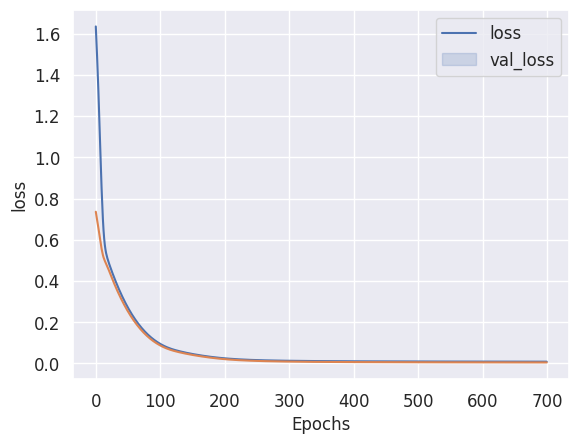

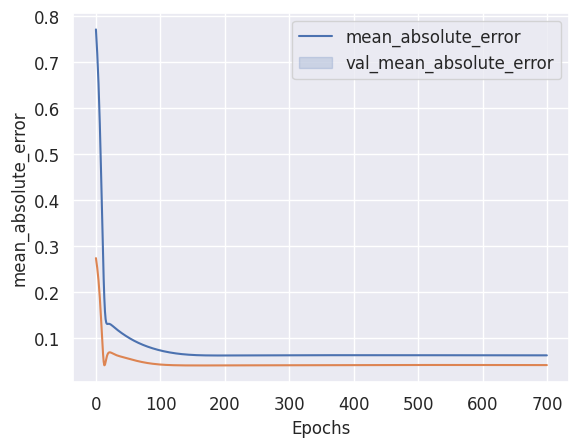

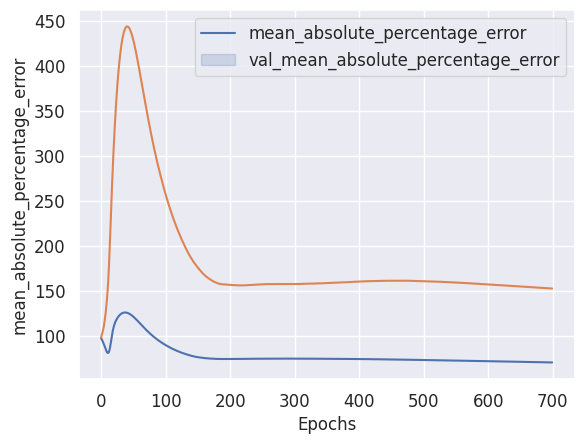

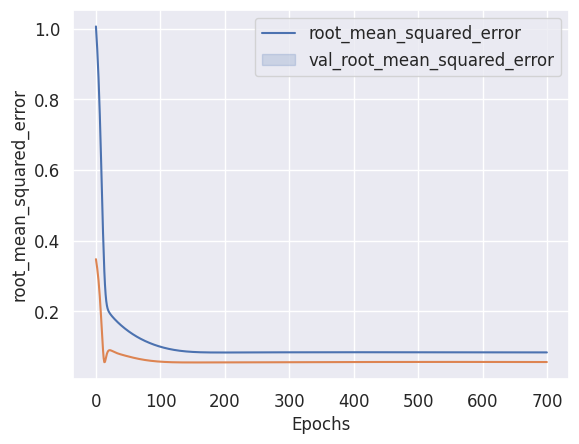

In [7]:
#training dataset
train_loss, train_RMSE, train_MAE, train_MAPE = model.evaluate(x_train, y_train)

print('\n','Evaluation of Training dataset:','\n''\n','train_loss:',round(train_loss,3),'\n','train_RMSE:',round(train_RMSE,3),'\n', 'train_MAE:',round(train_MAE,3),'\n','train_MAPE:',round(train_MAPE,3))


#val dataset
val_loss, val_RMSE, val_MAE, val_MAPE = model.evaluate(x_test, y_test)
print('\n','Evaluation of Testing dataset:','\n''\n','val_loss:',round(val_loss,3),'\n','val_RMSE:',round(val_RMSE,3),'\n', 'val_MAE:',round(val_MAE,3),'\n','val_MAPE:',round(val_MAPE,3))

# predict on val set



mlflow.log_metric('train_loss',train_loss)
mlflow.log_metric('RMSE', train_RMSE)
mlflow.log_metric('MAE', train_MAE)
mlflow.log_metric('MAPE',train_MAPE)

mlflow.log_metric('val_loss',val_loss)
mlflow.log_metric('val_RMSE', val_RMSE)
mlflow.log_metric('val_MAE', val_MAE)
mlflow.log_metric('val_MAPE',val_MAPE)

mlflow.keras.save_model(model, path =path_model+'/')

path_metrics+'/'+'data.csv'
df = pd.read_csv(path_metrics+'/'+'data.csv')

metricplot(df, 'epoch', 'loss','val_loss', path_metrics)
metricplot(df, 'epoch', 'mean_absolute_error','val_mean_absolute_error', path_metrics)
metricplot(df, 'epoch', 'mean_absolute_percentage_error','val_mean_absolute_percentage_error', path_metrics)
metricplot(df, 'epoch', 'root_mean_squared_error','val_root_mean_squared_error', path_metrics)

In [8]:
y_test_pred = model.predict(x_test)
MAPE_pred = tf.keras.losses.MeanAbsolutePercentageError()
print("The MAPE on the test data is:",round(MAPE_pred(y_test, y_test_pred).numpy(),3))

32/32 [==============================] - 1s 3ms/step
The MAPE on the test data is: 152.743


In [13]:
model.save(path_model+'/'+model_name)   
#model_name = 'lstm_128.h5'
#path_model_tr ="../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model" 
model_eval = load_model(path_model+'/'+model_name, compile=False)

# get future dates and predict the future close price!
future_days = 100

startdate = list(df_datetime['date'])[-1]
startdate = pd.to_datetime(startdate) + pd.DateOffset(days=1)
enddate = pd.to_datetime(startdate) + pd.DateOffset(days=future_days+1)
forecasting_dates= pd.bdate_range(start=startdate, end=enddate, freq = 'B')
number_of_days = len(forecasting_dates)
forecast = model_eval.predict(train_data_X[-len(forecasting_dates):])
forecast_copies = np.repeat(forecast, df_data.shape[1], axis = -1 )
y_pred_fut = scaler.inverse_transform(forecast_copies)[:,0]
forecast_close = {'dates':forecasting_dates ,'close': y_pred_fut, 'close_orig':data['open'].iloc[-number_of_days:] }
forecasting_df = pd.DataFrame(data = forecast_close)
forecasting_df.to_csv(path_forecast +'/'+ 'forecast.csv')
print('The forecast for the future',number_of_days,'days is:','\n',forecasting_df)

3/3 [==============================] - 1s 4ms/step
The forecast for the future 73 days is: 
           dates     close  close_orig
9927 2022-11-02  1.015232     1.02287
9928 2022-11-03  1.020367     1.02088
9929 2022-11-04  1.023710     1.02202
9930 2022-11-07  1.023536     1.01147
9931 2022-11-08  1.024242     1.01997
...         ...       ...         ...
9995 2023-02-06  0.984040     0.99610
9996 2023-02-07  0.986290     1.00783
9997 2023-02-08  0.990715     0.99642
9998 2023-02-09  0.995837     0.99465
9999 2023-02-10  1.001583     0.98724

[73 rows x 3 columns]


In [14]:
#y_test_pred = model.predict(x_test)
MAPE_pred = tf.keras.losses.MeanAbsolutePercentageError()
print("The MAPE on the test data is:",round(MAPE_pred(forecasting_df['close'], forecasting_df['close_orig']).numpy(),3),"%")

The MAPE on the test data is: 0.944 %


<AxesSubplot: xlabel='dates', ylabel='close'>

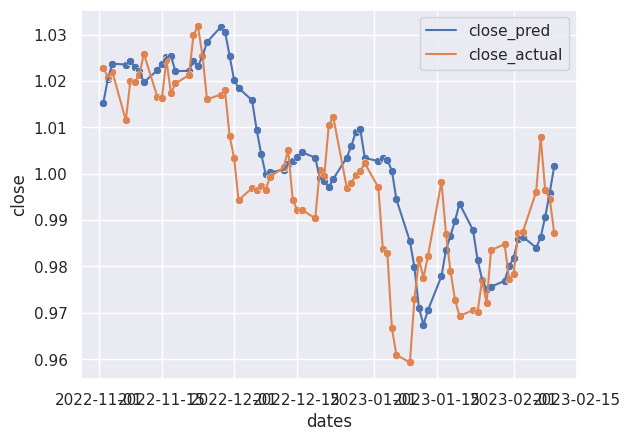

In [15]:
sns.lineplot(data = forecasting_df, x  = forecasting_df['dates'], y = forecasting_df['close'], label='close_pred')
sns.scatterplot(data = forecasting_df, x  = forecasting_df['dates'], y = forecasting_df['close'])

sns.lineplot(data = forecasting_df, x = forecasting_df['dates'], y = forecasting_df['close_orig'],label='close_actual')
sns.scatterplot(data = forecasting_df, x = forecasting_df['dates'], y = forecasting_df['close_orig'])

In [12]:
import pickle
with open('EU_scaler_std.bin', 'wb') as f_out:
    pickle.dump((scaler), f_out)